# **HR-аналитика: прогнозирование удовлетворённости сотрудников и их увольнений**

**Описание проекта**

Компания «Работа с заботой» предоставила данные о сотрудниках, включая их характеристики и уровень удовлетворённости работой. Удовлетворённость измеряется с помощью тест-опросников, которые сотрудники заполняют, и рассчитывается как доля от 0 до 1 (0 — совершенно неудовлетворён, 1 — полностью удовлетворён). Сбор таких данных требует времени и усилий, поэтому важно автоматизировать процесс прогнозирования удовлетворённости и увольнений сотрудников.

Удовлетворённость работой напрямую влияет на отток сотрудников, что несёт риски для компании. Внезапные увольнения, особенно ключевых сотрудников, могут привести к финансовым потерям и сбоям в работе.

Проект состоит из двух задач:

1. Прогнозирование уровня удовлетворённости сотрудников на основе предоставленных данных.

2. Прогнозирование увольнений сотрудников на основе тех же данных.


**Цель исследования**

1. Построить модель для прогнозирования уровня удовлетворённости сотрудников работой в компании.

2. Построить модель для прогнозирования увольнений сотрудников из компании.

**Задачи исследования**

Задача 1: Прогнозирование уровня удовлетворённости

- Спрогонозировать уровень удовлетворенности работой
- Оценить качество моделей с помощью метрики SMAPE (цель: SMAPE ≤ 15 на тестовой выборке).


Задача 2: Прогнозирование увольнений

- Построить портрет уволенного сотрудника
- Спрогнозировать увольнения
- Оценить качество моделей с помощью метрики ROC-AUC (цель: ROC-AUC ≥ 0.91 на тестовой выборке).

**Исходные данные и их описание**

Данные для задачи 1:
Тренировочная выборка: train_job_satisfaction_rate.csv

Тестовая выборка: test_features.csv (входные признаки), test_target_job_satisfaction_rate.csv (целевой признак).

Данные для задачи 2:
Тренировочная выборка: train_quit.csv

Тестовая выборка: test_features.csv (входные признаки), 
test_target_quit.csv (целевой признак).


Описание признаков:

`id`: уникальный идентификатор сотрудника.

`dept`: отдел, в котором работает сотрудник.

`level`: уровень занимаемой должности (например, junior, middle, senior).

`workload`: уровень загруженности сотрудника (например, low, medium, high).

`employment_years`: длительность работы в компании (в годах).

`last_year_promo`: было ли повышение за последний год (бинарный признак).

`last_year_violations`: нарушал ли сотрудник трудовой договор за последний год (бинарный признак).

`supervisor_evaluation`: оценка качества работы сотрудника, которую дал руководитель (числовой признак).

`salary`: ежемесячная зарплата сотрудника.

`job_satisfaction_rate`: уровень удовлетворённости сотрудника работой в компании (целевой признак для задачи 1).

`quit`: увольнение сотрудника из компании (целевой признак для задачи 2).



## Необходимые импорты

In [1]:
!pip install shap phik -q

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import shap
import phik
from phik.report import plot_correlation_matrix
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    recall_score, 
    precision_score)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant



# загружаем класс pipeline
from sklearn.pipeline import Pipeline
# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer


# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, r2_score, mean_absolute_error, root_mean_squared_error

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif


# загружаем нужные модели
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, LinearSVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance


from sklearn.exceptions import ConvergenceWarning 
from sklearn.tree import export_text
from sklearn.tree import plot_tree

import warnings
from IPython.display import Markdown as md
warnings.simplefilter('ignore', DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
sns.set_theme()

In [5]:
RANDOM_STATE = 42
TEST_SIZE = .25
DEFAULT_COLOR = '#8174A0'

In [6]:
def analyze_residuals(residuals, predictions, model_string=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    sns.histplot(residuals, ax=axes[0], color='#ECDBBA', bins=20)
    if model_string is not None:
        axes[0].set_title(f'Гистограмма распределения остатков [{model_string}]')
    else:
        axes[0].set_title(f'Гистограмма распределения остатков')
        
    axes[0].axvline(x=residuals.mean(), label='среднее', color='red', ls='--')
    axes[0].axvline(x=0, label='нулевой уровень', color='green')
    axes[0].legend()
    
    
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(predictions, residuals)
    axes[1].axhline(y=0, color='red', ls='--')
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    if model_string is not None:
        axes[1].set_title(f'Анализ дисперсии [{model_string}]')
    else:
        axes[1].set_title(f'Анализ дисперсии')
    plt.show()

In [7]:
def add_bar_labels(ax):
    """
    Добавляет метки к столбикам диаграммы, поддерживает старые версии matplotlib.
    """
    if hasattr(ax, 'bar_label') and len(ax.containers) > 0:  # Для новых версий matplotlib
        for container in ax.containers:
            # print(f"Container: {container.datavalues}")  # Отладочная информация
            ax.bar_label(container, fmt=f'%.2f', label_type='edge')  # Поменяйте формат при необходимости
    else:  # Для старых версий matplotlib
        for bar in ax.patches:
            # Получаем значение столбца
            bar_value = bar.get_width() if bar.get_width() > 0 else bar.get_height()
            
            # Если значение слишком маленькое, преобразуем его в текст с двумя знаками после запятой
            text = f'{bar_value:.2f}' if bar_value < 1 else f'{int(bar_value)}'
            
            # Определяем положение текста
            if bar.get_width() > 0:  # Горизонтальная диаграмма
                x_pos = bar.get_x() + bar.get_width() + 0.1
                y_pos = bar.get_y() + bar.get_height() / 2
            else:  # Вертикальная диаграмма
                x_pos = bar.get_x() + bar.get_width() / 2
                y_pos = bar.get_y() + bar.get_height() + 0.1
            
            # print(f"Bar value: {bar_value}, x: {x_pos}, y: {y_pos}")  # Отладочная информация
            
            # Добавляем текст
            ax.text(x_pos, y_pos, text, ha='center', va='center')
    
    plt.tight_layout()  # Компактное размещение графика


In [8]:
def detect_outliers(df: pd.DataFrame, column_name: str, strategy: str):
    if strategy == 'triple_sigma':
        mean = df[column_name].mean()
        std = df[column_name].std()
        return df.query(f'~( @mean - 3 * @std < {column_name} < @mean + 3 * @std)')
    elif strategy == 'iqr':
        q25 = df[column_name].quantile(.25)
        q75 = df[column_name].quantile(.75)
        iqr = q75 - q25
        return df.query(f'~( @q25 - 1.5 * @iqr < {column_name} < @q75 + 1.5 * @iqr)')

In [9]:
def outliers_report(df: pd.DataFrame, column_names , strategy: str):
    report = []
    for cn in column_names:
        if strategy == 'triple_sigma':
            mean = df[cn].mean()
            std = df[cn].std()
            report.append({
            'column_name': cn,
            'left outliers count': df.query(f'@mean - 3 * @std > {cn}').shape[0],
            'left outliers %': df.query(f'@mean - 3 * @std > {cn}').shape[0] / df.shape[0] * 100,
            
            'right outliers count': df.query(f'@mean + 3 * @std < {cn}').shape[0],
            'right outliers %': df.query(f'@mean + 3 * @std < {cn}').shape[0] / df.shape[0] * 100   
        })
        elif strategy == 'iqr':
            q25 = df[cn].quantile(.25)
            q75 = df[cn].quantile(.75)
            iqr = q75 - q25
            report.append({
            'column_name': cn,
            'left outliers count': df.query(f'@q25 - 1.5 * @iqr > {cn}').shape[0],
            'left outliers %': df.query(f'@q25 - 1.5 * @iqr > {cn}').shape[0] / df.shape[0] * 100,
            
            'right outliers count': df.query(f'@q75 + 1.5 * @iqr < {cn}').shape[0],
            'right outliers %': df.query(f'@q75 + 1.5 * @iqr < {cn}').shape[0] / df.shape[0] * 100 
        })
    return pd.DataFrame(report).round(2)


In [10]:
def plot_graphics(df, column_name, test_df=None, bins=30, range_hist=None, hist_color='#519872', boxplot_color='#B9D2D2', col_alias='', xlabel='', ylabel='', figsize=(10, 10)):
    if test_df is not None:
        fig, ax = plt.subplots(2, 2, figsize=figsize)
        ax = ax.flatten()
    
        ax1 = sns.histplot(data=df, x=column_name, ax=ax[0], bins=bins, binrange=range_hist, color=hist_color)
        ax1.set_title(f'[Train] Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
        ax2 = sns.boxplot(data=df, x=column_name, ax=ax[1], color=boxplot_color)
        ax2.set_title(f'[Train] Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
        ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
        ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        
        ax1 = sns.histplot(data=test_df, x=column_name, ax=ax[2], bins=bins, binrange=range_hist, color=hist_color)
        ax1.set_title(f'[Test] Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
        ax2 = sns.boxplot(data=test_df, x=column_name, ax=ax[3], color=boxplot_color)
        ax2.set_title(f'[Test] Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
        ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
        ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
        return 

        
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1 = sns.histplot(data=df, x=column_name, ax=ax[0], bins=bins, binrange=range_hist, color=hist_color)
    ax1.set_title(f'Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
    ax2 = sns.boxplot(data=df, x=column_name, ax=ax[1], color=boxplot_color)
    ax2.set_title(f'Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
    ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
    ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
    ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения') 

In [11]:
def process_outliers(df: pd.DataFrame, column_name: str, strategy: str, do: str):
    df = df.copy()
    if strategy == 'triple_sigma':
        mean = df[column_name].mean()
        std = df[column_name].std()
        if do == 'delete':
            return df.query(f'(@mean - 3 * @std < {column_name} < @mean + 3 * @std)')
        elif do == 'fill_na':
            df.loc[~(mean - 3 * std < df[f'{column_name}']) | ~(df[f'{column_name}'] < mean + 3 * std), f'{column_name}'] = np.nan
            return df
    elif strategy == 'iqr':
        q25 = df[column_name].quantile(.25)
        q75 = df[column_name].quantile(.75)
        iqr = q75 - q25
        if do == 'delete':
            return df.query(f'( @q25 - 1.5 * @iqr < {column_name} < @q75 + 1.5 * @iqr)')
        elif do == 'fill_na':
            df.loc[~(q25 - 1.5 * iqr < df[f'{column_name}']) | ~(df[f'{column_name}'] < q75 + 1.5 * iqr), f'{column_name}'] = np.nan
            return df

In [12]:
def pieplot(train, test, column, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    
    (train[column]
     .value_counts()
     .plot(
         kind='pie',
         autopct="%.0f%%",
         ylabel="",
         title=f"{title} [Train]",
         colormap='Pastel1',
         ax=ax[0],
         # figsize=(7, 7),
         fontsize=14
          ));
    
    (test[column]
     .value_counts()
     .plot(
         kind='pie',
         autopct="%.0f%%",
         ylabel="",
         title=f"{title} [Test]",
         colormap='Pastel1',
         ax=ax[1],
         # figsize=(7, 7),
         fontsize=14
          ));

In [ ]:
def promo_violations_percentage(train, test, index_var, col_var, figsize=(20, 12), title_part=None):
    fig, ax = plt.subplots(2, 2, figsize=figsize)
    ax = ax.flatten()

    _piv_train = (train
 .pivot_table(
     index=index_var, 
     columns=col_var, 
     values='id', 
     aggfunc='count')
 .fillna(0))
    
    _piv_test = (test
 .pivot_table(
     index=index_var, 
     columns=col_var, 
     values='id', 
     aggfunc='count')
 .fillna(0))

    
    
    (
    (_piv_train.div(_piv_train.sum(axis=1), axis=0) * 100)
 .round(2)
 .plot(
     kind='bar', 
     ax=ax[0],
     title=f'Процент {title_part} [Train]',
     colormap='Paired',
     legend='best'
 )
);

    (_piv_train
 .plot(
     kind='bar', 
     ax=ax[1],
     title=f'Количество {title_part} [Train]',
     colormap='Paired',
     legend='best'
     # legend=False,
     # color=DEFAULT_COLOR
 )
);
    
    (
    (_piv_test.div(_piv_test.sum(axis=1), axis=0) * 100)
 .round(2)
 .plot(
     kind='bar', 
     ax=ax[2],
     title=f'Процент {title_part} [Test]',
     colormap='Paired',
     legend='best'
 )
);

    (_piv_test
 .plot(
     kind='bar', 
     ax=ax[3],
     title=f'Количество {title_part} [Test]',
     colormap='Paired',
     legend='best'
     # legend=False,
     # color=DEFAULT_COLOR
 )
);
    ax[0].tick_params(rotation=0)
    ax[1].tick_params(rotation=0)
    ax[2].tick_params(rotation=0)
    ax[3].tick_params(rotation=0)
    ax[0].legend(bbox_to_anchor=(1, 0.6))
    ax[1].legend(bbox_to_anchor=(1, 0.6))    
    ax[2].legend(bbox_to_anchor=(1, 0.6))    
    ax[3].legend(bbox_to_anchor=(1, 0.6))    

## Датасет `train_job_satisfaction_rate.csv`

In [ ]:
try:
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
except:
    train_job_satisfaction_rate = pd.read_csv('path')

In [15]:
train_job_satisfaction_rate.head()

id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

In [16]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


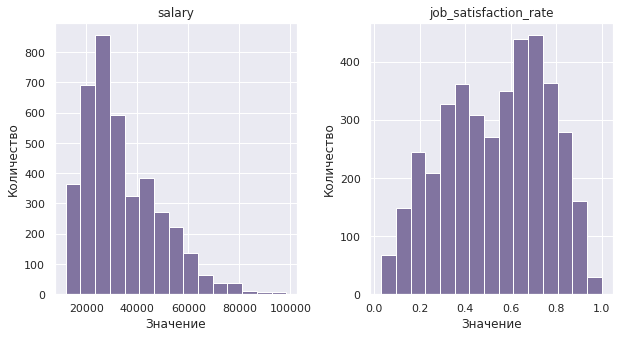

In [17]:
ax = (train_job_satisfaction_rate
 .drop(columns=['id', 'employment_years', 'supervisor_evaluation'])
 .hist(
     figsize=(10, 5), 
     bins=15,
     color=DEFAULT_COLOR,
     
 ));

for t in list(ax.flatten()):
    t.set_xlabel('Значение')
    t.set_ylabel('Количество')    

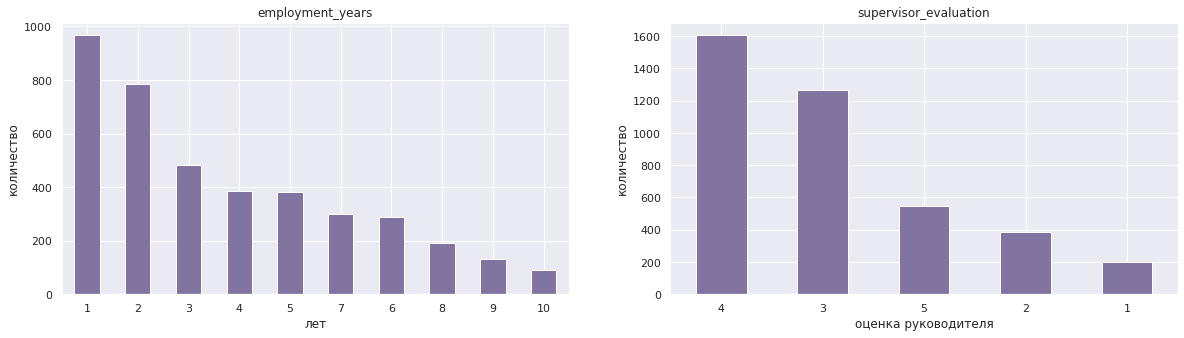

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.flatten()

discrete_cols = [('employment_years', 'лет'), ('supervisor_evaluation', 'оценка руководителя')]

for idx, dc in enumerate(discrete_cols):
    a = (train_job_satisfaction_rate
 [dc[0]].value_counts()
 .plot(
     kind='bar',
     color=DEFAULT_COLOR,
     title=dc[0],
     xlabel=dc[1],
     ax=ax[idx],
     ylabel='количество'
 ));

    a.tick_params(rotation=0)

### Исследование на пропуски

In [19]:
train_job_satisfaction_rate.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [20]:
train_job_satisfaction_rate.loc[train_job_satisfaction_rate.isna().sum(axis=1) > 0]

id   dept   level workload  employment_years last_year_promo  \
1209  631073  sales     NaN   medium                 1              no   
1469  416327  sales     NaN      low                 1              no   
1526  694746    NaN  junior   medium                 5              no   
1630  814624    NaN  junior   medium                 3              no   
1633  475114    NaN  junior     high                 4              no   
1745  135043  sales     NaN   medium                 1              no   
2522  998838  sales     NaN   medium                 1              no   
2781  497243    NaN  junior   medium                 1              no   
2975  168668    NaN  junior      low                 3              no   
3866  641150    NaN  junior      low                 3              no   

     last_year_violations  supervisor_evaluation  salary  \
1209                   no                      4   27600   
1469                   no                      5   18000   
1526                   no                      4   21600   
1630                   no                      4   24000   
1633                   no                      4   31200   
1745                   no                      3   26400   
2522                   no                      5   27600   
2781                   no                      3   26400   
2975                   no                      4   18000   
3866                  yes                      4   12000   

      job_satisfaction_rate  
1209                   0.66  
1469                   0.73  
1526                   0.62  
1630                   0.88  
1633                   0.63  
1745                   0.30  
2522                   0.71  
2781                   0.28  
2975                   0.88  
3866                   0.54

Пропуски находятся в категориальных столбцах. Всего 10 строк с пропусками, будем заполнять их в пайплайне

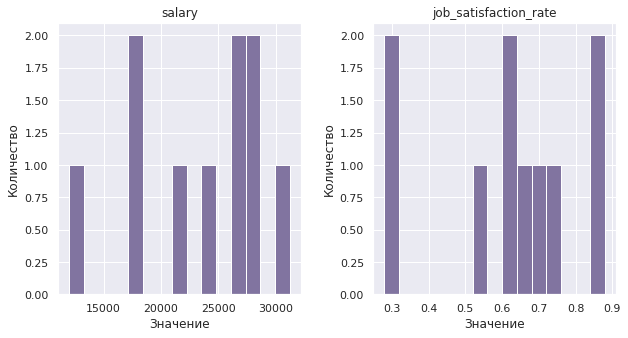

In [21]:
ax = (train_job_satisfaction_rate.loc[train_job_satisfaction_rate.isna().sum(axis=1) > 0]
 .drop(columns=['id', 'employment_years', 'supervisor_evaluation'])
 .hist(
     figsize=(10, 5), 
     bins=15,
     color=DEFAULT_COLOR,
     
 ));

for t in list(ax.flatten()):
    t.set_xlabel('Значение')
    t.set_ylabel('Количество')    

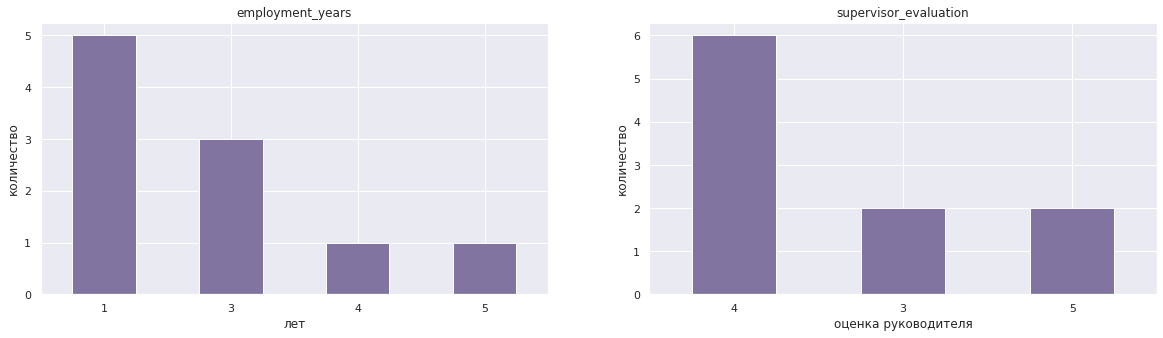

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.flatten()

discrete_cols = [('employment_years', 'лет'), ('supervisor_evaluation', 'оценка руководителя')]

for idx, dc in enumerate(discrete_cols):
    a = (train_job_satisfaction_rate.loc[train_job_satisfaction_rate.isna().sum(axis=1) > 0]
 [dc[0]].value_counts()
 .plot(
     kind='bar',
     color=DEFAULT_COLOR,
     title=dc[0],
     xlabel=dc[1],
     ax=ax[idx],
     ylabel='количество'
 ));

    a.tick_params(rotation=0)

### Исследование на дубликаты

In [23]:
train_job_satisfaction_rate.duplicated().sum()

0

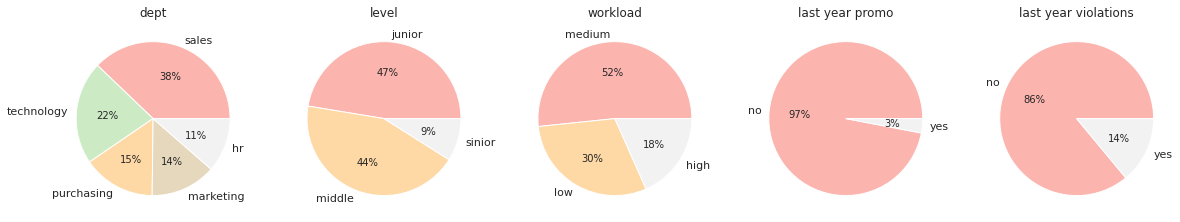

In [24]:
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax = ax.flatten()

object_columns = list(train_job_satisfaction_rate.select_dtypes('object').columns)

for i, obj_col in enumerate(object_columns):
    (train_job_satisfaction_rate[obj_col]
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.0f%%",
     ylabel="",
     title=f"{obj_col.replace('_', ' ')}",
     colormap='Pastel1',
     ax=ax[i]
      ));

In [25]:
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].replace({
    'sinior': 'senior'
})

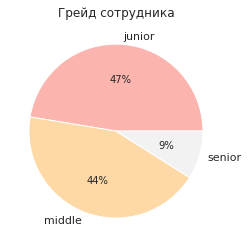

In [26]:
(train_job_satisfaction_rate['level']
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.0f%%",
     ylabel="",
     title=f"Грейд сотрудника",
     colormap='Pastel1'
      ));

In [27]:
train_job_satisfaction_rate.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

- Исправлены опечатки в столбце `level`
- Найдены пропуски, но их мало. Заполнением займемся в пайплайнах при обучении моделей
- Распределения числовых столбцов мало похожи на нормальное распределение

## Датасет `test_features.csv`

In [ ]:
try:
    test_features = pd.read_csv('/datasets/test_features.csv')
except:
    test_features = pd.read_csv('path')

In [29]:
test_features.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

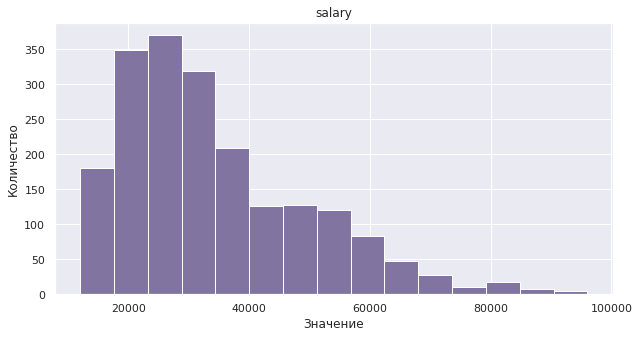

In [30]:
ax = (test_features
 .drop(columns=['id', 'employment_years', 'supervisor_evaluation'])
 .hist(
     figsize=(10, 5), 
     bins=15,
     color=DEFAULT_COLOR,
     
 ));

for t in list(ax.flatten()):
    t.set_xlabel('Значение')
    t.set_ylabel('Количество')    

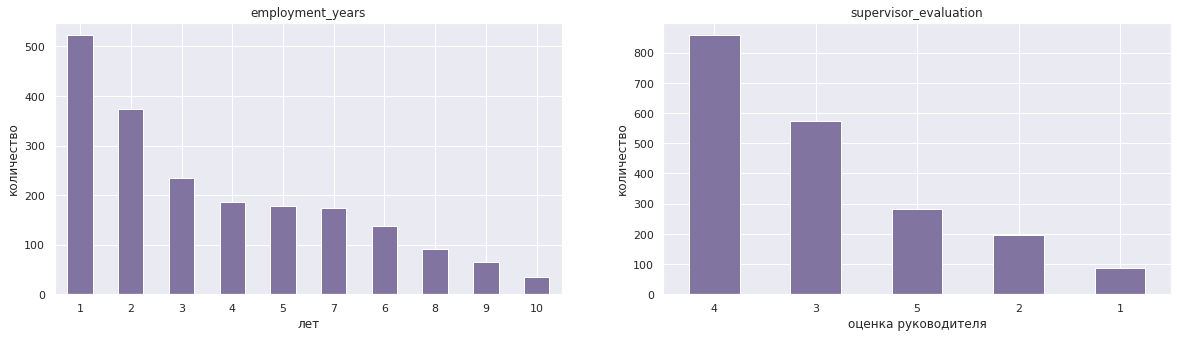

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.flatten()

discrete_cols = [('employment_years', 'лет'), ('supervisor_evaluation', 'оценка руководителя')]

for idx, dc in enumerate(discrete_cols):
    a = (test_features
 [dc[0]].value_counts()
 .plot(
     kind='bar',
     color=DEFAULT_COLOR,
     title=dc[0],
     xlabel=dc[1],
     ax=ax[idx],
     ylabel='количество'
 ));

    a.tick_params(rotation=0)

### Исследование на пропуски

In [32]:
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [33]:
test_features.loc[test_features.isna().sum(axis=1) > 0]

id   dept   level workload  employment_years last_year_promo  \
191   609865    NaN  junior   medium                 1              no   
312   471990  sales     NaN      low                 1              no   
1196  832342    NaN  junior   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary  
191                    no                      1   20400  
312                    no                      3   12000  
1196                   no                      4   28800

### Исследование на дубликаты

In [34]:
test_features.duplicated().sum()

0

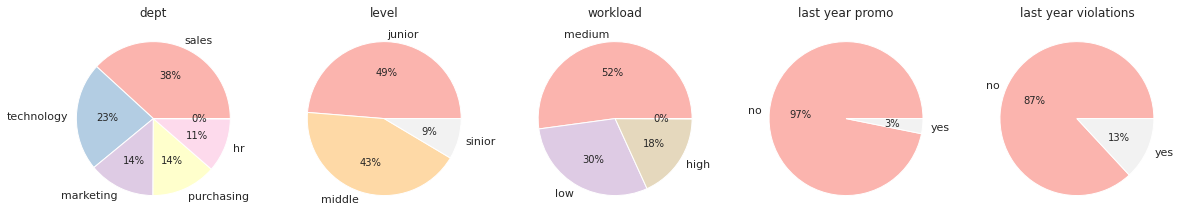

In [35]:
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax = ax.flatten()

object_columns = list(test_features.select_dtypes('object').columns)

for i, obj_col in enumerate(object_columns):
    (test_features[obj_col]
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.0f%%",
     ylabel="",
     title=f"{obj_col.replace('_', ' ')}",
     colormap='Pastel1',
     ax=ax[i]
      ));

In [36]:
test_features[test_features.workload == " "]

id       dept   level workload  employment_years last_year_promo  \
15  590867  marketing  junior                          4              no   

   last_year_violations  supervisor_evaluation  salary  
15                   no                      4   28800

In [37]:
test_features[test_features.dept == " "]

id dept   level workload  employment_years last_year_promo  \
1699  822186       middle   medium                 3              no   

     last_year_violations  supervisor_evaluation  salary  
1699                   no                      4   38400

- Найдены опечатки в столбце `level`
- Найдены пропуски, но их мало. Заполнением займемся в пайплайнах при обучении моделей
- Распределения числовых столбцов мало похожи на нормальное распределение
- Найдены весьма странные значения в столбцах `dept` и `workload`

## Датасет `test_target_job_satisfaction_rate.csv`

In [ ]:
try:
    test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    test_target = pd.read_csv('path')

In [39]:
test_target.head()

id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08

## Датасет `train_quit.csv`

In [ ]:
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
except:
    train_quit = pd.read_csv('path')

In [41]:
train_quit.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no

In [42]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


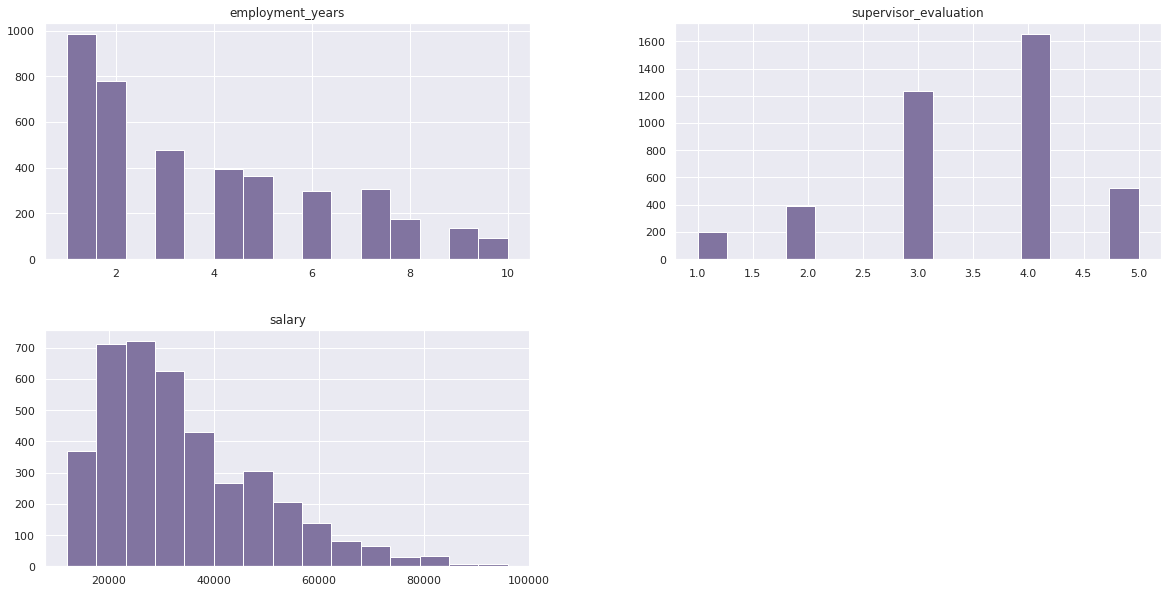

In [43]:
(train_quit
 .drop(columns='id')
 .hist(
     figsize=(20, 10), 
     bins=15,
     color=DEFAULT_COLOR
 ));

### Исследование на пропуски

In [44]:
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

### Исследование на дубликаты

In [45]:
train_quit.duplicated().sum()

0

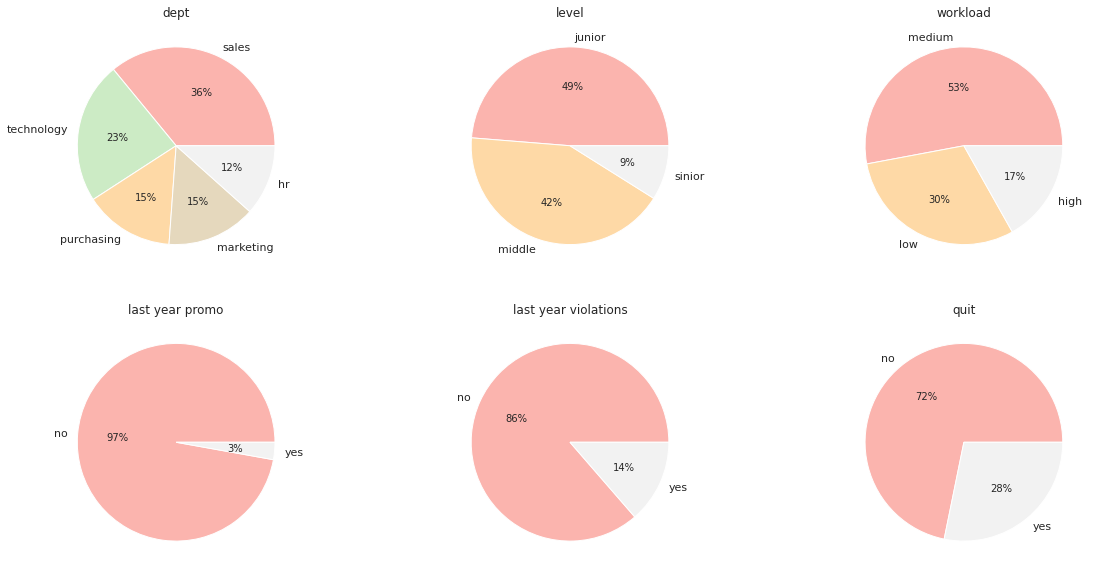

In [46]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.flatten()

object_columns = list(train_quit.select_dtypes('object').columns)

for i, obj_col in enumerate(object_columns):
    (train_quit[obj_col]
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.0f%%",
     ylabel="",
     title=f"{obj_col.replace('_', ' ')}",
     colormap='Pastel1',
     ax=ax[i]
      ));

In [47]:
train_quit['level'] = train_quit['level'].replace({
    'sinior': 'senior'
})

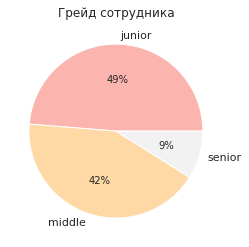

In [48]:
(train_quit['level']
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.0f%%",
     ylabel="",
     title=f"Грейд сотрудника",
     colormap='Pastel1'
      ));

In [49]:
train_quit.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit'],
      dtype='object')

- Исправлены опечатки в столбце `level`
- Пропуски не найдены
- Распределения числовых столбцов мало похожи на нормальное распределение

## Датасет `test_target_quit.csv.csv`

In [ ]:
try:
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
except:
    test_target_quit = pd.read_csv('path')

In [51]:
test_target_quit.head()

id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes

# Задание №1

## Исследовательский анализ

### Датасет `train_job_satisfaction_rate.csv`

#### Столбец `dept`

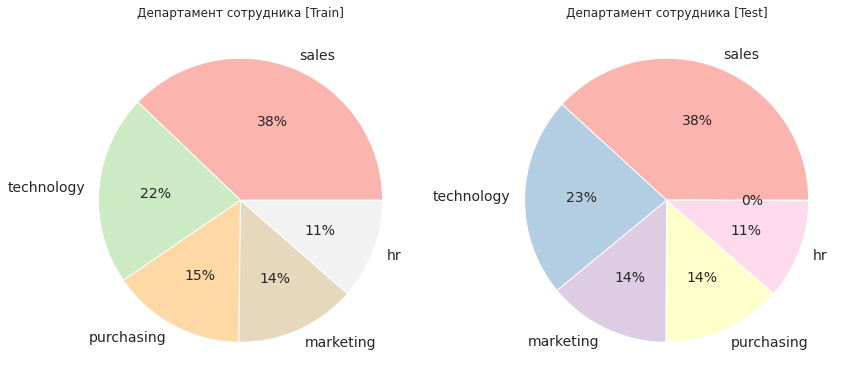

In [52]:
pieplot(train_job_satisfaction_rate, test_features, 'dept', 'Департамент сотрудника')

- Больше всего сотрудников, представленных в тренировочной выборке - сотрудники отдела продаж (38%)
- Меньше всего в отделе `hr`
- Распределения по департаментам в тренировочной и тестовой выборках приблизительно одинаковые

#### Столбец `level`

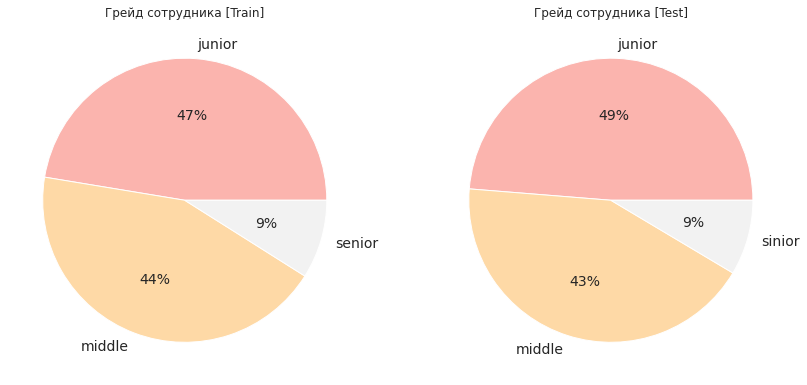

In [53]:
pieplot(train_job_satisfaction_rate, test_features, 'level', 'Грейд сотрудника')

- Больше всего джунов как в тренировочной, так и в тестовой выборках.
- Меньше всего опытных разработчиков

#### Столбец `workload`

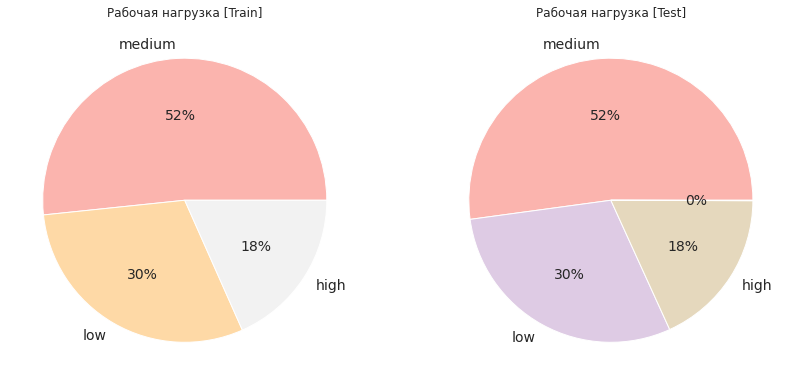

In [54]:
pieplot(train_job_satisfaction_rate, test_features, 'workload', 'Рабочая нагрузка')

- Сотрудников со средней нагрузкой больше половины в обеих выборках

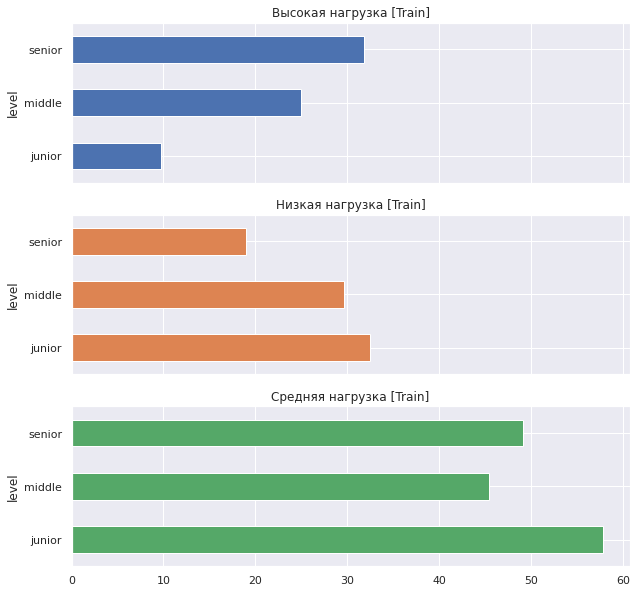

In [55]:
_piv = (train_job_satisfaction_rate.pivot_table(
     index='level', 
     columns='workload', 
     values='id', 
     aggfunc='count'))

((_piv.div(_piv.sum(axis=1), axis=0) * 100)
 .rename(
     columns={
         'high': 'Высокая нагрузка [Train]', 
         'low': 'Низкая нагрузка [Train]', 
         'medium': 'Cредняя нагрузка [Train]'
     })
 .plot(
     kind='barh', 
     subplots=True,
     figsize=(10, 10),
     legend=False))

plt.xticks(rotation=0);

- Среди сотрудников с высокой нагрузкой выделяется группа старших специалистов. В процентном соотношении эти сотрудники самые занятые. Наименьший процент сотрудников с высокой нагрузкой в группе джунов
- Среди сотрудников с низкой нагрузкой в процентном соотношении лидируют джуны, опытные специалисты в этой группе имеют наименьшую долю
- Средняя нагрузка характерна для всех групп специалистов. Однако в процентном соотношении лидируют джуны и синьоры

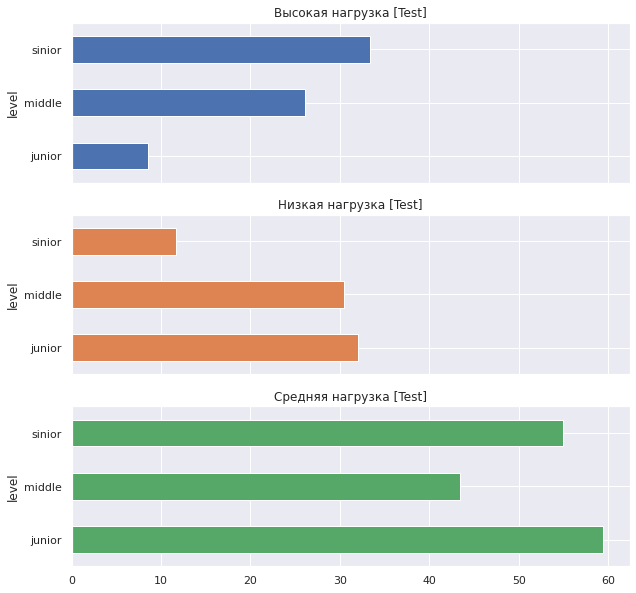

In [214]:
_piv = (test_features.query('workload != " " and dept != " "').pivot_table(
     index='level', 
     columns='workload', 
     values='id', 
     aggfunc='count'))

((_piv.div(_piv.sum(axis=1), axis=0) * 100)
 .rename(
     columns={
         'high': 'Высокая нагрузка [Test]', 
         'low': 'Низкая нагрузка [Test]', 
         'medium': 'Cредняя нагрузка [Test]'
     })
 .plot(
     kind='barh', 
     subplots=True,
     figsize=(10, 10),
     legend=False))

plt.xticks(rotation=0);

В тестовой выборке ситуация идентичная

#### Столбец `last_year_promo`

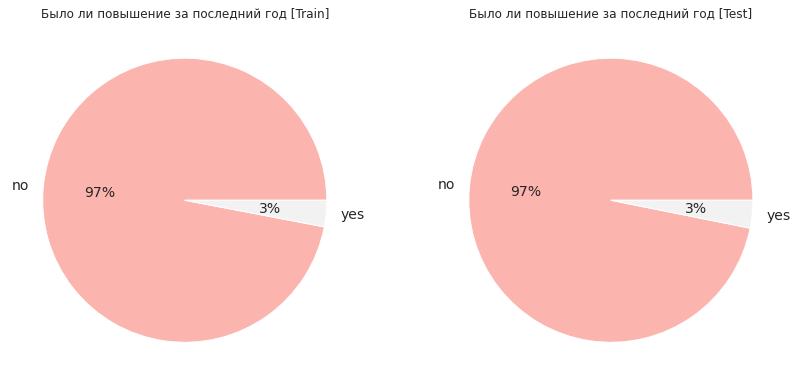

In [57]:
pieplot(train_job_satisfaction_rate, test_features, 'last_year_promo', 'Было ли повышение за последний год')

В компании повышение - редкость.

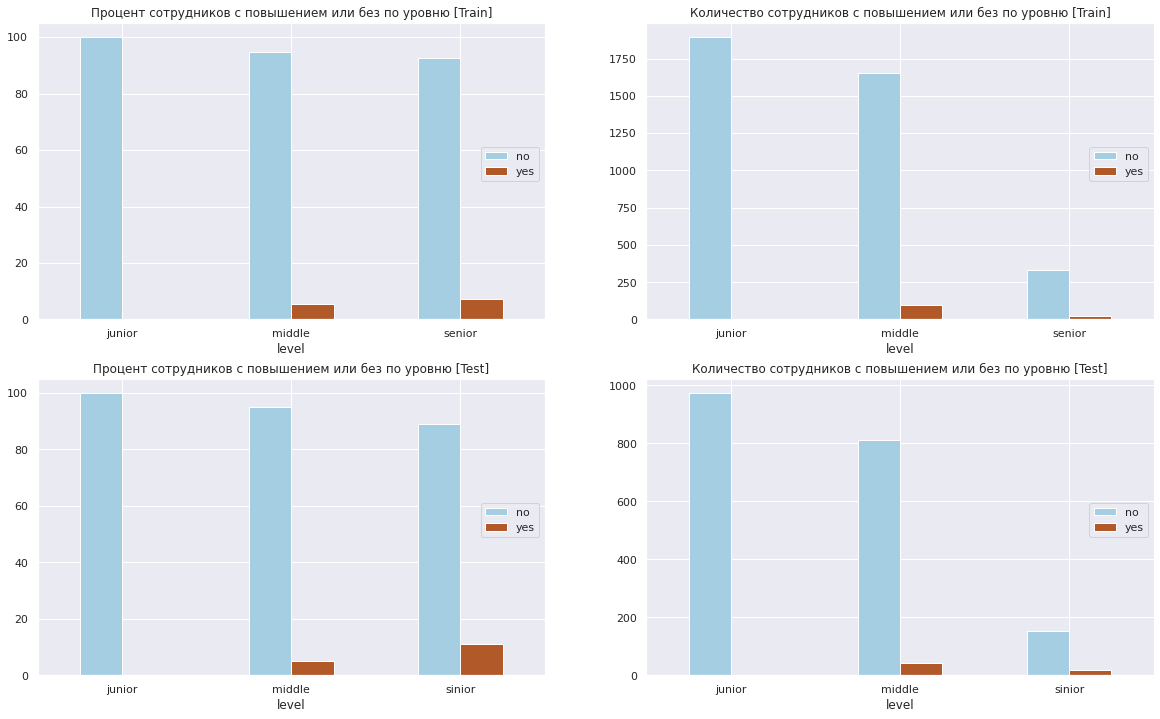

In [58]:
promo_violations_percentage(train_job_satisfaction_rate, 
                            test_features, 
                            title_part='cотрудников с повышением или без по уровню',
                            index_var='level', 
                            col_var='last_year_promo')

- В процентном соотношении наибольший процент повышений наблюдается у самых опытных сотрудников. Хотя наиболее многочисленная группа по повышениям - миддлы
- Не наблюдаются повышения джунов за последний год
- В тестовой выборке все идентично

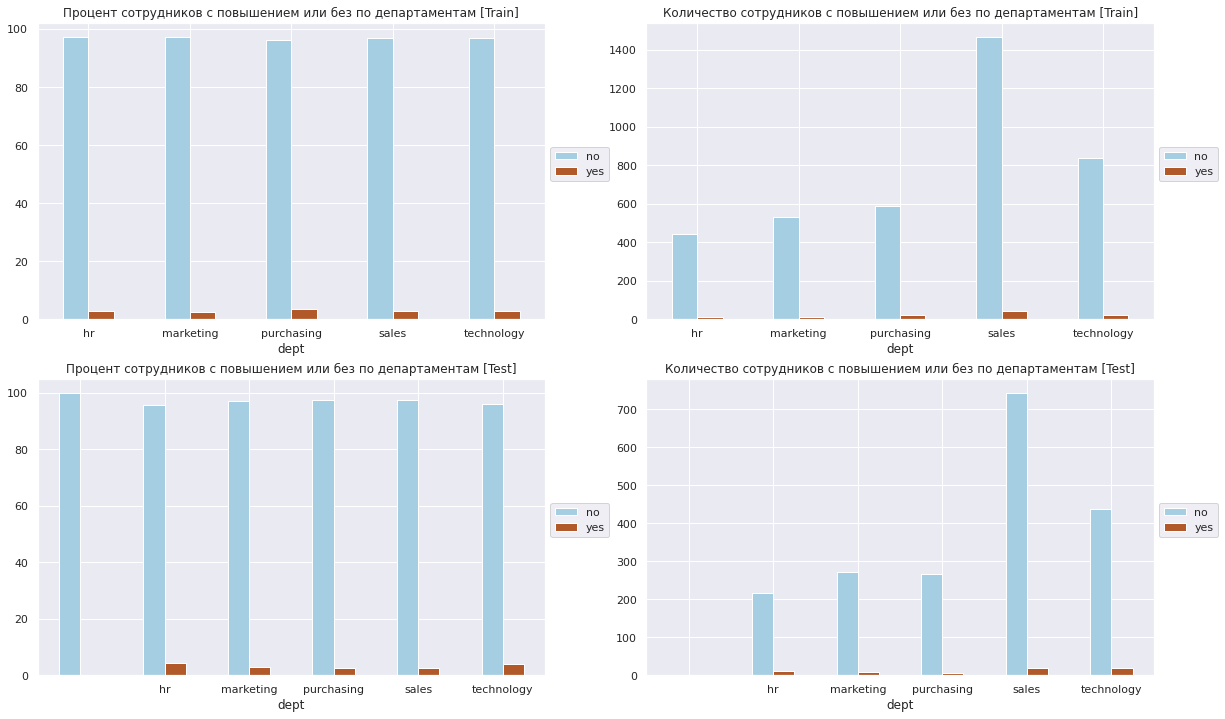

In [59]:
promo_violations_percentage(train_job_satisfaction_rate, 
                            test_features, 
                            title_part='cотрудников с повышением или без по департаментам', 
                            index_var='dept', 
                            col_var='last_year_promo')

- В процентном соотношении наибольший процент повышений наблюдается у сотрудников отдела закупок. Хотя наиболее многочисленная группа по повышениям - отдел продаж. 
- В тестовой выборке в процентом соотношении повышений больше всего в отделах `hr` и `technology`. Однако больше всего повышений представлено в отделе продаж

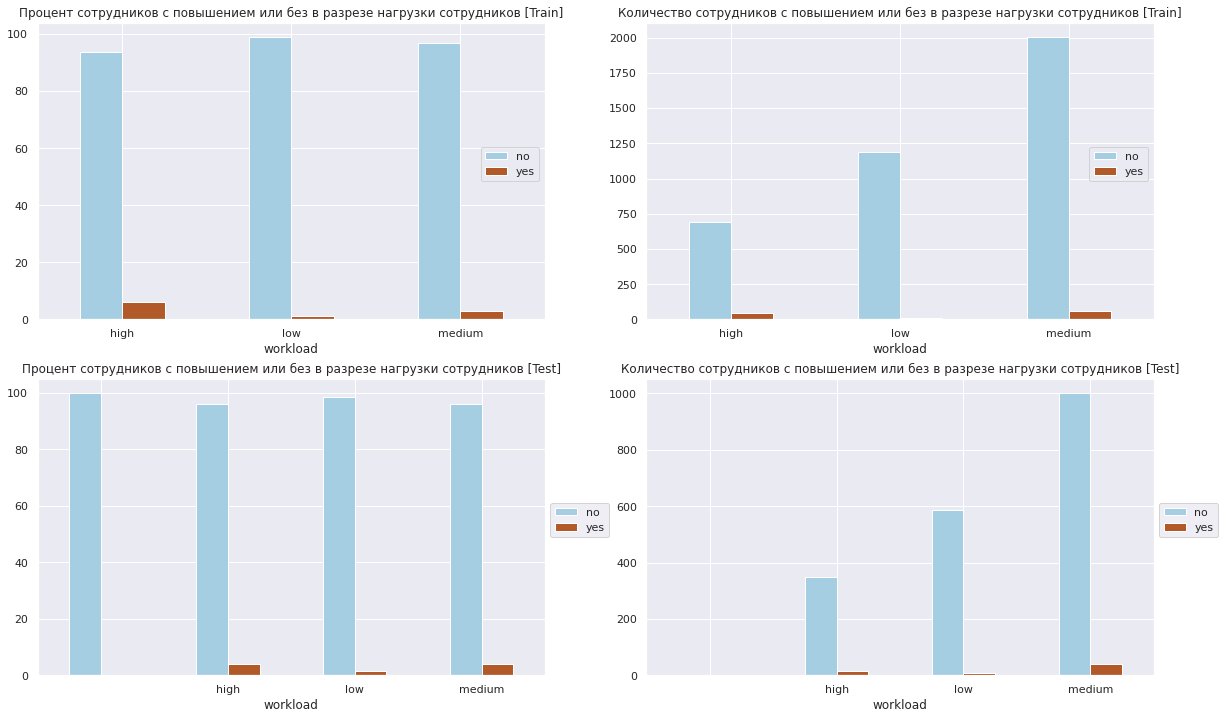

In [60]:
promo_violations_percentage(train_job_satisfaction_rate, 
                            test_features, 
                            title_part='cотрудников с повышением или без в разрезе нагрузки сотрудников', 
                            index_var='workload', 
                            col_var='last_year_promo')

- По проценту повышений лидирует группа сотрудников с высокой рабочей нагрузкой. Наиболее многочисленная группа сотрудников с повышением имеет среднюю нагрузку 
- В тестовой выборке по проценту повышений лидирует группа сотрудников со средней рабочей нагрузкой. Наиболее многочисленная группа сотрудников с повышением также имеет среднюю нагрузку 

#### Столбец `last_year_violations`

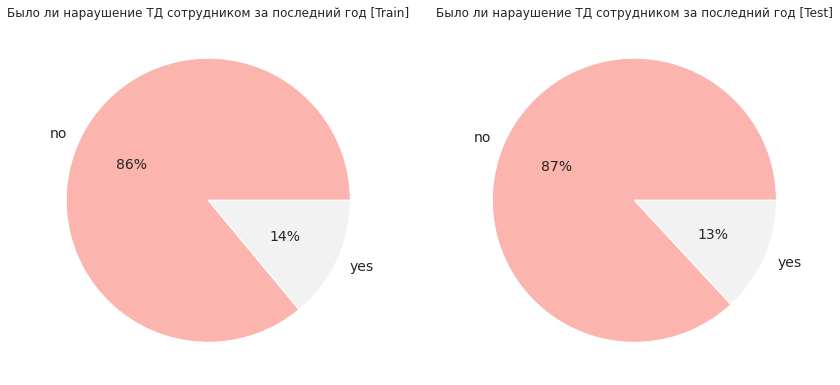

In [61]:
pieplot(train_job_satisfaction_rate, 
        test_features, 
        'last_year_violations', 
        'Было ли нараушение ТД сотрудником за последний год')

- Все таки нарушений договора существенно меньше

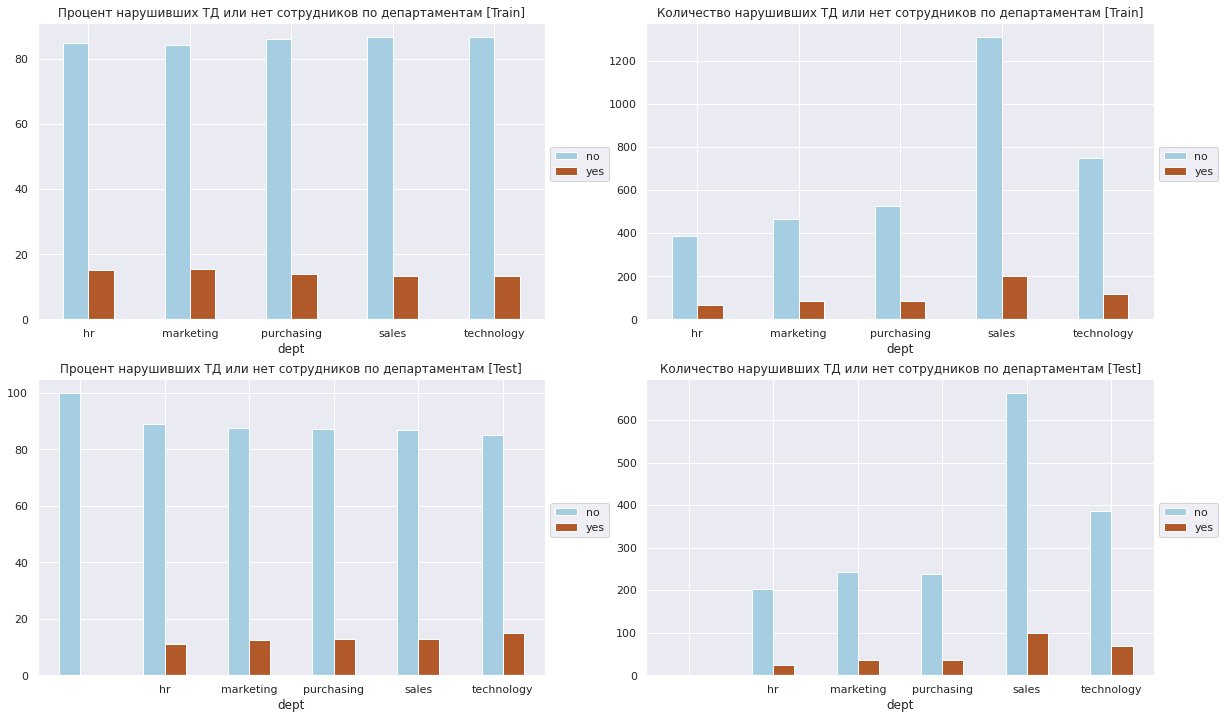

In [62]:
promo_violations_percentage(train_job_satisfaction_rate, 
                            test_features, 
                            title_part='нарушивших ТД или нет сотрудников по департаментам', 
                            index_var='dept', 
                            col_var='last_year_violations')

- По проценту нарушений трудового договора лидирует отдел маркетинга, больше всего по количеству нарушивших ТД сотрудников в отделе прождаж
- В тестовой выборке ситуация иная по процентному соотношению: здесь лидирует отдел технологий

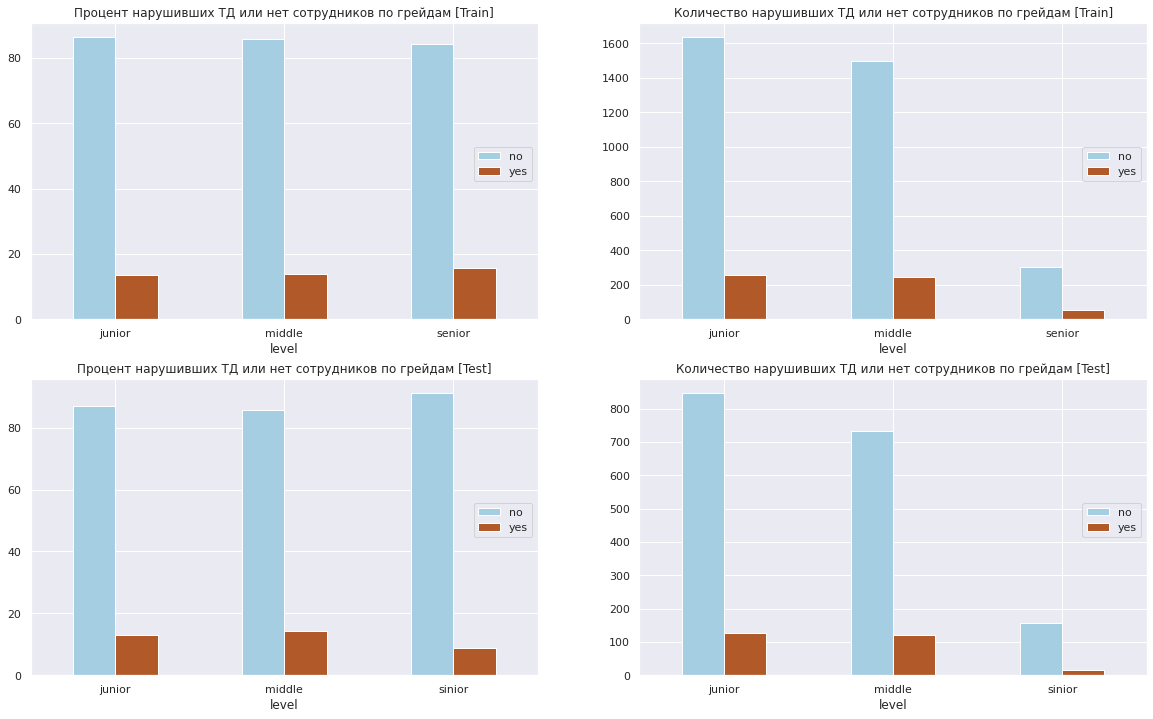

In [63]:
promo_violations_percentage(train_job_satisfaction_rate, 
                            test_features, 
                            title_part='нарушивших ТД или нет сотрудников по грейдам', 
                            index_var='level', 
                            col_var='last_year_violations')

- По проценту нарушений трудового договора лидирует группа опытных специалистов, хотя количественно в группе джунов нарушений больше всего
- В тестовой выборке ситуация иная по процентному соотношению: здесь по количеству нарушений лидирует группа миддлов

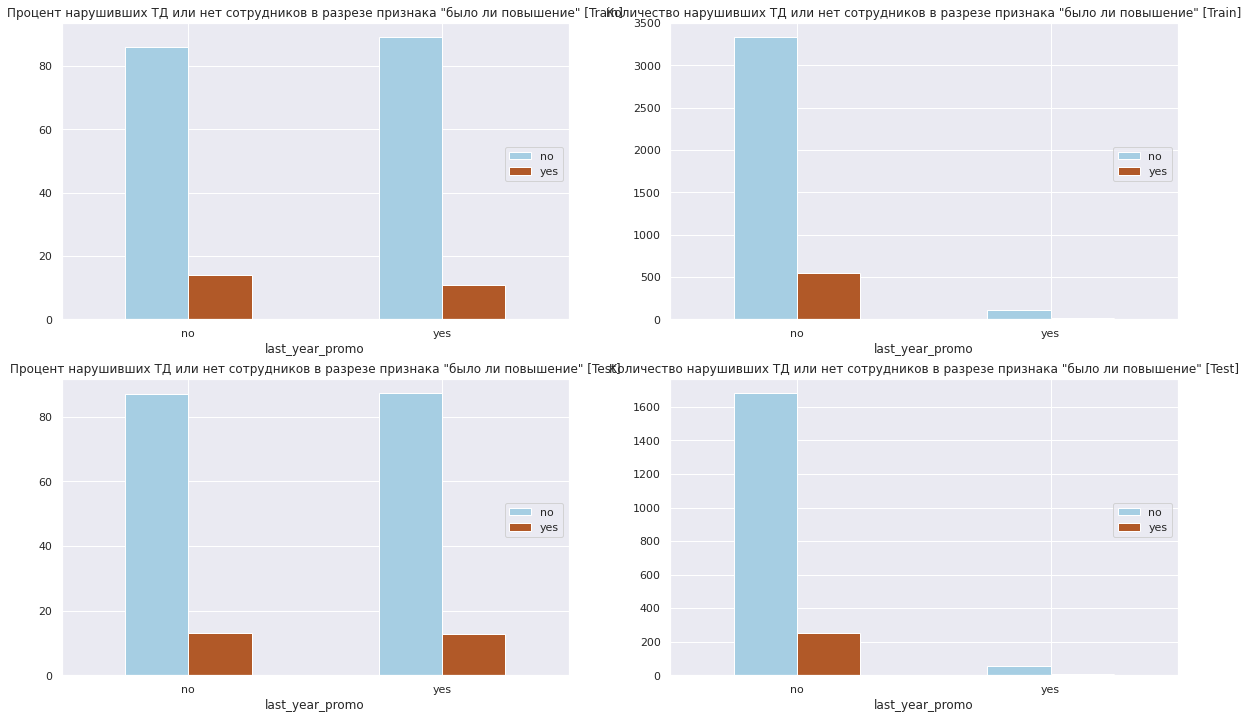

In [64]:
promo_violations_percentage(train_job_satisfaction_rate, 
                            test_features, 
                            title_part='нарушивших ТД или нет сотрудников в разрезе признака "было ли повышение"', 
                            index_var='last_year_promo', 
                            col_var='last_year_violations')

- По проценту нарушений трудового договора выделяется группа сотрудников, которые были повышены в прошлом году. Их порядка 10 процентов
- В тестовой выборке ситуация более сбалансированная в процентном соотношении

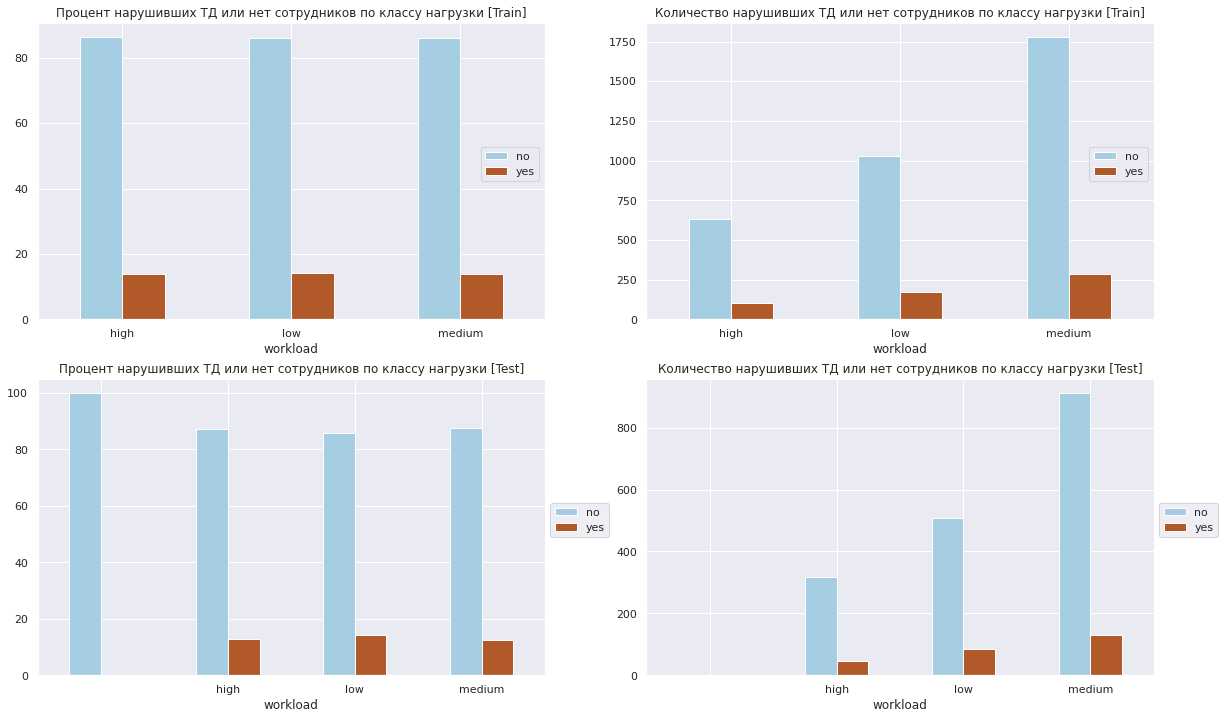

In [65]:
promo_violations_percentage(train_job_satisfaction_rate, 
                            test_features, 
                            title_part='нарушивших ТД или нет сотрудников по классу нагрузки', 
                            index_var='workload', 
                            col_var='last_year_violations')

- По проценту нарушений трудового договора лидирует группа сотрудников с низкой нагрузкой, хотя самая многочисленная - группа сотрудников со средней нагрузкой
- В тестовой выборке ситуация идентичная

#### Столбец `employment_years`

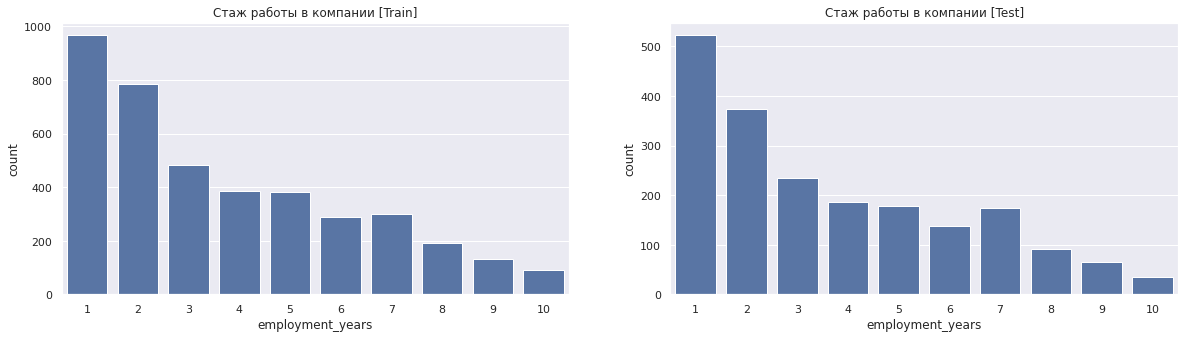

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.flatten()
sns.countplot(data=train_job_satisfaction_rate, 
              x='employment_years', 
              ax=ax[0]).set_title('Стаж работы в компании [Train]');

sns.countplot(data=test_features, 
              x='employment_years', 
              ax=ax[1]).set_title('Стаж работы в компании [Test]');

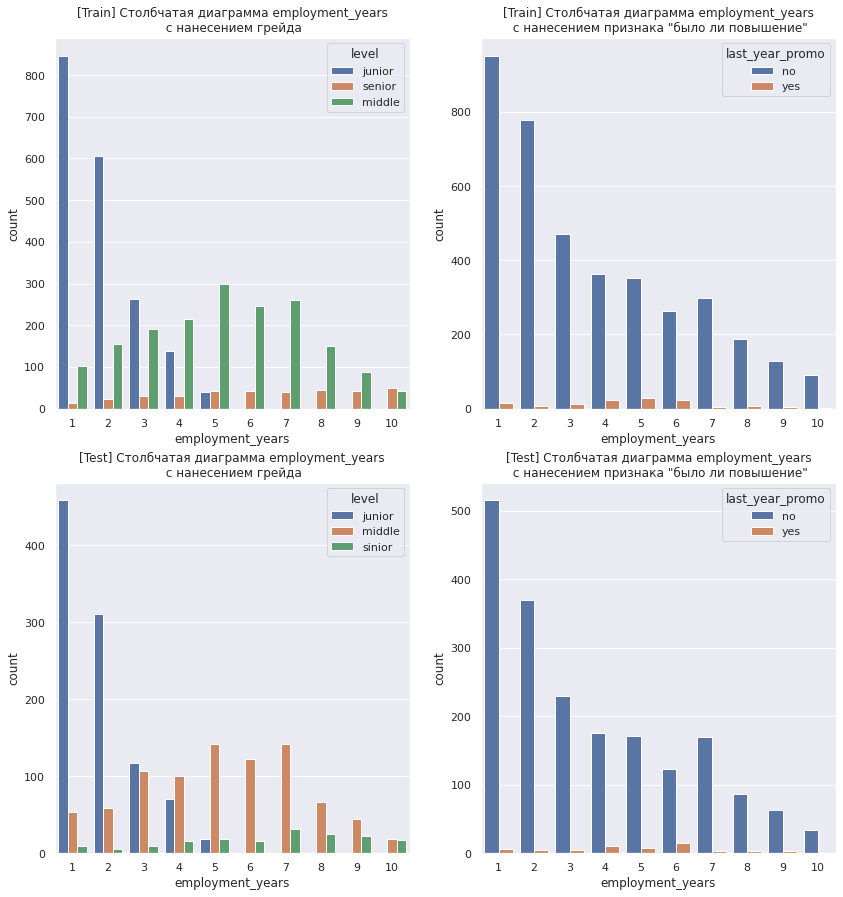

In [67]:
fig, ax = plt.subplots(2, 2, figsize=(14, 15))
ax = ax.flatten()

params = zip(ax[:2], 
             ['level', 'last_year_promo'], 
             ['[Train] Столбчатая диаграмма employment_years\n с нанесением грейда', 
              '[Train] Столбчатая диаграмма employment_years\n с нанесением признака "было ли повышение"'])

for p in params:
    g = sns.countplot(
    data=train_job_satisfaction_rate, 
    x='employment_years', 
    hue=p[1], ax=p[0])
    g.set_title(p[2]);
    
params = zip(ax[2:], 
             ['level', 'last_year_promo'], 
             ['[Test] Столбчатая диаграмма employment_years\n с нанесением грейда', 
              '[Test] Столбчатая диаграмма employment_years\n с нанесением признака "было ли повышение"'])

for p in params:
    g = sns.countplot(
    data=test_features, 
    x='employment_years', 
    hue=p[1], ax=p[0])
    g.set_title(p[2]);

- Отметим, что синьоры в основном работают не менее 2 лет. Возможно, какая-то часть этой группы сотрудников получила опыт, работая именно в этой компании
- В тестовой выборке явно видно, что большинство синьоров работает в компании не менее 3 лет
- Следует также отметить, что, при длительности 6 лет и более джунов нет. Также прослеживается тенденция: при увеличении количества лет работы джунов становиться все меньше и меньше. Если джунов становится меньше, это может быть связано с тем, что они либо повышают свой грейд, либо уходят из компании.
- Повышение становится наиболее вероятным при работы в компании не менее 4 лет.

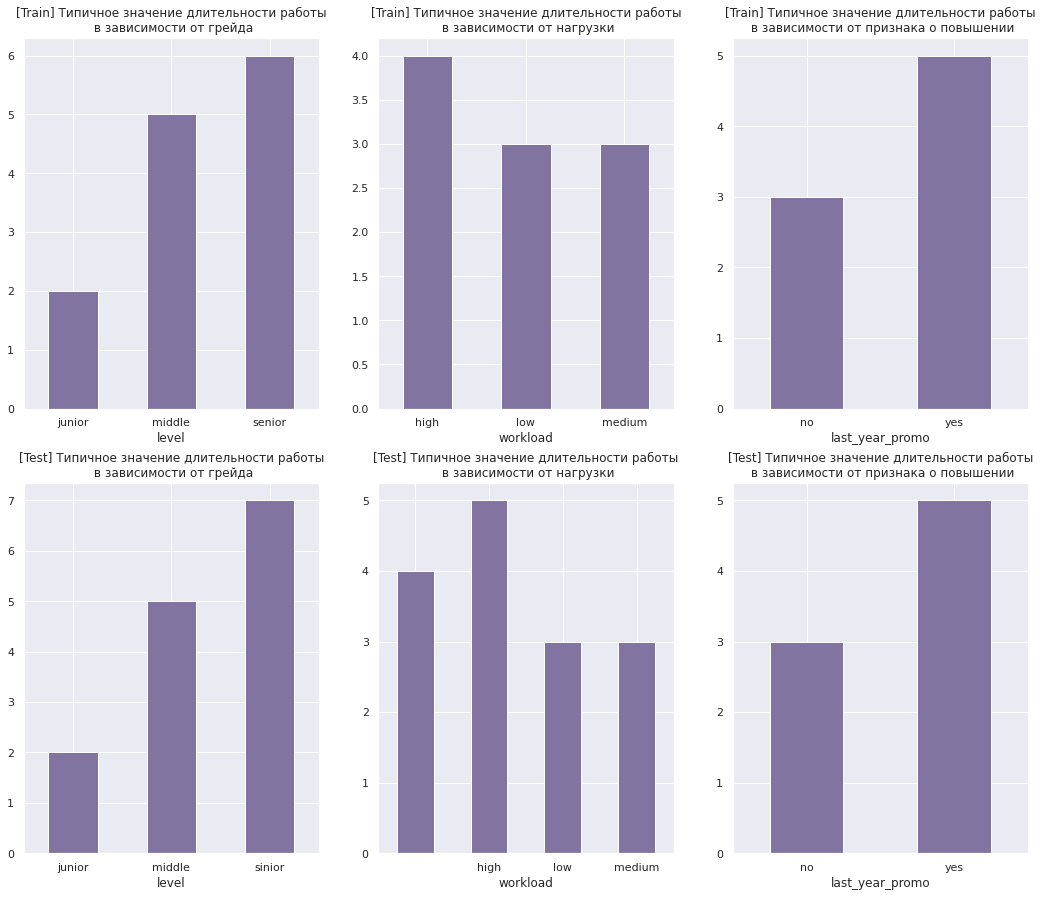

In [68]:
fig, ax = plt.subplots(2, 3, figsize=(18, 15))
ax = ax.flatten()
templ = '[Train] Типичное значение длительности работы'

params = zip(ax[:3], 
             ['level', 'workload', 'last_year_promo'], 
             [templ + '\n в зависимости от грейда', 
              templ + '\n в зависимости от нагрузки',   
              templ + '\n в зависимости от признака о повышении',                                   
             ])

for p in params:
    (train_job_satisfaction_rate.pivot_table(
        index=p[1], 
        values='employment_years', 
        aggfunc='median')[['employment_years']]
    .plot(kind='bar', ax=p[0], legend=False, title=p[2], color=DEFAULT_COLOR)
    )
    
    p[0].tick_params(rotation=0)
    
templ = '[Test] Типичное значение длительности работы'
    
params = zip(ax[3:], 
             ['level', 'workload', 'last_year_promo'], 
             [ templ + '\n в зависимости от грейда', 
              templ + '\n в зависимости от нагрузки',   
              templ + '\n в зависимости от признака о повышении',                                   
             ])

for p in params:
    (test_features.pivot_table(
        index=p[1], 
        values='employment_years', 
        aggfunc='median')[['employment_years']]
    .plot(kind='bar', ax=p[0], legend=False, title=p[2], color=DEFAULT_COLOR)
    )
    
    p[0].tick_params(rotation=0)

- Анализируя типичное значение длительности работы по грейдам, можно сделать вывод, что сотрудники скорее всего растут по грейду именно в этой компании.
- Длительность влияет на нагрузку сотрудника. Высокая нагрузка характерна для сотрудников, которые работают в компании в среднем 4 года. Возможно, доверие руководства определяется опытом работы в этой компании, поэтому давно работающим сотрудникам доверяют больше дел
- Сотрудники с повышением в среднем работают около 5 лет
- Для тестовой выборки результаты идентичные

#### Столбец `supervisor_evaluation`

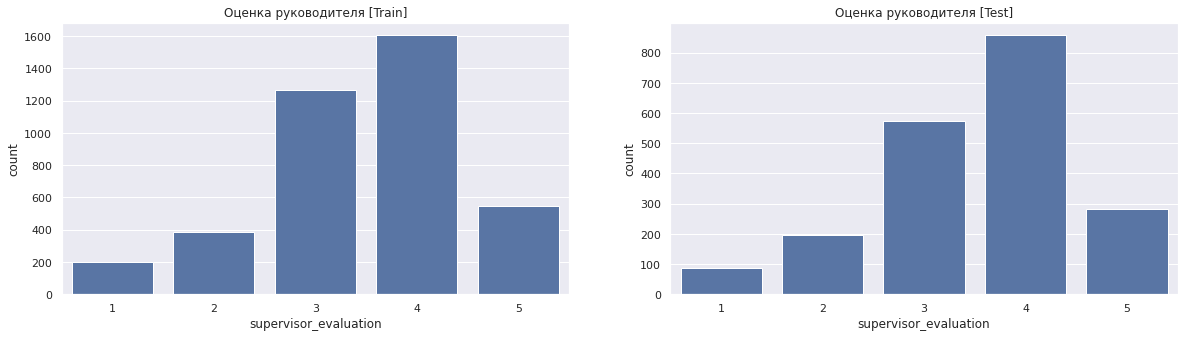

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.flatten()
sns.countplot(data=train_job_satisfaction_rate, 
              x='supervisor_evaluation', 
              ax=ax[0]).set_title('Оценка руководителя [Train]');

sns.countplot(data=test_features, 
              x='supervisor_evaluation', 
              ax=ax[1]).set_title('Оценка руководителя [Test]');

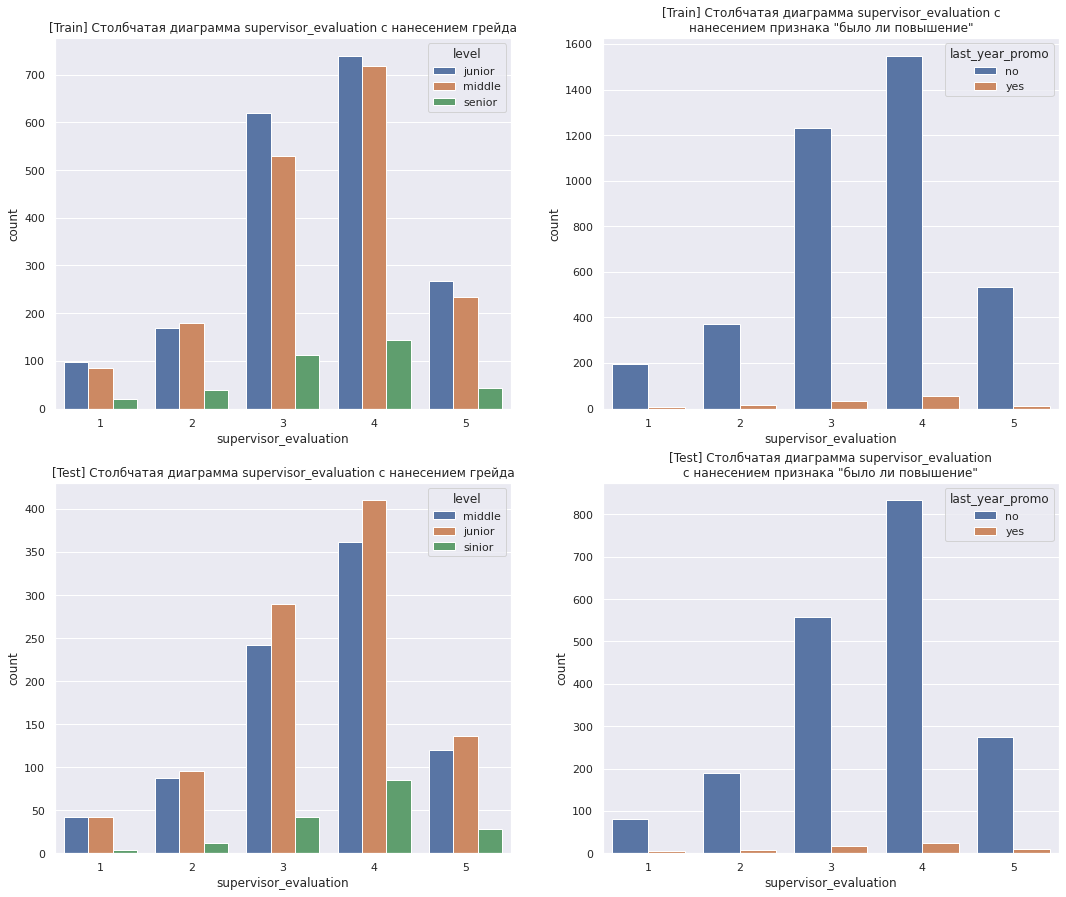

In [70]:
fig, ax = plt.subplots(2, 2, figsize=(18, 15))
ax = ax.flatten()

params = zip(ax[:2], 
             ['level', 'last_year_promo'], 
             ['[Train] Столбчатая диаграмма supervisor_evaluation с нанесением грейда', 
              '[Train] Столбчатая диаграмма supervisor_evaluation с\nнанесением признака "было ли повышение"',
             ])

for p in list(params):
    g = sns.countplot(
    data=train_job_satisfaction_rate, 
    x='supervisor_evaluation', 
    hue=p[1], ax=p[0])
    g.set_title(p[2]);
    
    
params = zip(ax[2:], 
             ['level', 'last_year_promo'], 
             ['[Test] Столбчатая диаграмма supervisor_evaluation с нанесением грейда', 
              '[Test] Столбчатая диаграмма supervisor_evaluation\nс нанесением признака "было ли повышение"',
             ])

for p in list(params):
    g = sns.countplot(
    data=test_features, 
    x='supervisor_evaluation', 
    hue=p[1], ax=p[0])
    g.set_title(p[2]);

- Наиболее популярная оценка руководителем синьоров - 3-5. Самая популярная - 4. Для тестовой выборки аналогично
- Повышение характерно для сотрудников, оцененных руководителем удовлетворительно (3-5). Наиболее вероятно повышение в случае оценки - 4. Возможно, руководитель видит в таком человеке надежного сотрудника с потенциалом для роста, поэтому повышение для них наиболее характерно

#### Столбец `salary`

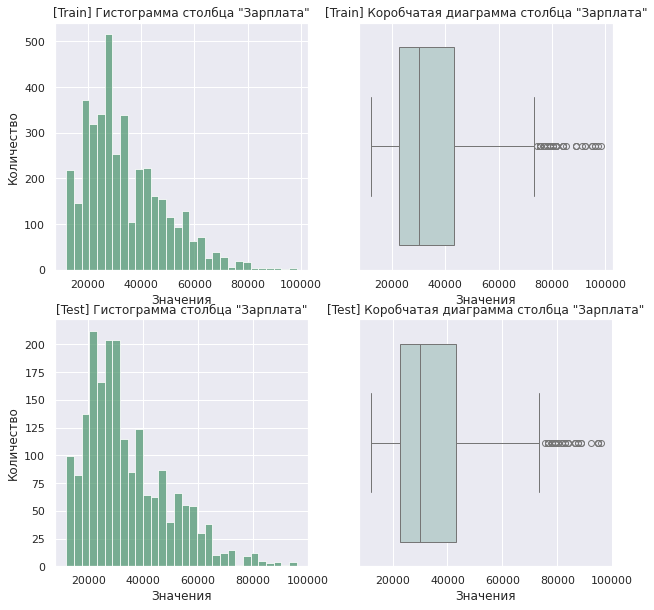

In [71]:
plot_graphics(train_job_satisfaction_rate, 'salary', test_df=test_features, col_alias='"Зарплата"')

In [72]:
pd.DataFrame(
    [train_job_satisfaction_rate.salary.describe(), 
     test_features.salary.describe()]).T.set_axis(['train salary', 'test_salary'], axis=1).round(2)

train salary  test_salary
count        4000.0      2000.00
mean        33926.7     34066.80
std         14900.7     15398.44
min         12000.0     12000.00
25%         22800.0     22800.00
50%         30000.0     30000.00
75%         43200.0     43200.00
max         98400.0     96000.00

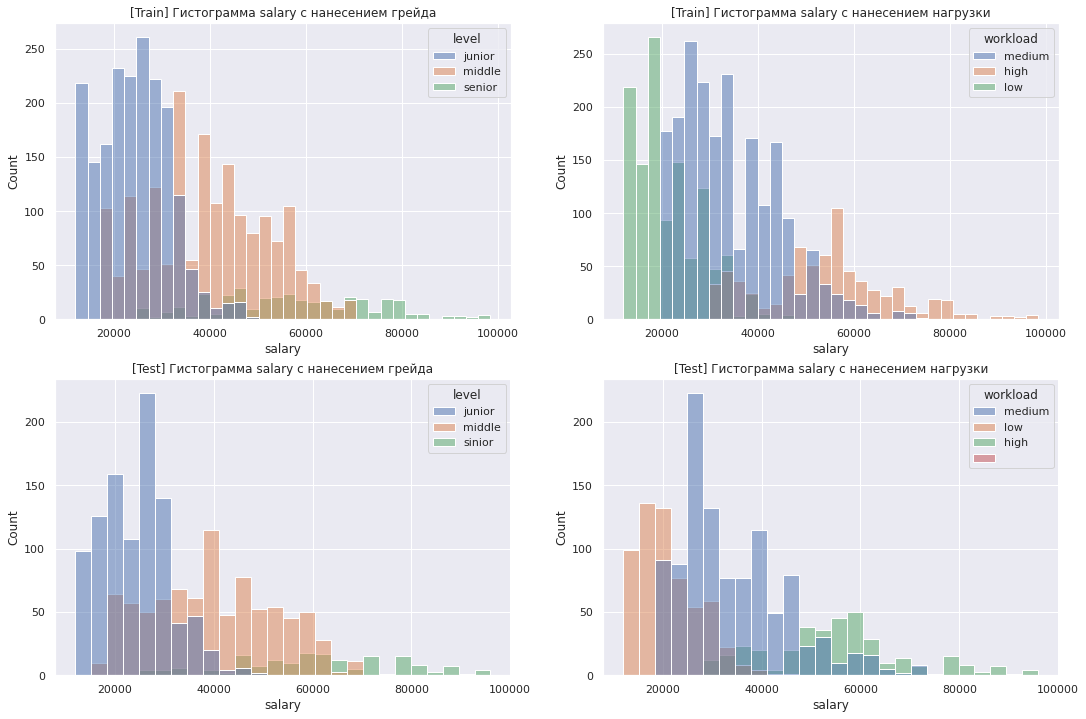

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax = ax.flatten()

params = zip(ax[:2], 
             ['level', 'workload'], 
             ['[Train] Гистограмма salary с нанесением грейда', 
              '[Train] Гистограмма salary с нанесением нагрузки',                     
             ])

for p in params:
    g = sns.histplot(
    data=train_job_satisfaction_rate, 
    x='salary', 
    hue=p[1], ax=p[0])
    g.set_title(p[2]);
    
    
params = zip(ax[2:], 
             ['level', 'workload'], 
             ['[Test] Гистограмма salary с нанесением грейда', 
              '[Test] Гистограмма salary с нанесением нагрузки',                     
             ])

for p in params:
    g = sns.histplot(
    data=test_features, 
    x='salary', 
    hue=p[1], ax=p[0])
    g.set_title(p[2]);

- Зарплаты синьоров смещены вправо в область высоких зарплат, джуны получают до 50к
- Высокая нагрузка влечет смещение гистограммы зарплат в большую сторону. Чем больше нагрузка - тем правее расположена гистограмма зарплат

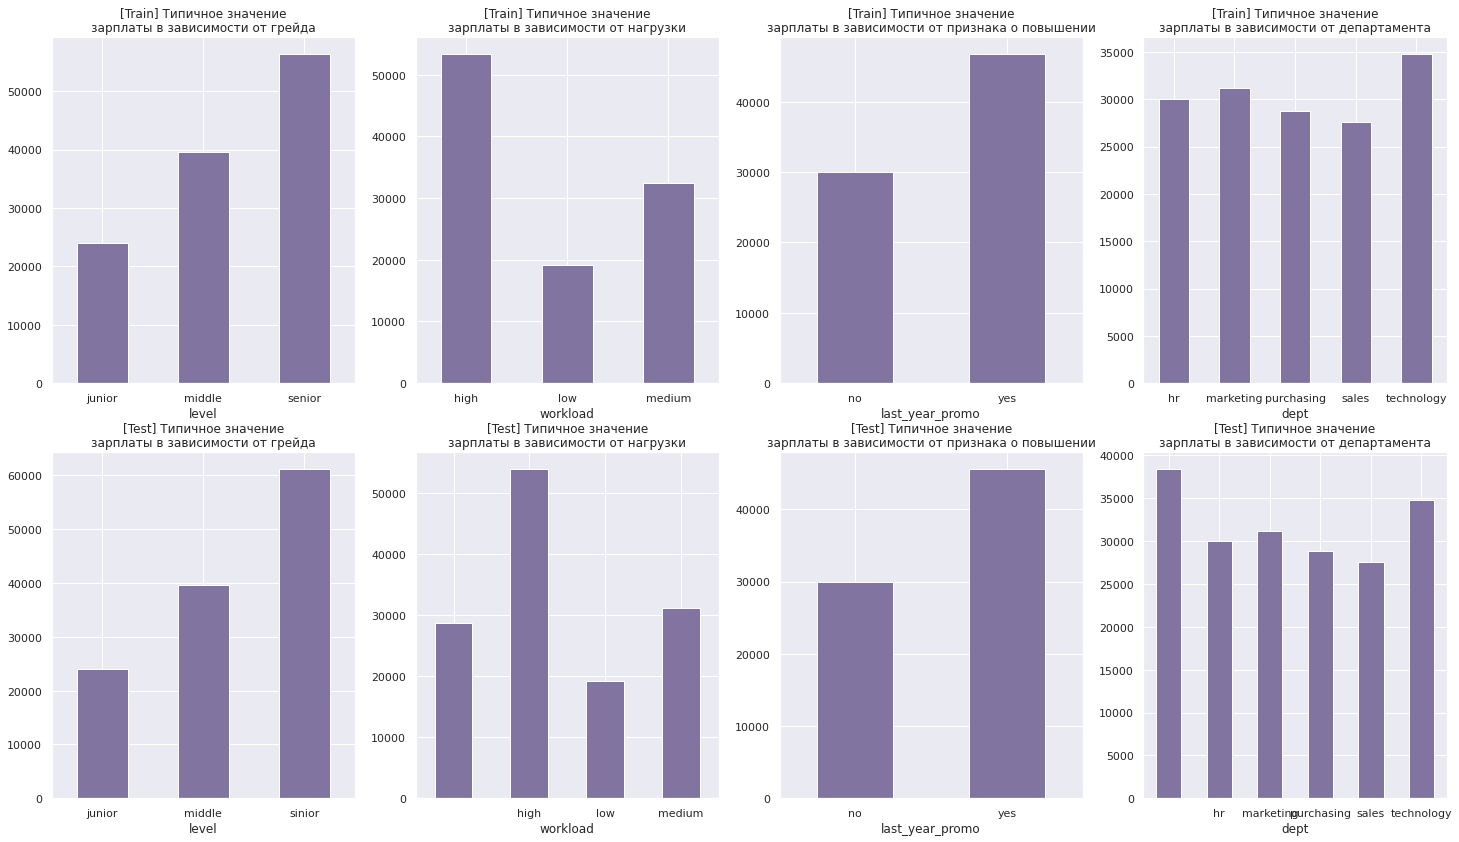

In [74]:
fig, ax = plt.subplots(2, 4, figsize=(25, 14))
ax = ax.flatten()
templ = '[Train] Типичное значение\nзарплаты в зависимости от '
params = zip(ax[:4], 
             ['level', 'workload', 'last_year_promo', 'dept'], 
             [templ + 'грейда', 
              templ + 'нагрузки',   
              templ + 'признака о повышении',                     
              templ + 'департамента',                     
              
             ])

for p in params:
    (train_job_satisfaction_rate.pivot_table(
        index=p[1], 
        values='salary', 
        aggfunc='median')[['salary']]
    .plot(kind='bar', ax=p[0], legend=False, title=p[2], color=DEFAULT_COLOR)
    )
    
    p[0].tick_params(rotation=0)
    
templ = '[Test] Типичное значение\nзарплаты в зависимости от '
params = zip(ax[4:], 
             ['level', 'workload', 'last_year_promo', 'dept'], 
             [templ + 'грейда', 
              templ + 'нагрузки',   
              templ + 'признака о повышении',                     
              templ + 'департамента',                     
              
             ])

for p in params:
    (test_features.pivot_table(
        index=p[1], 
        values='salary', 
        aggfunc='median')[['salary']]
    .plot(kind='bar', ax=p[0], legend=False, title=p[2], color=DEFAULT_COLOR)
    )
    
    p[0].tick_params(rotation=0)

- Синьоры в среднем получают больше всех.
- Сотрудники с высокой нагрузкой получают наибольшую зарплату
- Сотрудники, которые за последний год получили повышение, в среднем получают большую зарплату чем сотрудники без повышения
- В отделе технологий работают самые высокооплачиваемые сотрудники

#### Столбец `job_satisfaction_rate`

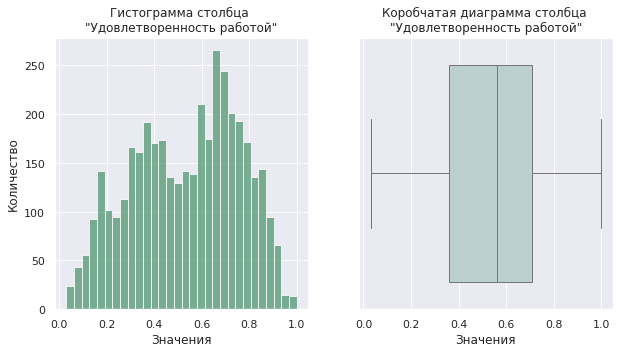

In [75]:
plot_graphics(train_job_satisfaction_rate, 'job_satisfaction_rate', col_alias='\n"Удовлетворенность работой"')

- Видна мультимодальность распределения

In [76]:
train_job_satisfaction_rate[['job_satisfaction_rate']].describe()

job_satisfaction_rate
count            4000.000000
mean                0.533995
std                 0.225327
min                 0.030000
25%                 0.360000
50%                 0.560000
75%                 0.710000
max                 1.000000

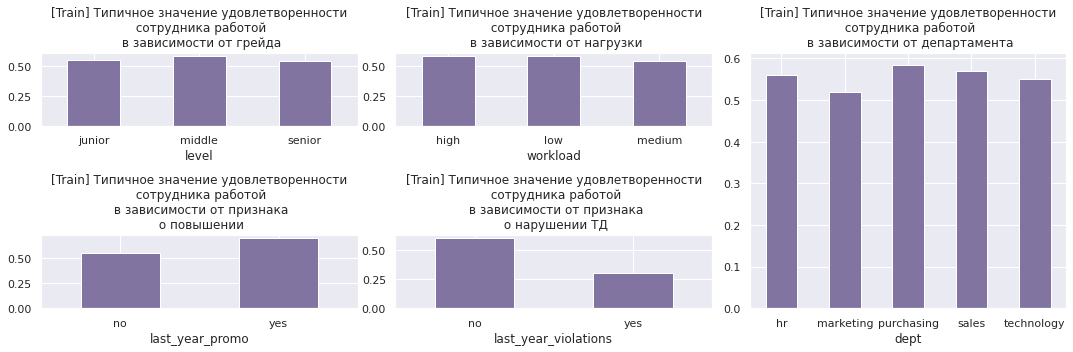

In [77]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])  
ax2 = fig.add_subplot(gs[0, 1])  
ax3 = fig.add_subplot(gs[1, 0])  
ax4 = fig.add_subplot(gs[1, 1])  
ax5 = fig.add_subplot(gs[:, 2])  

axes = [ax1, ax2, ax3, ax4, ax5]
templ = '[Train] Типичное значение удовлетворенности\n сотрудника работой'
params = zip(axes, 
             ['level', 'workload', 'last_year_promo', 'last_year_violations', 'dept'], 
             [templ + '\n в зависимости от грейда', 
              templ + '\n в зависимости от нагрузки',   
              templ + '\n в зависимости от признака\n о повышении',                     
              templ + '\n в зависимости от признака\n о нарушении ТД',                     
              templ + '\n в зависимости от департамента',                     
             ])

for p in params:
    (train_job_satisfaction_rate.pivot_table(
        index=p[1], 
        values='job_satisfaction_rate', 
        aggfunc='median')[['job_satisfaction_rate']]
    .plot(kind='bar', ax=p[0], legend=False, title=p[2], color=DEFAULT_COLOR))
    
    p[0].tick_params(rotation=0)

plt.tight_layout();

- Миддлы в среднем более удовлетворены работой
- Сотрудники с малой и большой нагрузкой более удовлетворены работой чем сотрудники со средней занятостью
- Сотрудники, получившие повышение, в среднем более удовлетворены работой
- Сотрудники, которые НЕ нарушали ТД, в среднем более удовлетворены работой
- Больше всего нравится работать сотрудникам отдела закупок, а меньше всего нравится работать сотрудникам отдела маркетинга

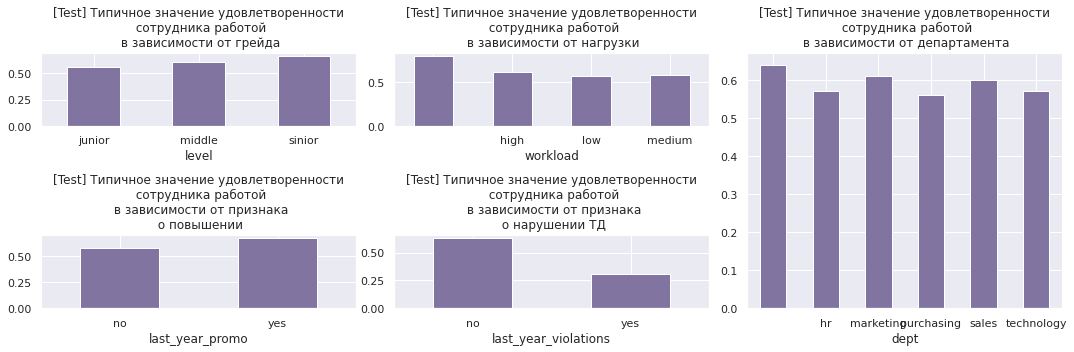

In [78]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])  
ax2 = fig.add_subplot(gs[0, 1])  
ax3 = fig.add_subplot(gs[1, 0])  
ax4 = fig.add_subplot(gs[1, 1])  
ax5 = fig.add_subplot(gs[:, 2])  

axes = [ax1, ax2, ax3, ax4, ax5]
templ = '[Test] Типичное значение удовлетворенности\n сотрудника работой'
params = zip(axes, 
             ['level', 'workload', 'last_year_promo', 'last_year_violations', 'dept'], 
             [templ + '\n в зависимости от грейда', 
              templ + '\n в зависимости от нагрузки',   
              templ + '\n в зависимости от признака\n о повышении',                     
              templ + '\n в зависимости от признака\n о нарушении ТД',                     
              templ + '\n в зависимости от департамента',                     
             ])

for p in params:
    (test_features.merge(test_target, how='inner', on='id').pivot_table(
        index=p[1], 
        values='job_satisfaction_rate', 
        aggfunc='median')[['job_satisfaction_rate']]
    .plot(kind='bar', ax=p[0], legend=False, title=p[2], color=DEFAULT_COLOR))
    
    p[0].tick_params(rotation=0)

plt.tight_layout();

Для тестовой выборки:
    
- Синьоры в среднем более удовлетворены работой
- Сотрудники с большой нагрузкой более удовлетворены работой
- Сотрудники, получившие повышение, в среднем более удовлетворены работой
- Сотрудники, которые НЕ нарушали ТД, в среднем более удовлетворены работой
- Больше всего нравится работать сотрудникам отдела маркетинга, а меньше всего нравится работать сотрудникам отдела закупок. Но в общем и целом зависимость типичного значения от отдела весьма низкая

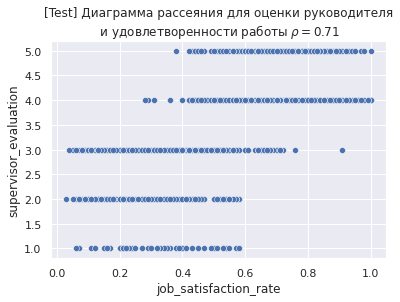

In [79]:
rho = (test_features.merge(test_target, how='inner', on='id')
       .supervisor_evaluation
       .corr(test_features.merge(test_target, how='inner', on='id')
             .job_satisfaction_rate)
       .round(2))

(sns.scatterplot(
    data=test_features.merge(test_target, how='inner', on='id'), 
    y='supervisor_evaluation', 
    x='job_satisfaction_rate')
 .set_title(f'[Test] Диаграмма рассеяния для оценки руководителя\n и удовлетворенности работы $\\rho={rho}$'));

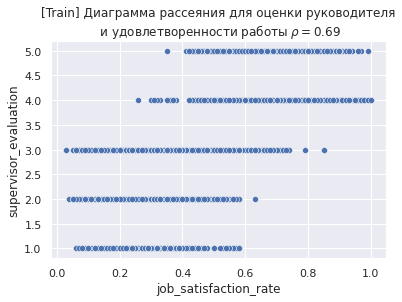

In [80]:
rho = (train_job_satisfaction_rate
       .supervisor_evaluation
       .corr(train_job_satisfaction_rate
             .job_satisfaction_rate)
       .round(2))

(sns.scatterplot(
    data=train_job_satisfaction_rate, 
    y='supervisor_evaluation', 
    x='job_satisfaction_rate')
 .set_title(f'[Train] Диаграмма рассеяния для оценки руководителя\n и удовлетворенности работы $\\rho={rho}$'));

- Видна сильная связь между удовлетворенностью работой и оценкой руководителя


1. **Распределение сотрудников по отделам**:
   - Больше всего сотрудников в отделе продаж (38%), меньше всего — в HR.
   - Распределение по департаментам в тренировочной и тестовой выборках схоже.

2. **Грейды и стаж работы**:
   - Больше всего джунов в обеих выборках, меньше всего — опытных разработчиков.
   - Сотрудники с опытом работы от 6 лет и более повышают свой грейд: джунов в этой группе нет.
   - Повышение наиболее вероятно после 4 лет работы в компании.
   - Синьоры в основном работают в компании не менее 2–3 лет, что указывает на внутренний карьерный рост.

3. **Нагрузка сотрудников**:
   - Больше половины сотрудников имеют среднюю нагрузку.
   - Высокая нагрузка характерна для синьоров, низкая — для джунов.
   - Сотрудники с высокой нагрузкой получают наибольшую зарплату.

4. **Повышения**:
   - Наибольший процент повышений у опытных сотрудников, но по количеству лидируют миддлы.
   - В отделе закупок наибольший процент повышений, в отделе продаж — наибольшее количество.
   - Повышения чаще получают сотрудники с высокой и средней нагрузкой.
   - Сотрудники с повышением в среднем работают около 5 лет и чаще получают оценку руководителя 4 (удовлетворительно с потенциалом роста).

5. **Нарушения трудового договора (ТД)**:
   - По проценту нарушений лидирует отдел маркетинга, по количеству — отдел продаж.
   - В тестовой выборке по проценту нарушений лидирует отдел технологий.
   - Нарушения чаще встречаются среди джунов (по количеству) и опытных специалистов (по проценту).
   - Сотрудники с низкой нагрузкой чаще нарушают ТД.

6. **Зарплаты**:
   - Синьоры получают самые высокие зарплаты, джуны — до 50к.
   - Зарплаты сотрудников с высокой нагрузкой смещены в сторону больших значений.
   - Сотрудники с повышением получают в среднем больше, чем те, кто не был повышен.

7. **Удовлетворенность работой**:
   - Миддлы и синьоры в среднем более удовлетворены работой.
   - Сотрудники с малой и высокой нагрузкой более удовлетворены, чем те, у кого средняя нагрузка.
   - Сотрудники с повышением и те, кто не нарушал ТД, более удовлетворены работой.
   - В тренировочной выборке больше всего довольны сотрудники отдела закупок, меньше всего — отдела маркетинга.
   - В тестовой выборке ситуация обратная: больше всего довольны сотрудники отдела маркетинга, меньше всего — отдела закупок.

8. **Общие тенденции**:
   - Длительность работы в компании влияет на нагрузку, зарплату и вероятность повышения.
   - Сотрудники с высокой нагрузкой и опытом работы более 4 лет чаще получают повышение и высокую зарплату.
   - Удовлетворенность работой выше у сотрудников с повышением, высокой нагрузкой и без нарушений ТД.


 Возможные рекомендации

1. **Для HR и руководства**:
   - Уделить внимание удержанию джунов, так как их количество уменьшается с увеличением стажа.
   - Разработать программы поддержки для сотрудников со средней нагрузкой, так как они менее удовлетворены работой.
   - Усилить контроль за соблюдением ТД в отделах маркетинга и продаж.

2. **Для развития сотрудников**:
   - Создать четкие критерии повышения грейдов, особенно для миддлов и джунов.
   - Поддерживать сотрудников с высокой нагрузкой, чтобы избежать выгорания.

3. **Для повышения удовлетворенности**:
   - Провести анализ причин низкой удовлетворенности в отделах маркетинга и закупок.
   - Поощрять сотрудников с высокой нагрузкой и тех, кто не нарушает ТД, чтобы сохранить их мотивацию.

4. **Для планирования зарплат**:
   - Учитывать нагрузку и стаж работы при определении зарплат, чтобы сохранить баланс между оплатой труда и удовлетворенностью сотрудников.

## Корреляционный анализ

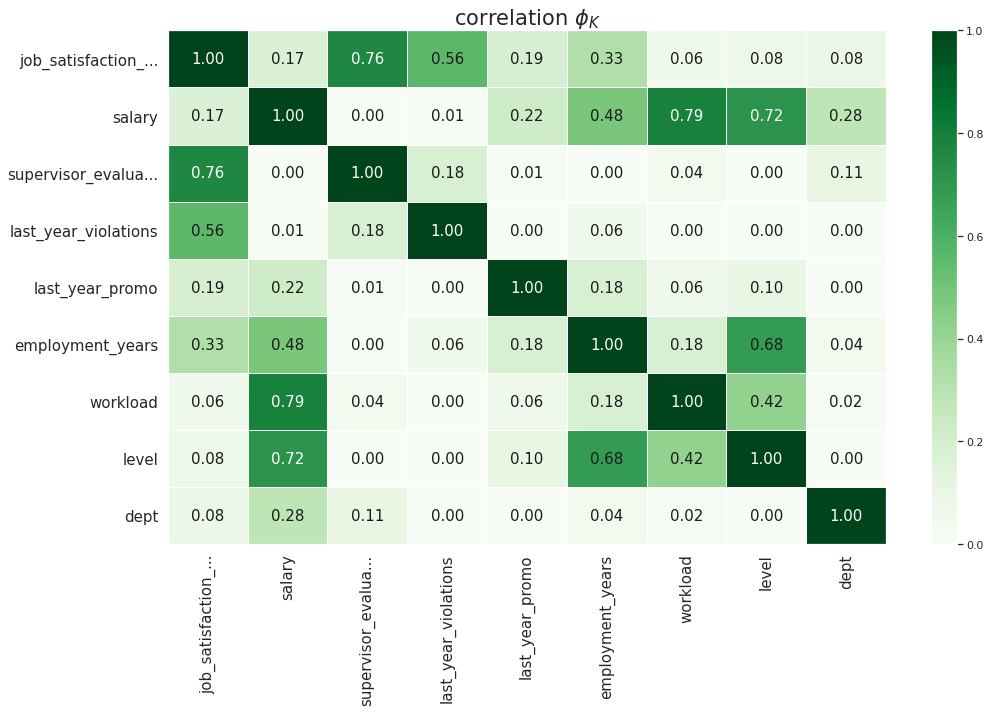

In [81]:
phik_overview = train_job_satisfaction_rate.drop(columns='id').phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
) 

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Верно! Анализировать корр.связь **id** с другими признаками смысла нет!
</div>

In [82]:
phik_overview[['job_satisfaction_rate']].sort_values(by='job_satisfaction_rate')

job_satisfaction_rate
workload                            0.056128
level                               0.080620
dept                                0.082086
salary                              0.165830
last_year_promo                     0.190803
employment_years                    0.325603
last_year_violations                0.560348
supervisor_evaluation               0.764364
job_satisfaction_rate               1.000000

In [83]:
categories = list(train_job_satisfaction_rate.select_dtypes(include='object').columns)
num_cols = list(train_job_satisfaction_rate.drop(columns='id').select_dtypes(exclude='object').columns)

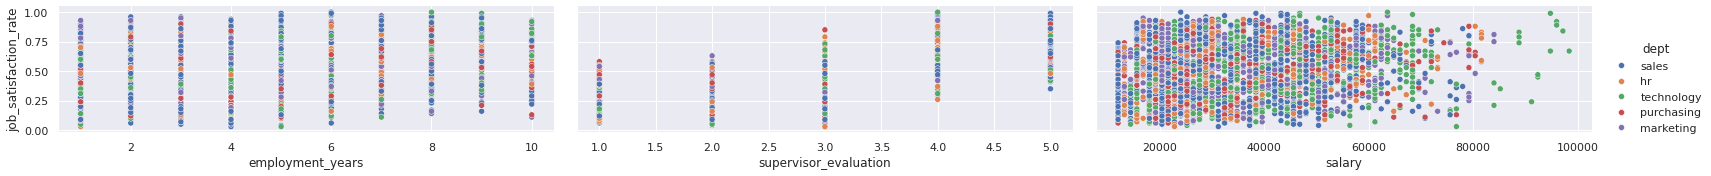

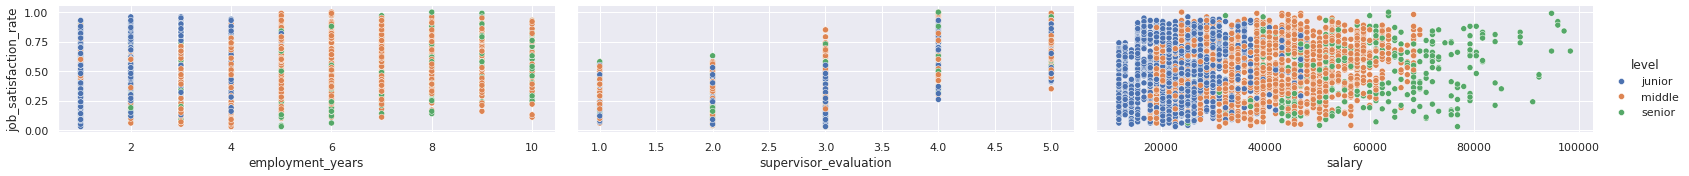

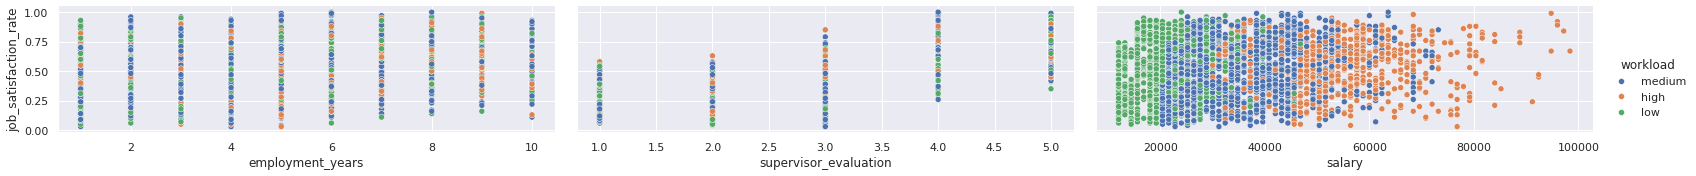

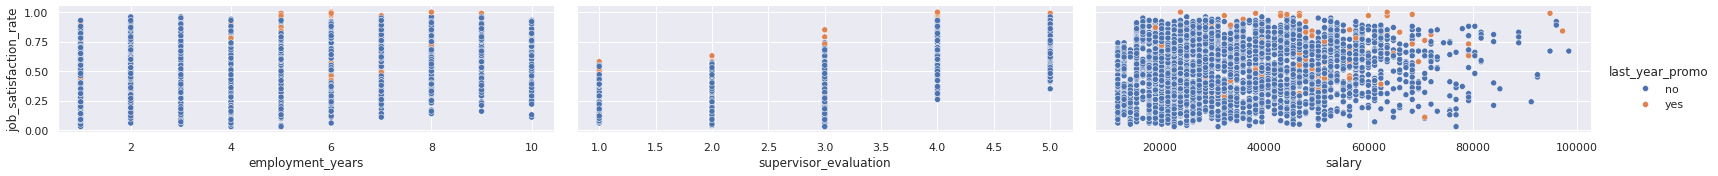

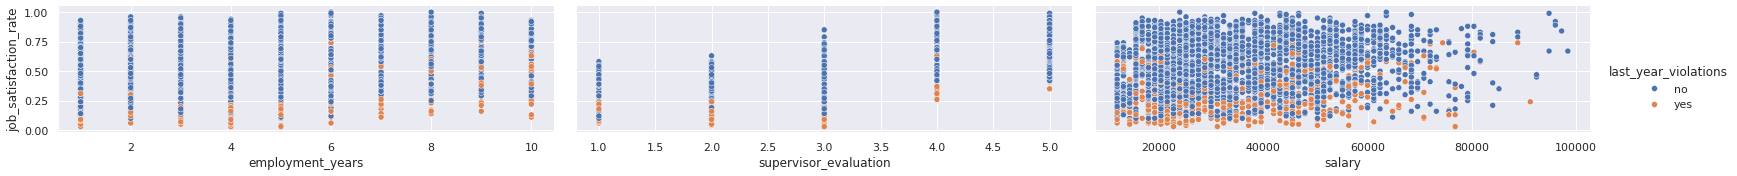

In [84]:
for cat in categories:
    g = sns.PairGrid(data=train_job_satisfaction_rate.dropna().drop(columns='id'),
                     hue=cat,
                     x_vars=num_cols[:-1],
                     y_vars='job_satisfaction_rate', aspect=3)
    g.map(sns.scatterplot)
    for idx, ax in enumerate(g.axes.flat):
        ax.set_xlabel(num_cols[idx])
    g.add_legend()

- Среди синьоров с большой зарплатой уровень удовлетворенности в основном больше 0.25
- Как было выяснено в EDA и видно из диаграмм рассеяния сотрудники с повышением более довольны работой (тяготеют к значениям таргета повыше). И видна обратная тенденция в отношении нарушивших ТД: нарушители менее довольны работой

In [85]:
temp = (train_job_satisfaction_rate
        .drop(columns=['id'], errors='ignore'))



market_file_numerical_columns = (temp
                                 .select_dtypes(['float64', 'int', 'int64'])
                                 .columns)

df = pd.DataFrame(temp[market_file_numerical_columns], 
                  columns=market_file_numerical_columns)

X = add_constant(df)

vif = pd.DataFrame(
    {
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    }
)
vif

Variable        VIF
0                  const  18.543427
1       employment_years   1.358397
2  supervisor_evaluation   2.001941
3                 salary   1.275237
4  job_satisfaction_rate   2.093636

- Наиболее сильная корреляция целевой переменной наблюдается с такими признаками, как оценка руководителя, нарушения трудовой дисциплины за последний год и стаж работы.

- Также выделяется значимая взаимосвязь между уровнем зарплаты и трудовой нагрузкой, уровнем зарплаты и грейдом, а также между грейдом и продолжительностью работы в компании.

- Среди сотрудников уровня senior с высоким уровнем зарплаты уровень удовлетворенности работой в основном превышает 0.25.

- Как показал анализ данных (EDA) и видно на диаграммах рассеяния, сотрудники, получившие повышение, в среднем более довольны работой (их значения целевой переменной стремятся к более высоким показателям). В то же время наблюдается обратная тенденция среди нарушителей трудовой дисциплины: такие сотрудники менее удовлетворены работой.

- Признаки мультиколлинеарности отсутствуют.

## Обучение модели 

In [91]:
train = train_job_satisfaction_rate.drop(columns='id').drop_duplicates()

In [92]:
X_train = train.drop(columns=['job_satisfaction_rate', 'id'], errors='ignore')
y_train = train.job_satisfaction_rate

In [93]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = X_train.select_dtypes(['float64', 'int', 'int64']).columns

In [148]:
num_columns

Index(['employment_years', 'supervisor_evaluation', 'salary'], dtype='object')

In [95]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

In [96]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],                     
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [155]:
def preprocess_data(df):
    df = df.copy()
    
    if 'level' in df.columns:
        df['level'] = df['level'].replace('sinior', 'senior')

    for col in ['workload', 'dept']:
        if col in df.columns:
            df[col] = df[col].replace(' ', np.nan)
    
    return df

preprocessing_step = FunctionTransformer(preprocess_data)

In [156]:
data_preprocessor = ColumnTransformer(
    [
     ('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns),  
    ], 
    remainder='drop'
)

pipe_final = Pipeline([
    ('preprocess_func', preprocessing_step),
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor())
])

In [157]:
def smape(y_true, y_pred):    
    return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))


smape_score = make_scorer(
    smape,
    greater_is_better=False
)

In [158]:
param_grid_tree = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 12, 1),
        'models__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        'models__max_features': range(2, 12, 1),
        'models__min_samples_leaf': range(1, 10, 1),
        'models__min_samples_split': range(2, 10, 1),
        'preprocessor__num': [StandardScaler()]  
    }
]

regressor_tree = RandomizedSearchCV(
    pipe_final, 
    param_grid_tree, 
    cv=5,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=100,
    error_score='raise',
)
warnings.filterwarnings("ignore", category=UserWarning)
regressor_tree.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocess_func',
                                              FunctionTransformer(func=<function preprocess_data at 0x7fbd987038b0>)),
                                             ('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              s...
                                         'models__criterion': ['squared_error',
                                                               'friedman_mse',
                                                               'absolute_error',
                                                               'poisson'],
                                         'models__max_depth': range(2, 12),
                                         'models__max_features': range(2, 12),
                                         'models__min_samples_leaf': range(1, 10),
                                         'models__min_samples_split': range(2, 10),
                                         'preprocessor__num': [StandardScaler()]}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [159]:
param_grid_forest = [
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)],
        'models__max_depth': range(2, 12, 1),
        'models__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        'models__max_features': range(2, 12, 1),
        'models__min_samples_leaf': range(1, 10, 1),
        'models__min_samples_split': range(2, 10, 1),
        'preprocessor__num': [StandardScaler()]  
    }
]

regressor_forest = RandomizedSearchCV(
    pipe_final, 
    param_grid_forest, 
    cv=5,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    # n_iter=100,
    error_score='raise',
)
warnings.filterwarnings("ignore", category=UserWarning)
regressor_forest.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocess_func',
                                              FunctionTransformer(func=<function preprocess_data at 0x7fbd987038b0>)),
                                             ('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              s...
                                         'models__criterion': ['squared_error',
                                                               'friedman_mse',
                                                               'absolute_error',
                                                               'poisson'],
                                         'models__max_depth': range(2, 12),
                                         'models__max_features': range(2, 12),
                                         'models__min_samples_leaf': range(1, 10),
                                         'models__min_samples_split': range(2, 10),
                                         'preprocessor__num': [StandardScaler()]}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [162]:
param_grid_lr = [
    {
        'models': [Ridge()],        
        'models__alpha': np.arange(0.01, 1, 0.01),
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    }
]

linear_reg_cv = RandomizedSearchCV(
    pipe_final, 
    param_grid_lr, 
    cv=5,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1,
#     n_iter=100,
    error_score='raise',
)

warnings.filterwarnings("ignore", category=UserWarning)
linear_reg_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocess_func',
                                              FunctionTransformer(func=<function preprocess_data at 0x7fbd987038b0>)),
                                             ('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              s...
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                                         'preprocessor__num': [StandardScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [163]:
test = test_features.merge(test_target, on='id', how='inner')
X_test = test.drop(columns=['id', 'job_satisfaction_rate'], errors='ignore')
y_test = test.job_satisfaction_rate

In [164]:
test_features.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [165]:
pd.DataFrame(
    [
        {
            'train SMAPE': (pipe.best_score_ * (-1))
            .round(2),
            
            'test SMAPE': smape(pipe
                                .best_estimator_
                                .predict(X_test), y_test)
            .round(2),
            
            'test R^2': round(r2_score(y_test, 
                                       pipe
                                       .best_estimator_
                                       .predict(X_test)), 2),
            
            'test RMSE': round(root_mean_squared_error(y_test, 
                                                       pipe
                                                       .best_estimator_
                                                       .predict(X_test)), 2),  
            
            'test MAE': round(mean_absolute_error(y_test, 
                                                       pipe
                                                       .best_estimator_
                                                       .predict(X_test)), 2),  
        }
        
        for pipe in [linear_reg_cv, regressor_tree, regressor_forest]
    ],
    index=['Ридж-регрессия', 'Дерево решений', 'Случайный лес']
)

train SMAPE  test SMAPE  test R^2  test RMSE  test MAE
Ридж-регрессия        25.00       23.56      0.68       0.12      0.10
Дерево решений        15.97       14.31      0.87       0.08      0.06
Случайный лес         14.75       13.43      0.89       0.07      0.06

Итак, на CV лучше всего себя показала модель случайного леса. Кроме того, на тестовой выборке она показывает значение целевой метрики SMAPE = 13.43, что удовлетворяет требованию задачи. Исследуем распределение остатков для данной модели

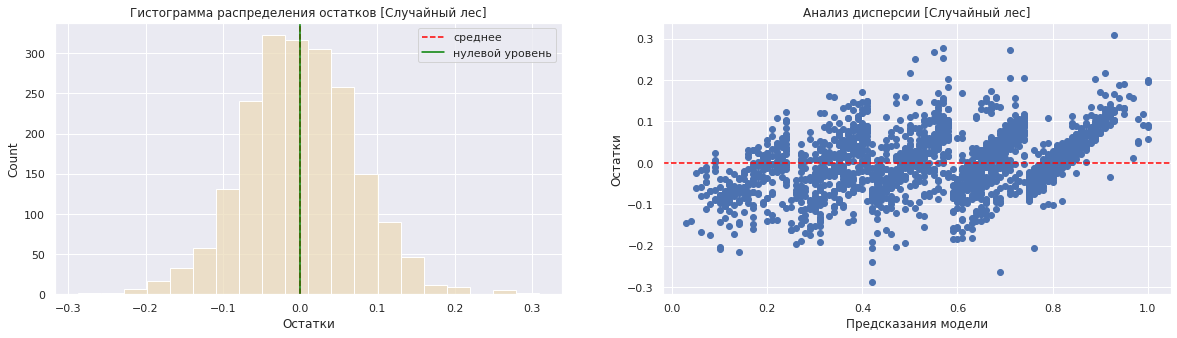

In [166]:
analyze_residuals(y_test - regressor_forest.best_estimator_.predict(X_test), y_test, 'Случайный лес')

- Распределение совпадает с нулевым уровнем, выглядит достаточно симметричным. Модель довольно точно определяет значения
- Распределение дисперсии обладает некоторой дискретностью, в области низких оценок модель до 0.2 модель практически всегда завышает оценку, в области высоких оценок модель наоборот занижает оценку. В области от 0.2 до 0.8 распределение относительно равномерное

In [172]:
best_model_regression = regressor_forest.best_estimator_.named_steps['models']
preprocess_func_regression = regressor_forest.best_estimator_.named_steps['preprocess_func']
preprocessor_regression = regressor_forest.best_estimator_.named_steps['preprocessor']
features_regression = preprocessor_regression.get_feature_names_out()

In [173]:
X = pd.DataFrame(data=preprocessor_regression.transform(preprocess_func_regression.transform(X_test)), columns=features_regression)

## Анализ важности признаков

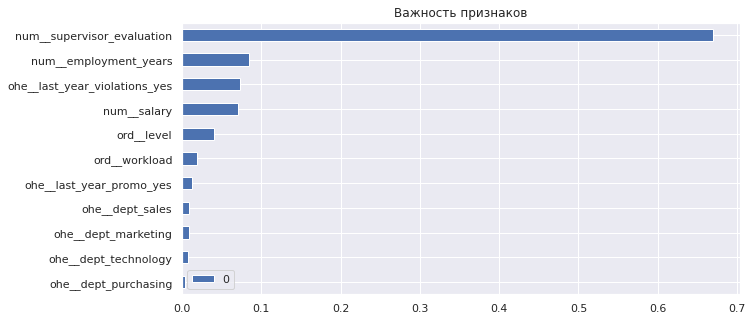

In [174]:
pd.DataFrame(best_model_regression.feature_importances_, index=features_regression).sort_values(0).plot(kind='barh', figsize=(10,5), title='Важность признаков');

- Случайный лес определил для себя главным фактором именно оценку руководителя
- Также длительность работы, нарушение ТД, зарплата и грейд сильно влияют на предсказания леса
- Меньше всего влияют на предсказания признаки по департаментам

In [175]:
explainer = shap.Explainer(best_model_regression)
shap_values = explainer(X)

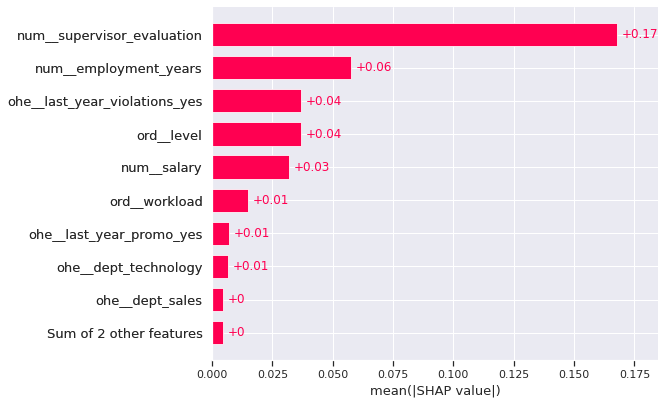

In [176]:
shap.plots.bar(shap_values) 

- SHAP анализ показывает похожий результат

# Задание №2

## Исследовательский анализ

### Датасет `train_quit.csv.csv`

#### Столбец `dept`

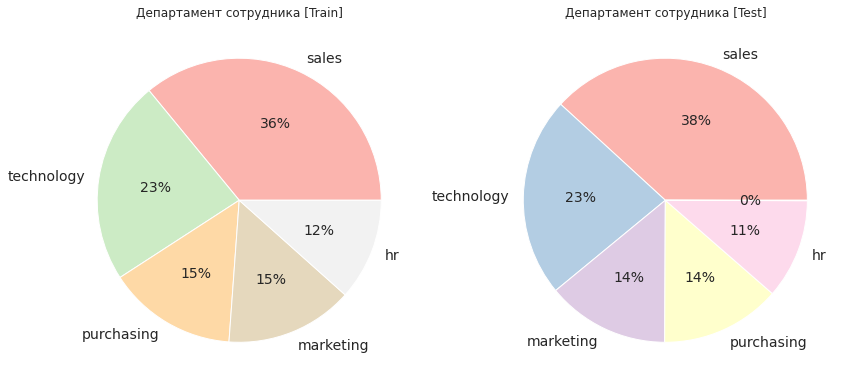

In [177]:
pieplot(train_quit, test_features, 'dept', 'Департамент сотрудника')

- Больше всего сотрудников, представленных в тренировочной выборке - сотрудники отдела продаж (36%)
- Меньше всего в отделе `hr`
- Распределения по департаментам в тренировочной и тестовой выборках приблизительно одинаковые

#### Столбец `level`

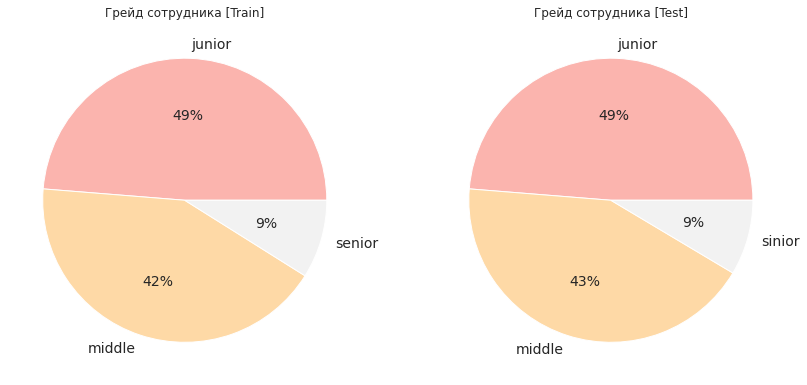

In [178]:
pieplot(train_quit, test_features, 'level', 'Грейд сотрудника')

- Больше всего джунов как в тренировочной, так и в тестовой выборках.
- Меньше всего опытных сотрудников

#### Столбец `workload`

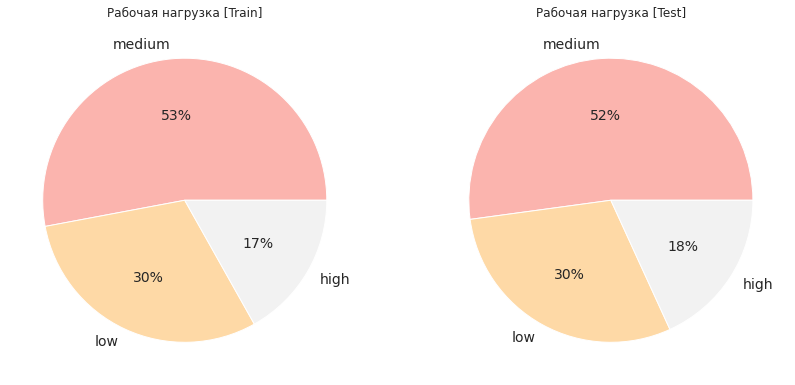

In [218]:
pieplot(train_quit, test_features.query('workload != " " and dept != " "'), 'workload', 'Рабочая нагрузка')

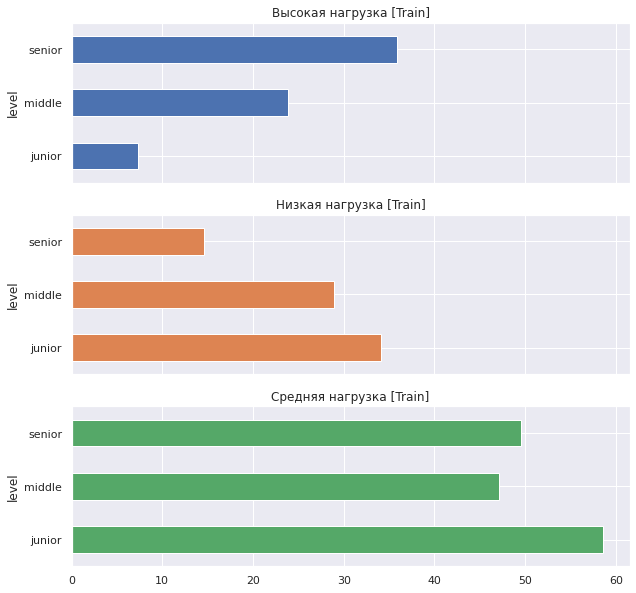

In [180]:
_piv = (train_quit.pivot_table(
     index='level', 
     columns='workload', 
     values='id', 
     aggfunc='count'))

((_piv.div(_piv.sum(axis=1), axis=0) * 100)
 .rename(
     columns={
         'high': 'Высокая нагрузка [Train]', 
         'low': 'Низкая нагрузка [Train]', 
         'medium': 'Cредняя нагрузка [Train]'
     })
 .plot(
     kind='barh', 
     subplots=True,
     figsize=(10, 10),
     legend=False))

plt.xticks(rotation=0);

- Среди сотрудников с высокой нагрузкой выделяется группа старших специалистов. В процентном соотношении эти сотрудники самые занятые. Наименьший процент сотрудников с высокой нагрузкой в группе джунов
- Среди сотрудников с низкой нагрузкой в процентном соотношении лидируют джуны, опытные специалисты в этой группе имеют наименьшую долю
- Средняя нагрузка характерна для всех групп специалистов. Однако в процентном соотношении лидируют джуны и синьоры

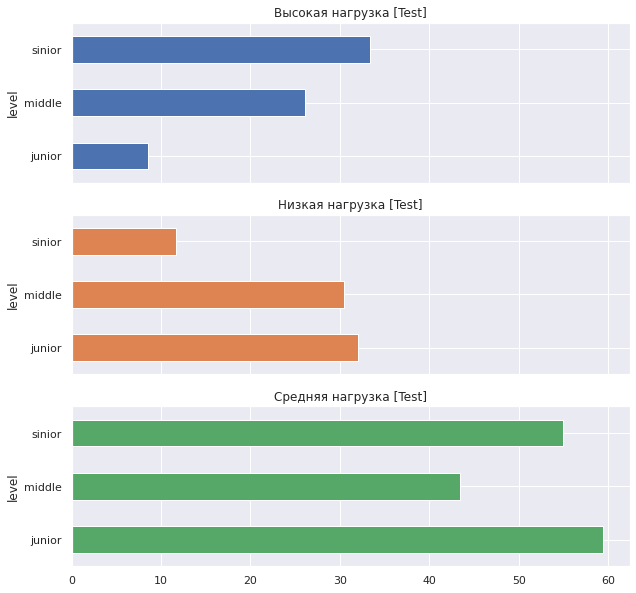

In [217]:
_piv = (test_features.query('workload != " " and dept != " "').pivot_table(
     index='level', 
     columns='workload', 
     values='id', 
     aggfunc='count'))

((_piv.div(_piv.sum(axis=1), axis=0) * 100)
 .rename(
     columns={
         'high': 'Высокая нагрузка [Test]', 
         'low': 'Низкая нагрузка [Test]', 
         'medium': 'Cредняя нагрузка [Test]'
     })
 .plot(
     kind='barh', 
     subplots=True,
     figsize=(10, 10),
     legend=False))

plt.xticks(rotation=0);

#### Столбец `last_year_promo`

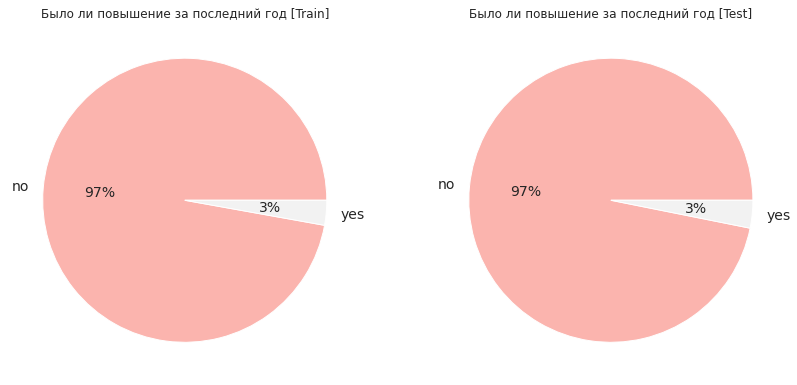

In [186]:
pieplot(train_quit, test_features, 'last_year_promo', 'Было ли повышение за последний год')

- Все таки нарушений договора существенно меньше

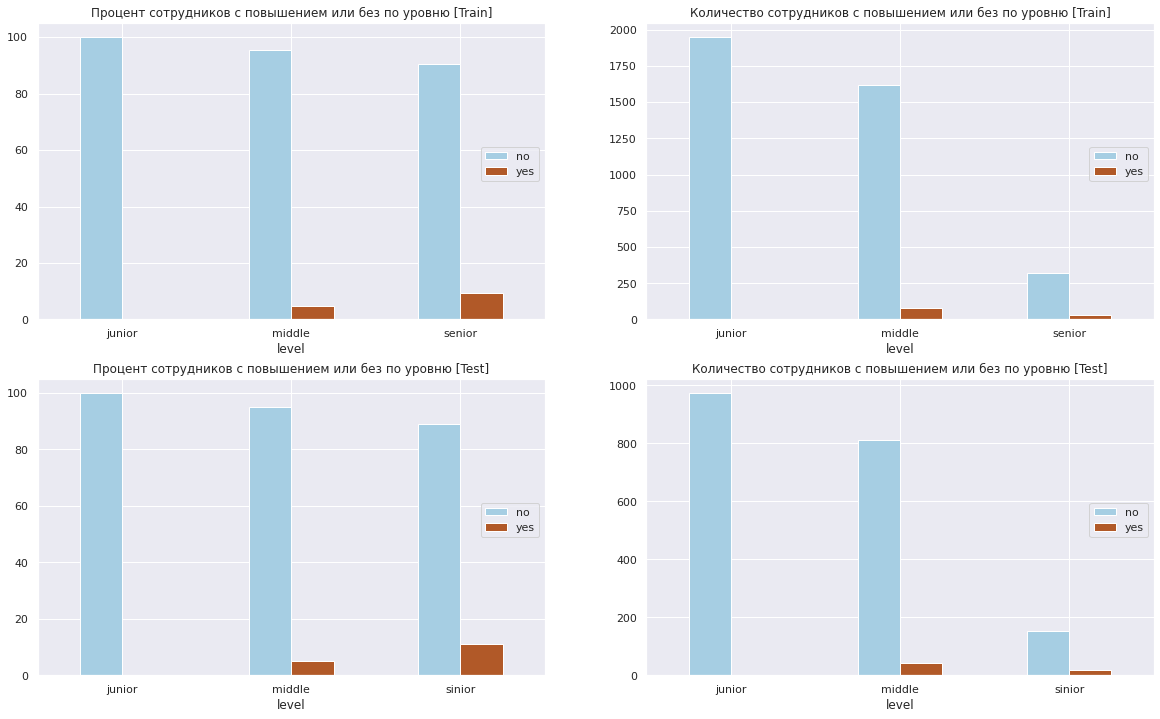

In [187]:
promo_violations_percentage(train_quit, 
                            test_features, 
                            title_part='сотрудников с повышением или без по уровню', 
                            index_var='level', 
                            col_var='last_year_promo')

- В процентном соотношении наибольший процент повышений наблюдается у самых опытных сотрудников. Хотя наиболее многочисленная группа по повышениям - миддлы
- Не наблюдаются повышения джунов за последний год
- В тестовой выборке все идентично

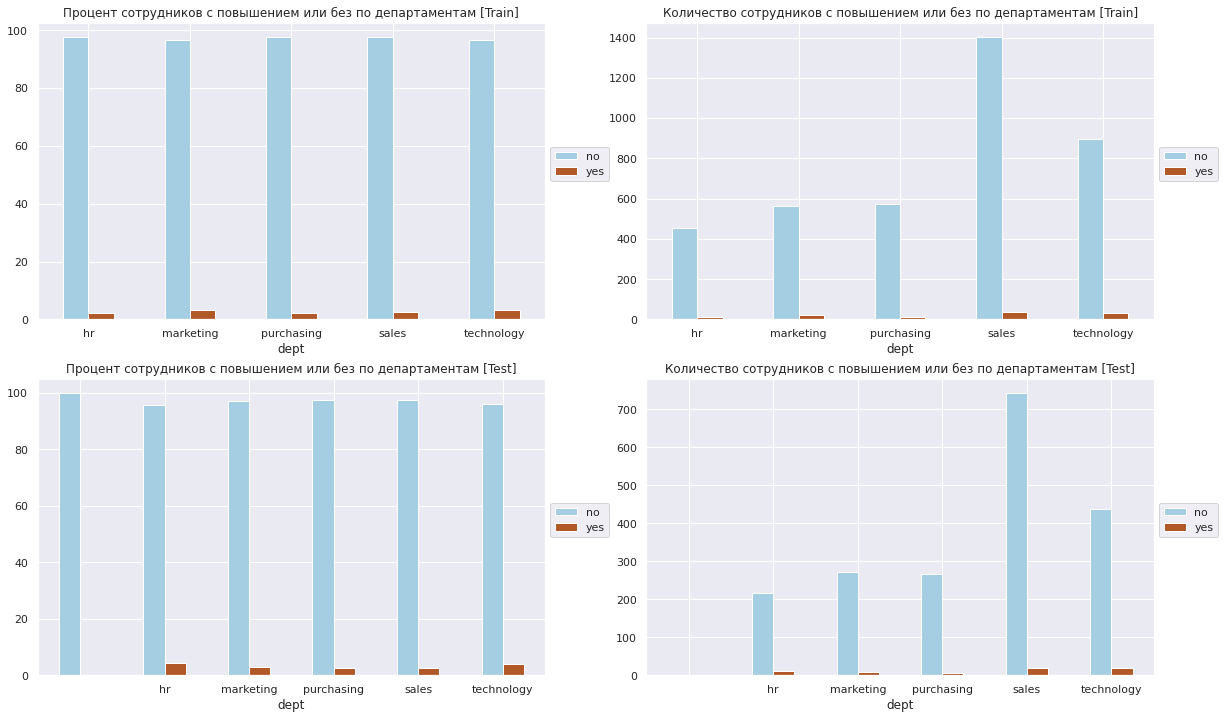

In [188]:
promo_violations_percentage(train_quit, 
                            test_features, 
                            title_part='сотрудников с повышением или без по департаментам', 
                            index_var='dept', 
                            col_var='last_year_promo')

- В процентном соотношении наибольший процент повышений наблюдается у сотрудников отдела маркетинга. Хотя наиболее многочисленная группа по повышениям - отдел продаж. 
- В тестовой выборке в процентом соотношении повышений больше всего в отделах `hr` и `technology`. Однако больше всего повышений представлено в отделе продаж

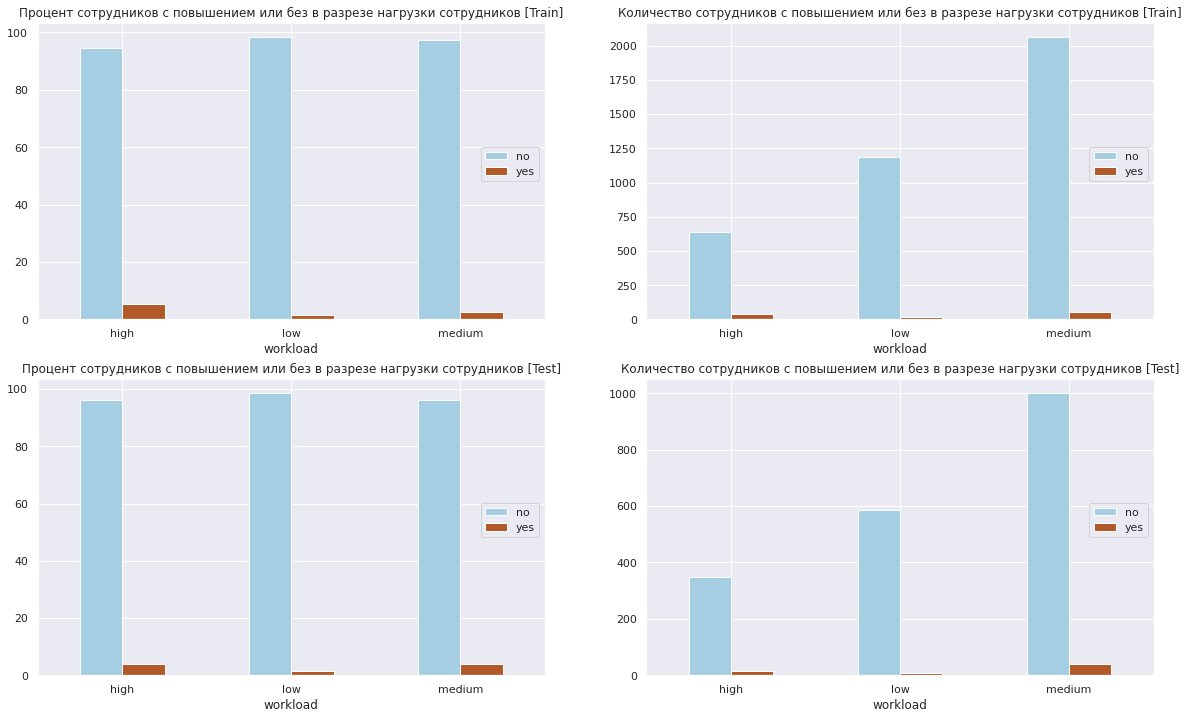

In [216]:
promo_violations_percentage(train_quit, 
                            test_features.query('workload != " " and dept != " "'), 
                            title_part='сотрудников с повышением или без в разрезе нагрузки сотрудников', 
                            index_var='workload', 
                            col_var='last_year_promo')

- По проценту повышений лидирует группа сотрудников с высокой рабочей нагрузкой. Наиболее многочисленная группа сотрудников с повышением имеет среднюю нагрузку 
- В тестовой выборке по проценту повышений лидирует группа сотрудников со средней и высокой рабочей нагрузкой. Наиболее многочисленная группа сотрудников с повышением также имеет среднюю нагрузку 

#### Столбец `last_year_violations`

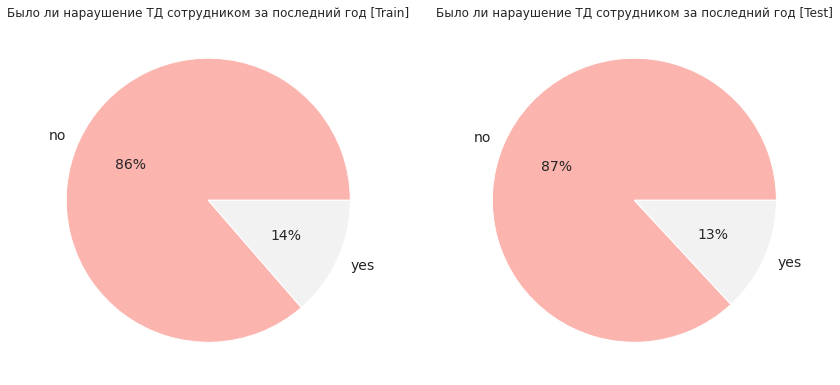

In [122]:
pieplot(train_quit, 
        test_features, 
        'last_year_violations', 
        'Было ли нараушение ТД сотрудником за последний год')

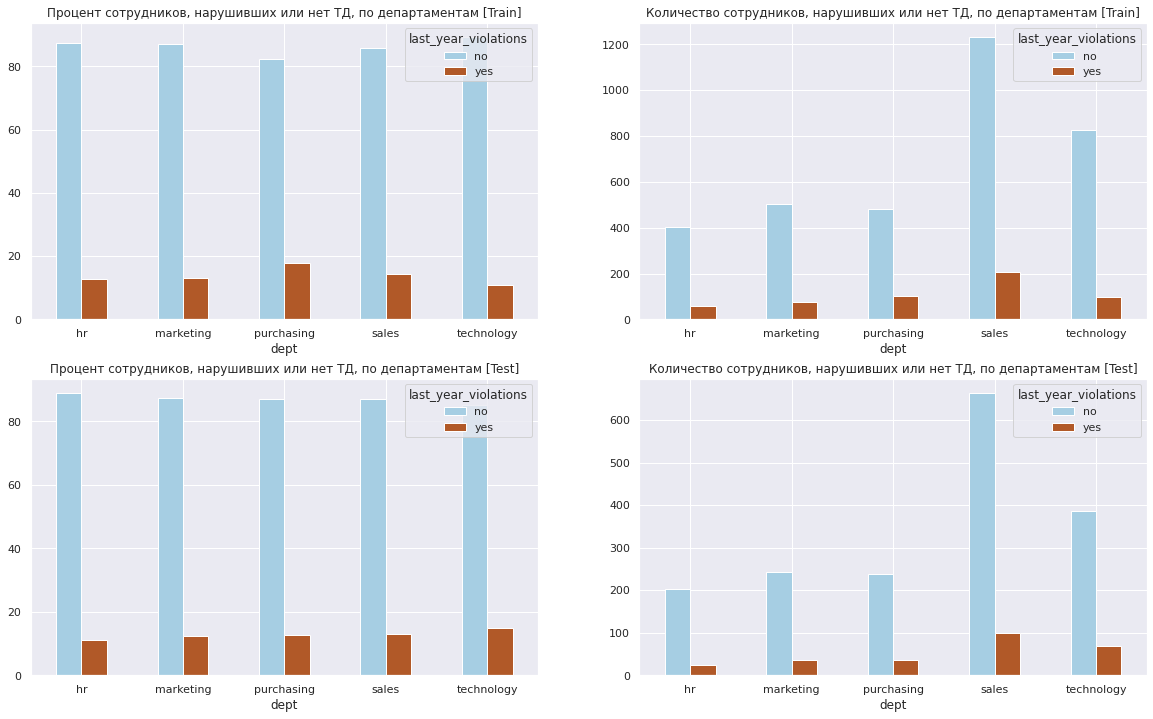

In [123]:
promo_violations_percentage(train_quit, 
                            test_features,
                            title_part='сотрудников, нарушивших или нет ТД, по департаментам', 
                            index_var='dept', 
                            col_var='last_year_violations')

- По проценту нарушений трудового договора лидирует отдел закупок, больше всего по количеству нарушивших ТД сотрудников в отделе прождаж
- В тестовой выборке ситуация иная по процентному соотношению: здесь лидирует отдел технологий

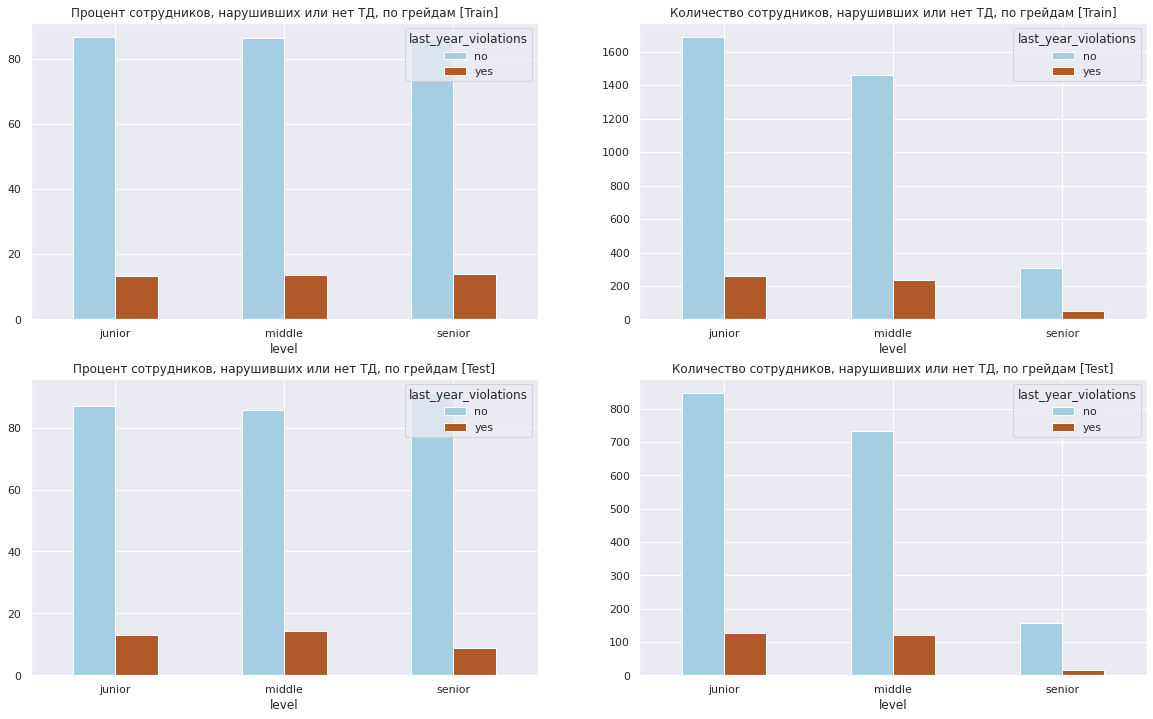

In [124]:
promo_violations_percentage(train_quit, 
                            test_features, 
                            title_part='сотрудников, нарушивших или нет ТД, по грейдам', 
                            index_var='level', 
                            col_var='last_year_violations')

- По проценту нарушений трудового договора по всем грейдам ситуация примерно одинаковая (85/15), хотя количественно в группе джунов нарушений больше всего
- В тестовой выборке ситуация иная по процентному соотношению: здесь по количеству нарушений лидирует группа миддлов

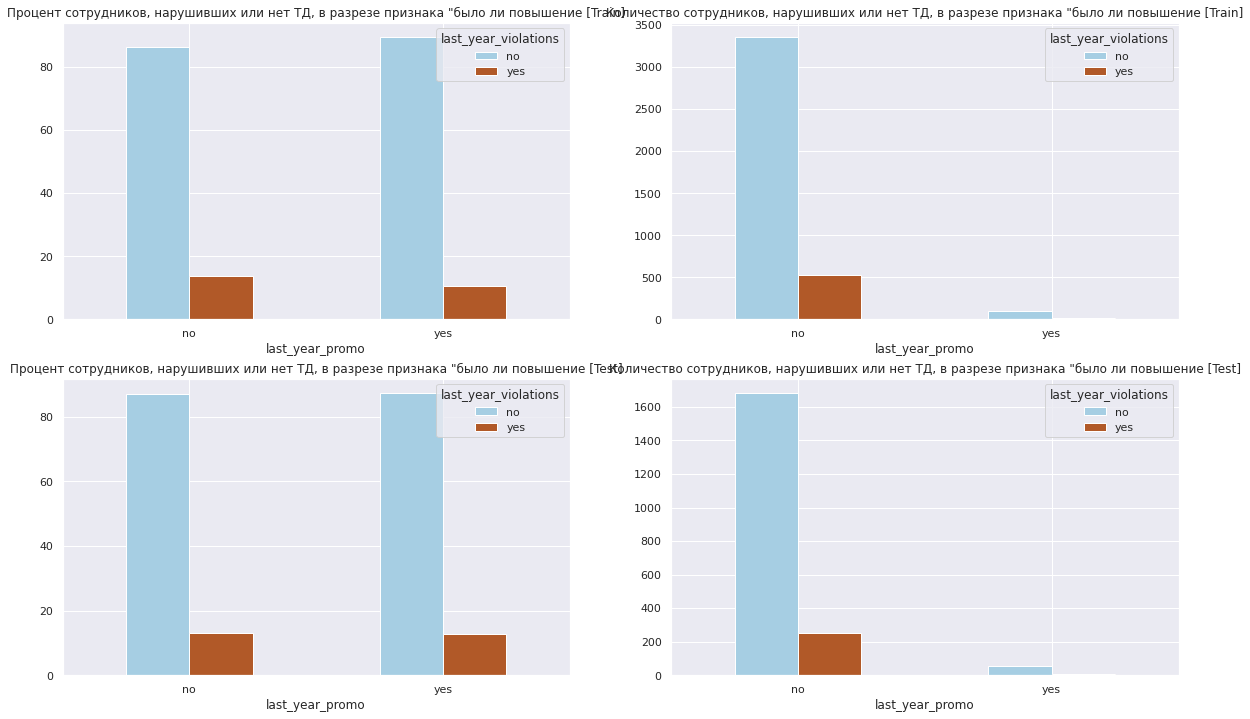

In [125]:
promo_violations_percentage(train_quit, 
                            test_features, 
                            title_part='сотрудников, нарушивших или нет ТД, в разрезе признака "было ли повышение',
                            index_var='last_year_promo', 
                            col_var='last_year_violations')

- По проценту нарушений трудового договора выделяется группа сотрудников, которые были повышены в прошлом году. Их порядка 10 процентов
- В тестовой выборке ситуация более сбалансированная в процентном соотношении (15/85)

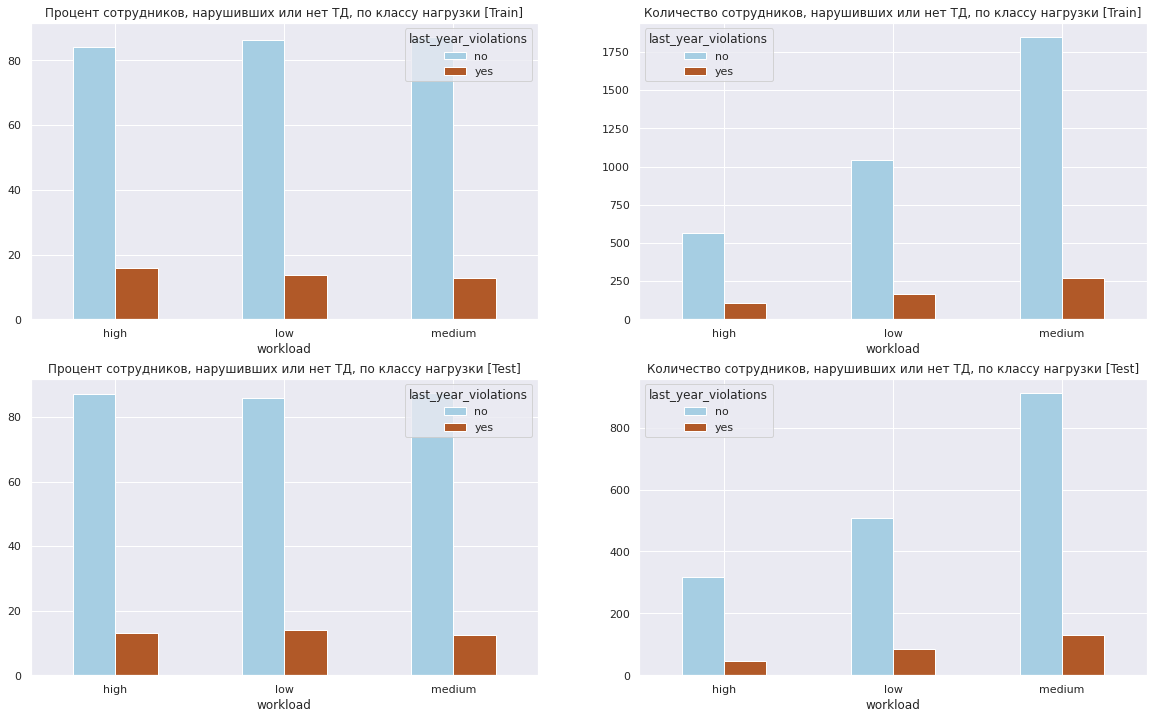

In [126]:
promo_violations_percentage(train_quit, 
                            test_features, 
                            title_part='сотрудников, нарушивших или нет ТД, по классу нагрузки',
                            index_var='workload', 
                            col_var='last_year_violations')

- По проценту нарушений трудового договора лидирует группа сотрудников с низкой нагрузкой, хотя самая многочисленная - группа сотрудников со средней нагрузкой
- В тестовой выборке ситуация иная: лидирует группа с низкой рабочей нагрузкой, однако количественно больше всего нарушений в группе сотрудников со средней нагрузкой

#### Столбец `employment_years`

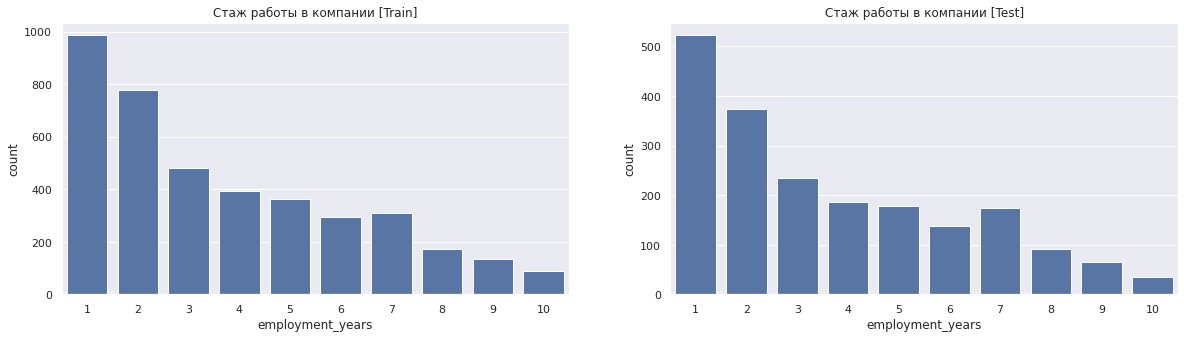

In [192]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.flatten()
sns.countplot(data=train_quit, 
              x='employment_years', 
              ax=ax[0]).set_title('Стаж работы в компании [Train]');

sns.countplot(data=test_features, 
              x='employment_years', 
              ax=ax[1]).set_title('Стаж работы в компании [Test]');

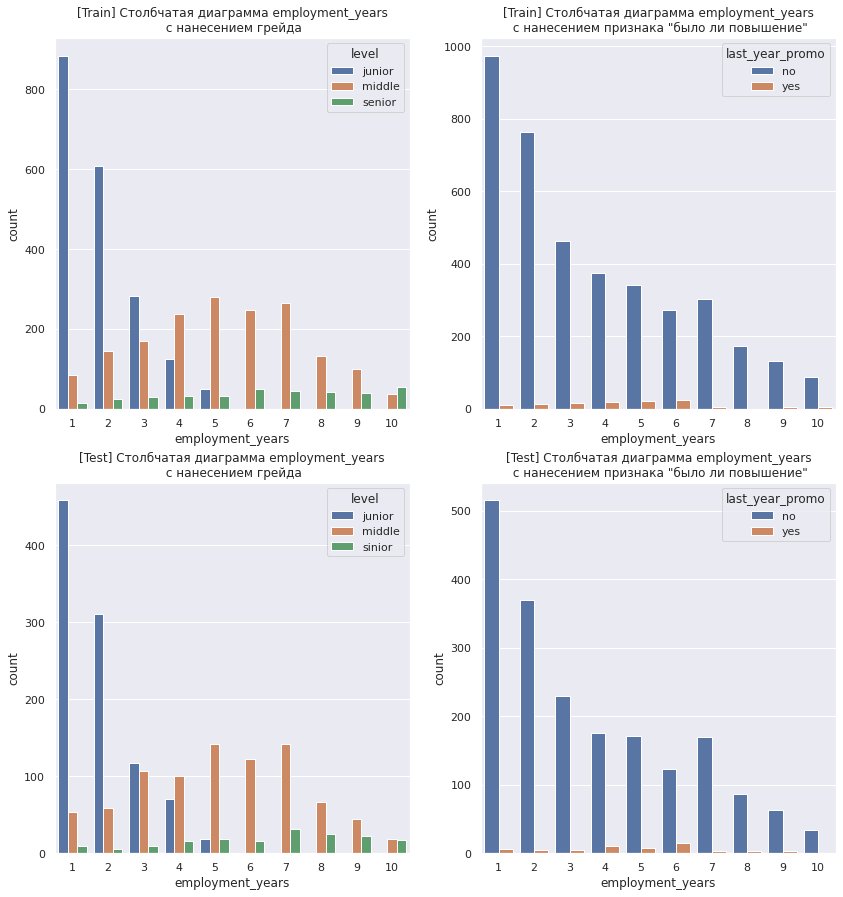

In [194]:
fig, ax = plt.subplots(2, 2, figsize=(14, 15))
ax = ax.flatten()

params = zip(ax[:2], 
             ['level', 'last_year_promo'], 
             ['[Train] Cтолбчатая диаграмма employment_years\n с нанесением грейда', 
              '[Train] Cтолбчатая диаграмма employment_years\n с нанесением признака "было ли повышение"'])

for p in params:
    g = sns.countplot(
    data=train_quit, 
    x='employment_years', 
    hue=p[1], ax=p[0])
    g.set_title(p[2]);
    
params = zip(ax[2:], 
             ['level', 'last_year_promo'], 
             ['[Test] Cтолбчатая диаграмма employment_years\n с нанесением грейда', 
              '[Test] Cтолбчатая диаграмма employment_years\n с нанесением признака "было ли повышение"'])

for p in params:
    g = sns.countplot(
    data=test_features, 
    x='employment_years', 
    hue=p[1], ax=p[0])
    g.set_title(p[2]);

- Отметим, что синьоры в основном работают не менее 2 лет. Возможно, какая-то часть этой группы сотрудников получила опыт, работая именно в этой компании
- В тестовой выборке явно видно, что большинство синьоров работает в компании не менее 3 лет
- Следует также отметить, что, при длительности 6 лет и более джунов нет. Также прослеживается тенденция: при увеличении количества лет работы джунов становиться все меньше и меньше. Если джунов становится меньше, это может быть связано с тем, что они либо повышают свой грейд, либо уходят из компании.
- Повышение становится наиболее вероятным при работы в компании не менее 4 лет.

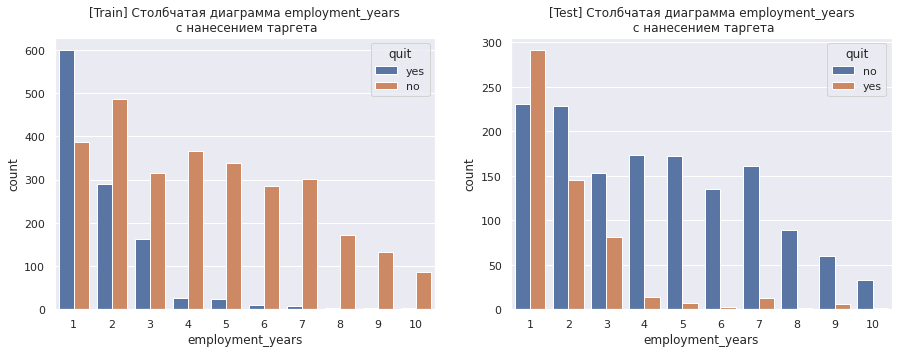

In [197]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.flatten()

g = sns.countplot(
    data=train_quit, 
    x='employment_years', 
    hue='quit', ax=ax[0]).set_title('[Train] Cтолбчатая диаграмма employment_years\n с нанесением таргета');

g = sns.countplot(
    data=test_features.merge(test_target_quit, how='inner', on='id'), 
    x='employment_years', 
    hue='quit', ax=ax[1]).set_title('[Test] Cтолбчатая диаграмма employment_years\n с нанесением таргета');

- В тренировочной выборке видно, что при длительности работы больше 6 лет вероятность увольнения очень низкая
- В тестовой выборке аналогичная ситуация

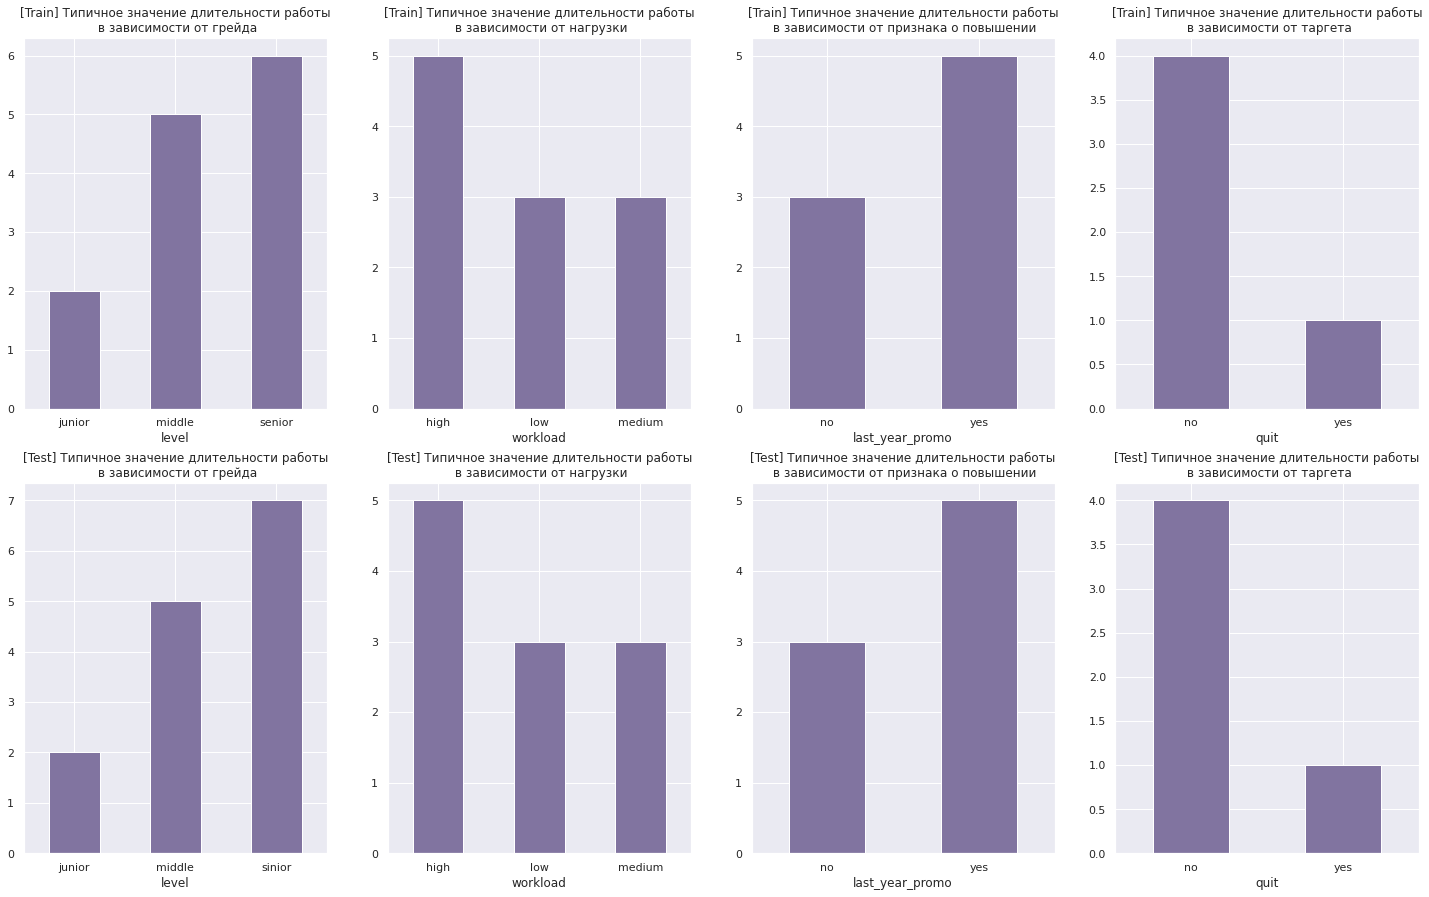

In [215]:
fig, ax = plt.subplots(2, 4, figsize=(25, 15))
ax = ax.flatten()
templ = '[Train] Типичное значение длительности работы'

params = zip(ax[:4], 
             ['level', 'workload', 'last_year_promo', 'quit'], 
             [templ + '\n в зависимости от грейда', 
              templ + '\n в зависимости от нагрузки',   
              templ + '\n в зависимости от признака о повышении',  
              templ + '\n в зависимости от таргета',                                   
              
             ])

for p in params:
    (train_quit.pivot_table(
        index=p[1], 
        values='employment_years', 
        aggfunc='median')[['employment_years']]
    .plot(kind='bar', ax=p[0], legend=False, title=p[2], color=DEFAULT_COLOR)
    )
    
    p[0].tick_params(rotation=0)
    
templ = '[Test] Типичное значение длительности работы'
    
params = zip(ax[4:], 
             ['level', 'workload', 'last_year_promo', 'quit'], 
             [ templ + '\n в зависимости от грейда', 
              templ + '\n в зависимости от нагрузки',   
              templ + '\n в зависимости от признака о повышении',
              templ + '\n в зависимости от таргета',                                   
             ])

for p in params:
    (test_features.query('workload != " " and dept != " "').merge(test_target_quit, how='inner', on='id').pivot_table(
        index=p[1], 
        values='employment_years', 
        aggfunc='median')[['employment_years']]
    .plot(kind='bar', ax=p[0], legend=False, title=p[2], color=DEFAULT_COLOR)
    )
    
    p[0].tick_params(rotation=0)

- Анализируя типичное значение длительности работы по грейдам, можно сделать вывод, что сотрудники скорее всего растут по грейду именно в этой компании.
- Длительность влияет на нагрузку сотрудника. Высокая нагрузка характерна для сотрудников, которые работают в компании в среднем 5 лет. Возможно, доверие руководства определяется опытом работы в этой компании, поэтому давно работающим сотрудникам доверяют больше дел
- Сотрудники с повышением в среднем работают около 5 лет
- Для тестовой выборки результаты идентичные (но синьоры в среднем работают 7 лет)

#### Столбец `supervisor_evaluation`

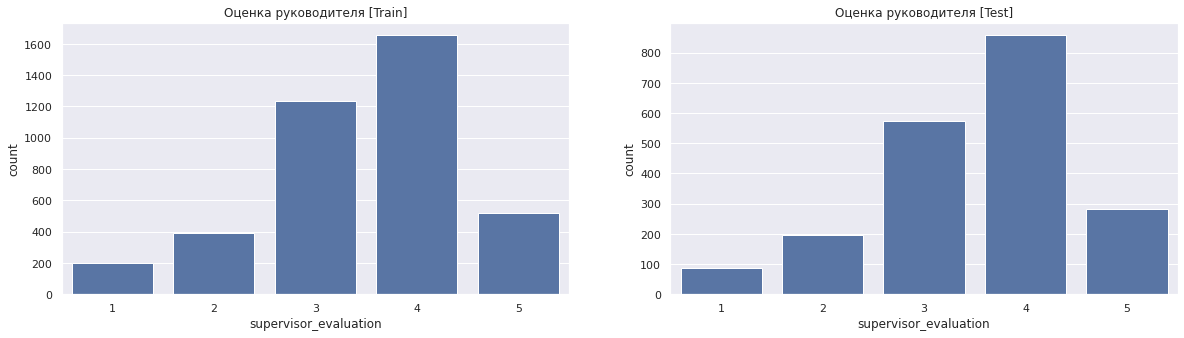

In [206]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.flatten()
sns.countplot(data=train_quit, 
              x='supervisor_evaluation', 
              ax=ax[0]).set_title('Оценка руководителя [Train]');

sns.countplot(data=test_features, 
              x='supervisor_evaluation', 
              ax=ax[1]).set_title('Оценка руководителя [Test]');

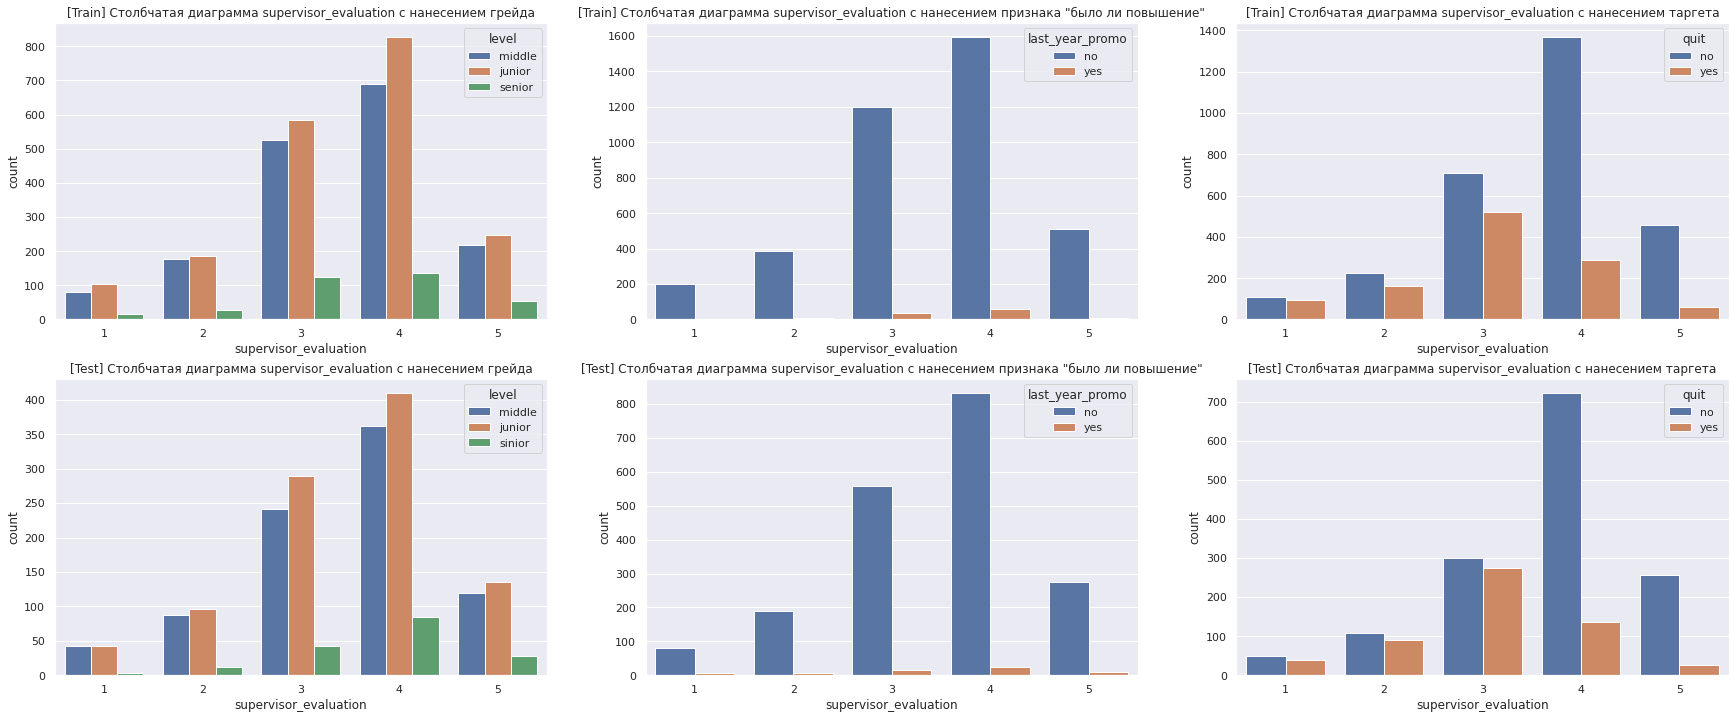

In [208]:
fig, ax = plt.subplots(2, 3, figsize=(30, 12))
ax = ax.flatten()

params = zip(ax[:3], 
             ['level', 'last_year_promo', 'quit'], 
             ['[Train] Столбчатая диаграмма supervisor_evaluation с нанесением грейда', 
              '[Train] Столбчатая диаграмма supervisor_evaluation с нанесением признака "было ли повышение"',
              '[Train] Столбчатая диаграмма supervisor_evaluation с нанесением таргета',
              
             ])

for p in list(params):
    g = sns.countplot(
    data=train_quit, 
    x='supervisor_evaluation', 
    hue=p[1], ax=p[0])
    g.set_title(p[2]);
    
    
params = zip(ax[3:], 
             ['level', 'last_year_promo', 'quit'], 
             ['[Test] Столбчатая диаграмма supervisor_evaluation с нанесением грейда', 
              '[Test] Столбчатая диаграмма supervisor_evaluation с нанесением признака "было ли повышение"',
              '[Test] Столбчатая диаграмма supervisor_evaluation с нанесением таргета',
              
             ])

for p in list(params):
    g = sns.countplot(
    data=test_features.merge(test_target_quit, how='inner', on='id'), 
    x='supervisor_evaluation', 
    hue=p[1], ax=p[0])
    g.set_title(p[2]);

- Наиболее популярная оценка руководителем синьоров - 3-5. Самая популярная - 4. Для тестовой выборки аналогично
- Повышение характерно для сотрудников, оцененных руководителем удовлетворительно (3-5). Наиболее вероятно повышение в случае оценки - 4. Возможно, руководитель видит в таком человеке надежного сотрудника с потенциалом для роста, поэтому повышение для них наиболее характерно
- Уволенные сотрудники чаще всего получали от руководителя оценку 2-4

#### Столбец `salary`

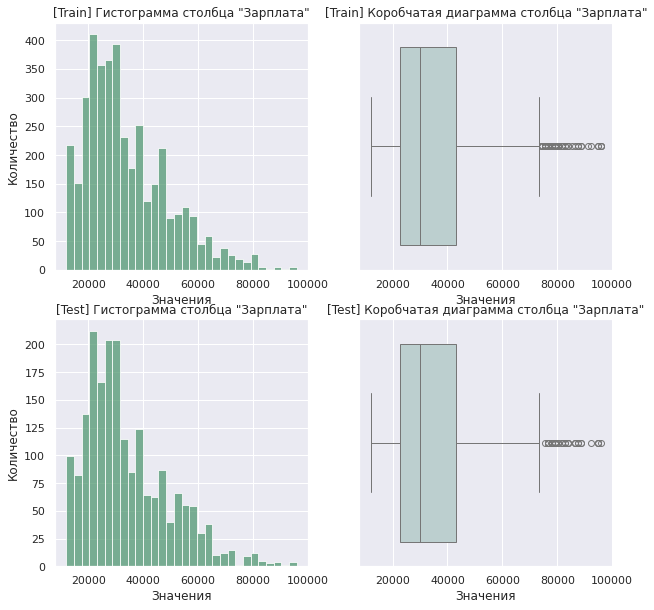

In [209]:
plot_graphics(train_quit, 'salary', test_df=test_features, col_alias='"Зарплата"')

In [210]:
pd.DataFrame(
    [train_quit.salary.describe(), 
     test_features.salary.describe()]).T.set_axis(['train salary', 'test_salary'], axis=1).round(2)

train salary  test_salary
count       4000.00      2000.00
mean       33805.80     34066.80
std        15152.42     15398.44
min        12000.00     12000.00
25%        22800.00     22800.00
50%        30000.00     30000.00
75%        43200.00     43200.00
max        96000.00     96000.00

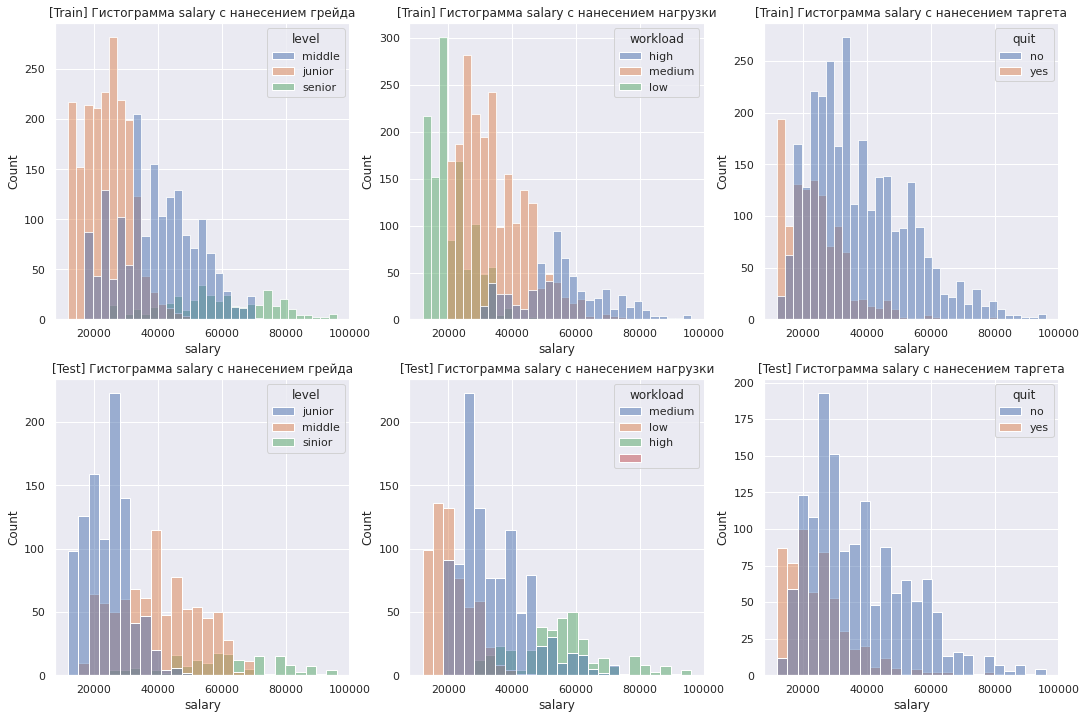

In [211]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
ax = ax.flatten()

params = zip(ax[:3], 
             ['level', 'workload', 'quit'], 
             ['[Train] Гистограмма salary с нанесением грейда', 
              '[Train] Гистограмма salary с нанесением нагрузки',
              '[Train] Гистограмма salary с нанесением таргета',                     
              
             ])

for p in params:
    g = sns.histplot(
    data=train_quit, 
    x='salary', 
    hue=p[1], ax=p[0])
    g.set_title(p[2]);
    
    
params = zip(ax[3:], 
             ['level', 'workload', 'quit'], 
             ['[Test] Гистограмма salary с нанесением грейда', 
              '[Test] Гистограмма salary с нанесением нагрузки',       
              '[Test] Гистограмма salary с нанесением таргета',                     
              
             ])

for p in params:
    g = sns.histplot(
    data=test_features.merge(test_target_quit, how='inner', on='id'), 
    x='salary', 
    hue=p[1], ax=p[0])
    g.set_title(p[2]);

- Зарплаты синьоров смещены вправо в область высоких зарплат, джуны получают до 50к
- Высокая нагрузка влечет смещение гистограммы зарплат в большую сторону. Чем больше нагрузка - тем правее расположена гистограмма зарплат
- Зарплата уволенных сотрудников в основном не превышает 50к, в тестовой выборке - до 60к

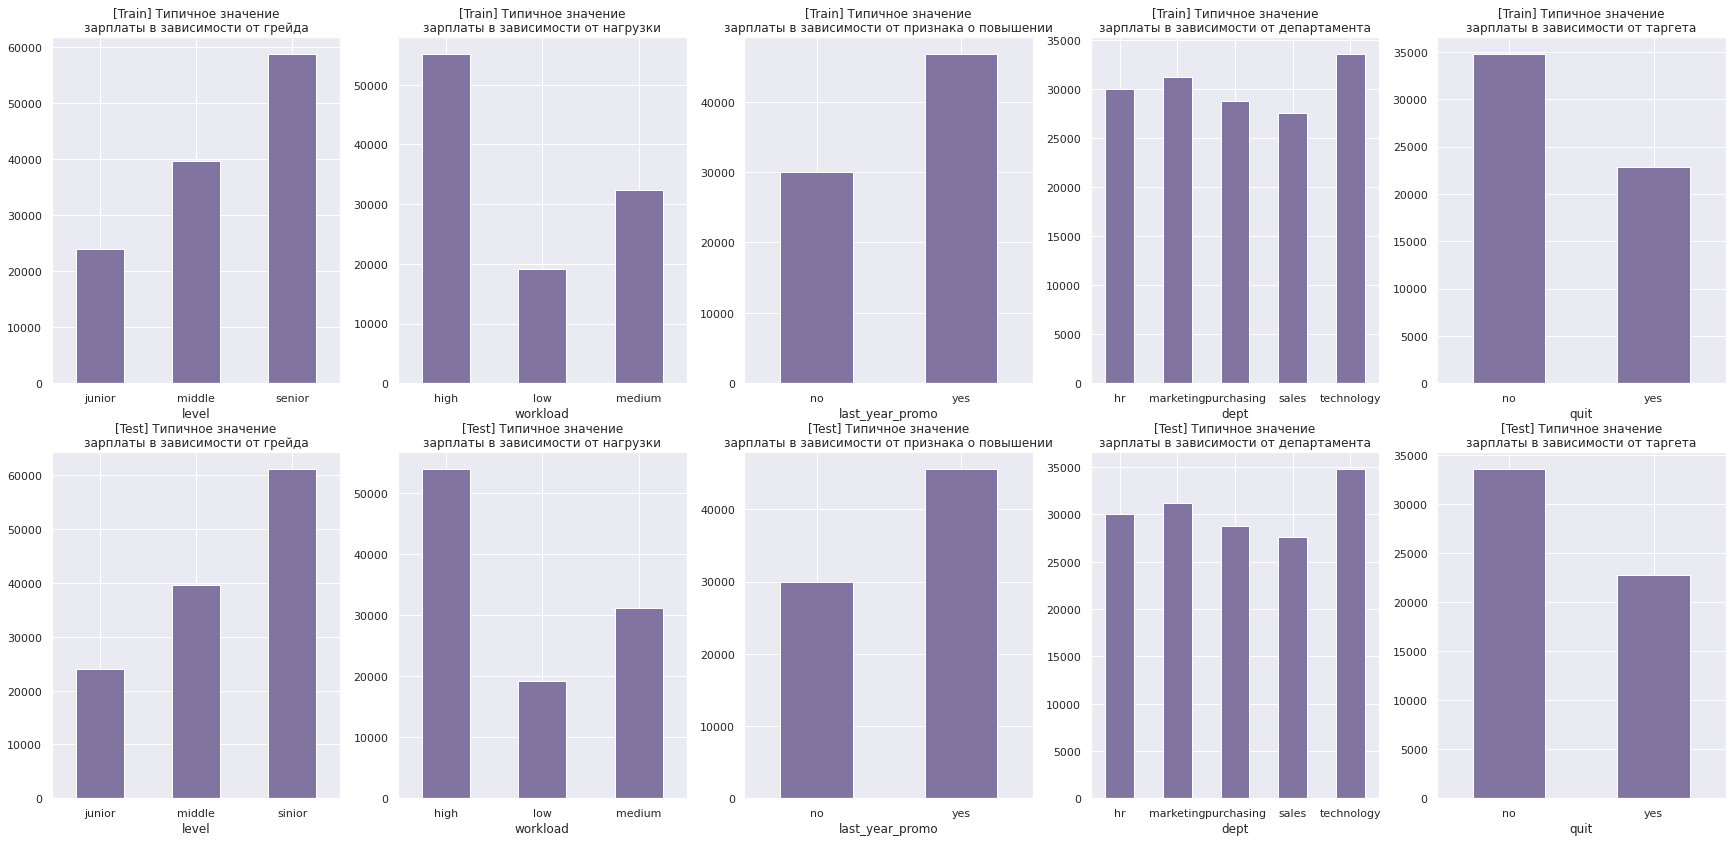

In [213]:
fig, ax = plt.subplots(2, 5, figsize=(30, 14))
ax = ax.flatten()
templ = '[Train] Типичное значение\nзарплаты в зависимости от '
params = zip(ax[:5], 
             ['level', 'workload', 'last_year_promo', 'dept', 'quit'], 
             [templ + 'грейда', 
              templ + 'нагрузки',   
              templ + 'признака о повышении',                     
              templ + 'департамента',                     
              templ + 'таргета',                     
             ])

for p in params:
    (train_quit.pivot_table(
        index=p[1], 
        values='salary', 
        aggfunc='median')[['salary']]
    .plot(kind='bar', ax=p[0], legend=False, title=p[2], color=DEFAULT_COLOR)
    )
    
    p[0].tick_params(rotation=0)
    
templ = '[Test] Типичное значение\nзарплаты в зависимости от '
params = zip(ax[5:], 
             ['level', 'workload', 'last_year_promo', 'dept', 'quit'], 
             [templ + 'грейда', 
              templ + 'нагрузки',   
              templ + 'признака о повышении',                     
              templ + 'департамента',                     
              templ + 'таргета',                     
             ])

for p in params:
    (test_features.query('workload != " " and dept != " "').merge(test_target_quit, how='inner', on='id').pivot_table(
        index=p[1], 
        values='salary', 
        aggfunc='median')[['salary']]
    .plot(kind='bar', ax=p[0], legend=False, title=p[2], color=DEFAULT_COLOR)
    )
    
    p[0].tick_params(rotation=0)

- Синьоры в среднем получают больше всех.
- Сотрудники с высокой нагрузкой получают наибольшую зарплату
- Сотрудники, которые за последний год получили повышение, в среднем получают большую зарплату чем сотрудники без повышения
- В отделе технологий работают самые высокооплачиваемые сотрудники
- В среднем уволенные получали меньше

#### Столбец `quit`

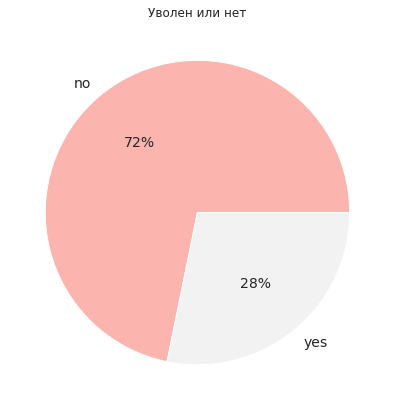

In [219]:
(train_quit['quit']
     .value_counts()
     .plot(
         kind='pie',
         autopct="%.0f%%",
         ylabel="",
         title=f"Уволен или нет",
         colormap='Pastel1',
         figsize=(7, 7),
         fontsize=14
));

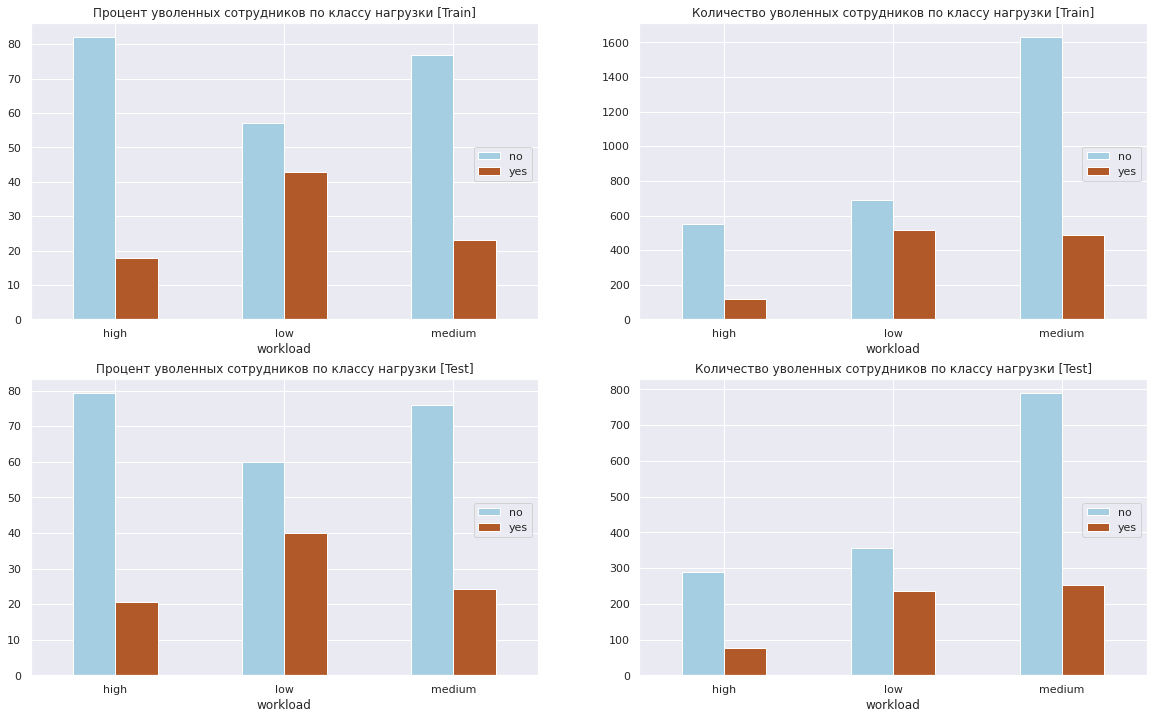

In [221]:
promo_violations_percentage(train_quit, 
                            test_features.query('workload != " " and dept != " "').merge(test_target_quit, how='inner', on='id'),
                            title_part='уволенных сотрудников по классу нагрузки',
                            index_var='workload', 
                            col_var='quit')

- Итак, самый большой процент увольнений среди сотрудников с низкой нагрузкой, аналогично в тестовой выборке
- Более занятые сотрудники меньше всего подвержены уходу из компании (возможно из-за удовлетворенности ЗП, следует вспомнить из задачи №1 для датасета `test_features.csv`, что сотрудники с высокой нагрузкой более удовлетворены работой)

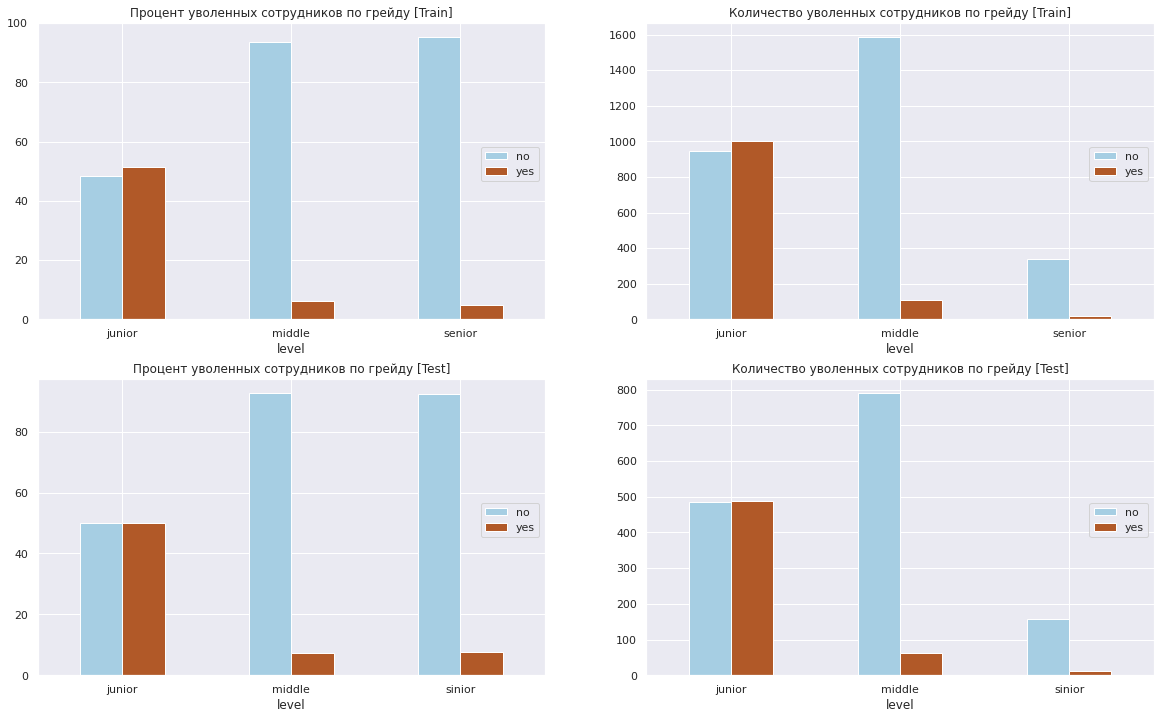

In [222]:
promo_violations_percentage(train_quit, 
                            test_features.query('workload != " " and dept != " "').merge(test_target_quit, how='inner', on='id'),
                            title_part='уволенных сотрудников по грейду',
                            index_var='level', 
                            col_var='quit')

- Тенденция для джунов весьма печальная: больше половины молодых сотрудников были уволены, значит на отсутствие джунов влияет прежде всего не повышение грейда, а их отток из компании
- В тестовой выборке ситуация схожая, однако для джунов ситуация более сбалансированная

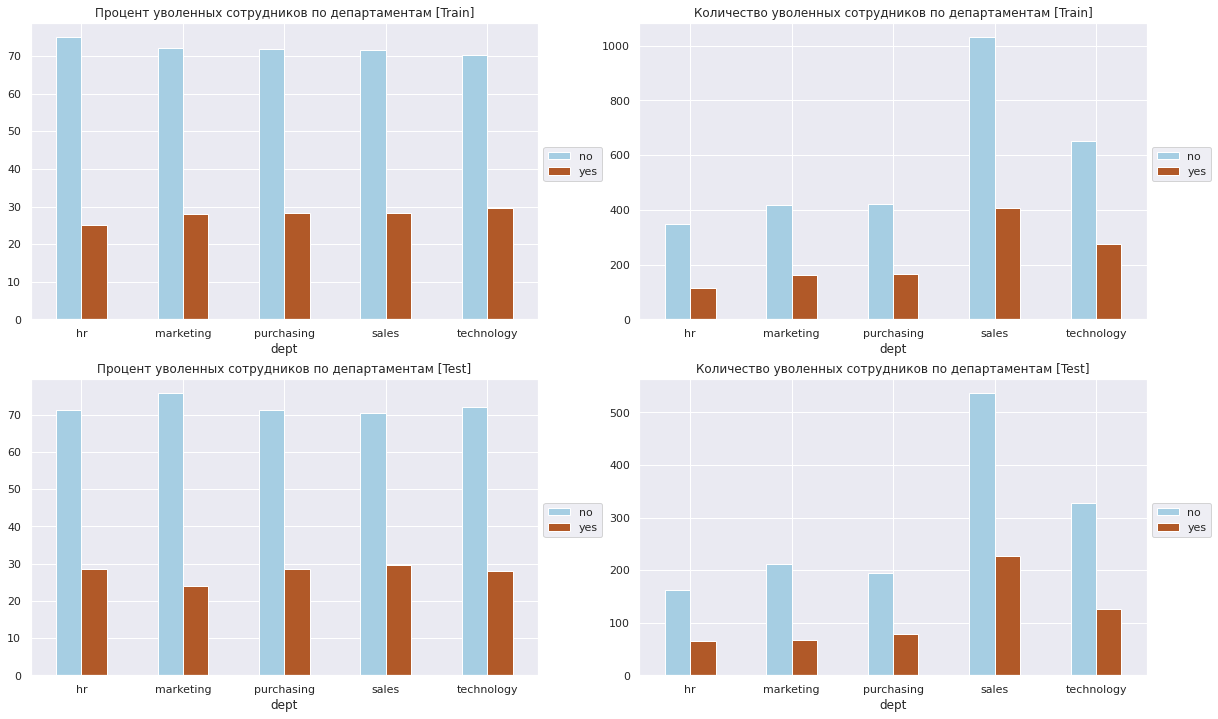

In [227]:
promo_violations_percentage(train_quit, 
                            test_features.query('workload != " " and dept != " "').merge(test_target_quit, how='inner', on='id'), 
                            title_part='уволенных сотрудников по департаментам',
                            index_var='dept', 
                            col_var='quit')

- В процентном соотношении департамент практически не влияет на уольнения. Однако больше всего увольнений как в тренировочной, так и в тестовой выборках было произведено в отделе продаж

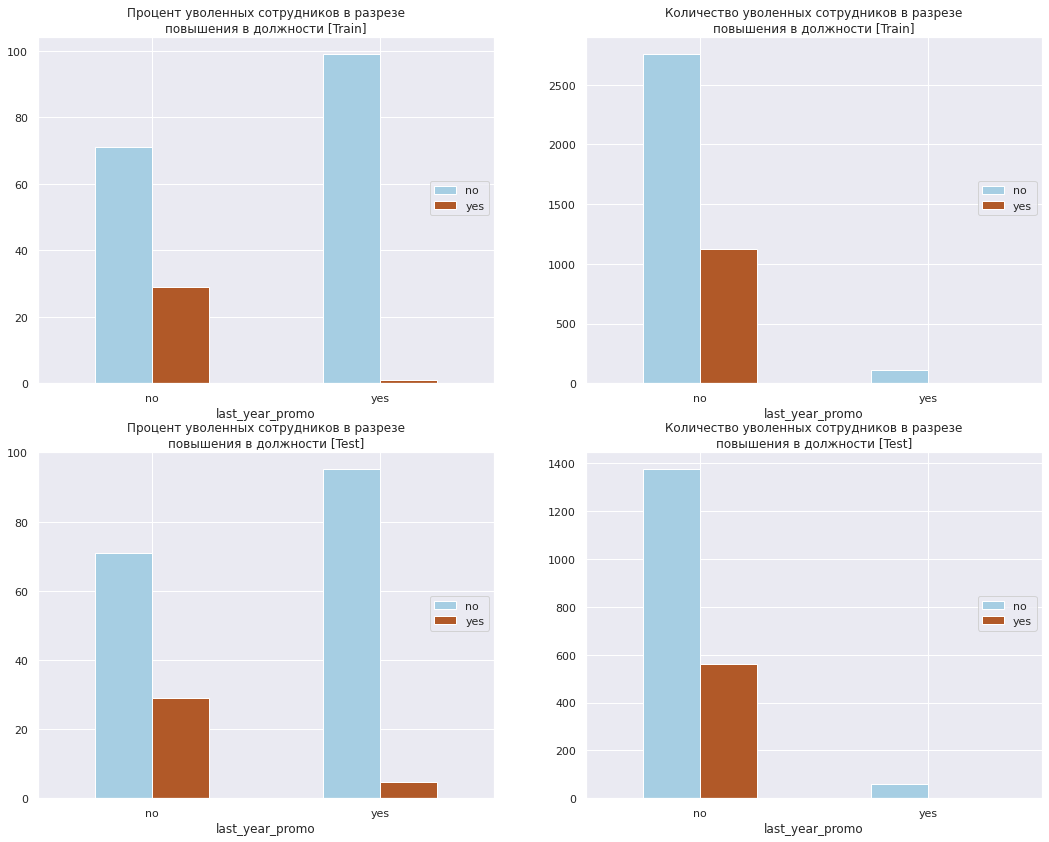

In [228]:
promo_violations_percentage(train_quit, 
                            test_features.merge(test_target_quit, how='inner', on='id'), 
                            title_part='уволенных сотрудников в разрезе\nповышения в должности', 
                            index_var='last_year_promo', 
                            col_var='quit', figsize=(18, 14))

- Сотрудники, получившие в прошлом году повышение, практически не увольняются
- В случае отсутствия повышения 30% сотрудников уволились

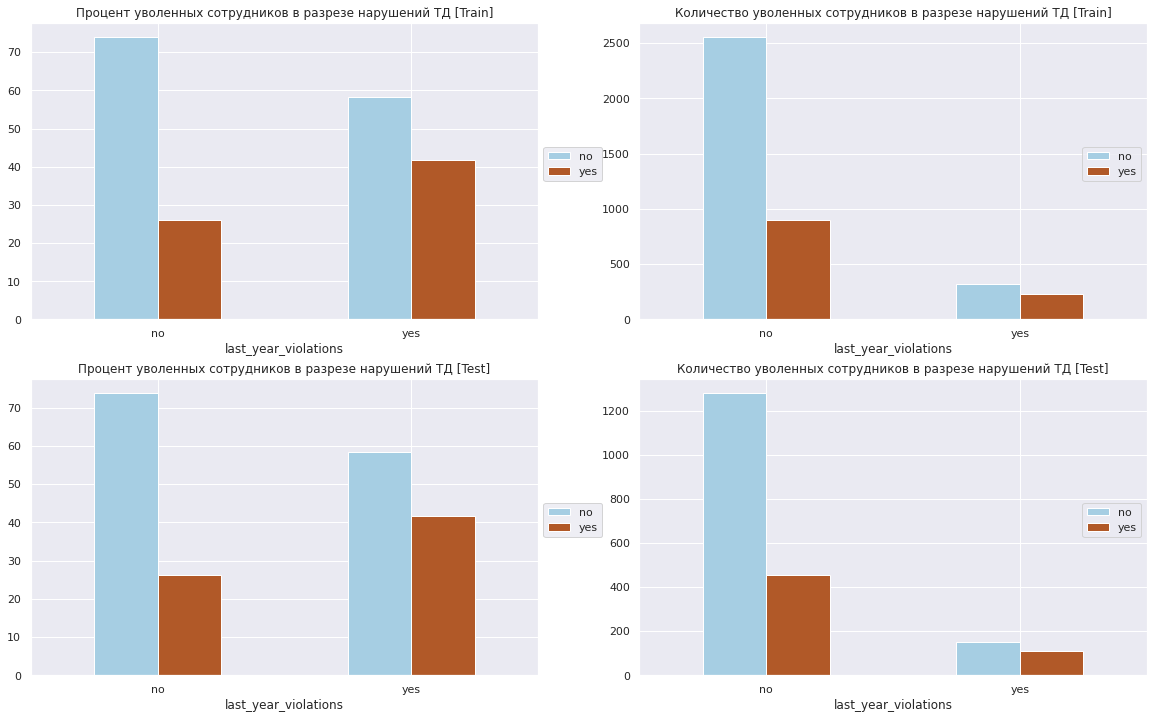

In [229]:
promo_violations_percentage(train_quit, 
                            test_features.merge(test_target_quit, how='inner', on='id'), 
                            title_part='уволенных сотрудников в разрезе нарушений ТД', 
                            index_var='last_year_violations', 
                            col_var='quit')

- Нарушение ТД характерно для уволившихся сотрудников, таких работников около 40%. В тестовой выборке все аналогично

Итак, составим портрет уволившегося сотрудника

1. **Грейд**:  
   - Чаще всего джуны (более половины уволившихся).  
   - Меньше всего синьоров и опытных сотрудников.  

2. **Нагрузка**:  
   - Наибольший процент увольнений среди сотрудников с низкой нагрузкой.  
   - Сотрудники с высокой нагрузкой увольняются реже всего.  

3. **Департамент**:  
   - Наибольшее количество увольнений в отделе продаж.  
   - Департамент в целом не сильно влияет на процент увольнений.  

4. **Опыт работы**:  
   - Джуны с небольшим опытом работы (менее 2 лет) увольняются чаще.  
   - Сотрудники, работающие более 6 лет, увольняются редко.  

5. **Повышение**:  
   - Сотрудники, получившие повышение в прошлом году, практически не увольняются.  
   - Отсутствие повышения увеличивает вероятность увольнения (около 30% таких сотрудников ушли).  

6. **Нарушение трудового договора**:  
   - Около 40% уволившихся сотрудников нарушали трудовой договор.  

7. **Оценка руководителя**:  
   - Уволенные сотрудники чаще получали оценки 2-4 от руководителя.  

8. **Зарплата**:  
   - Зарплата уволенных сотрудников обычно не превышает 50-60к.  
   - Сотрудники с высокой зарплатой увольняются реже.  

9. **Тенденции**:  
    - У джунов высокий отток из компании, что связано не с повышением, а с увольнением.  
    - Сотрудники, работающие в компании более 4 лет, реже увольняются.  

Теперь коротко:

**Уволившийся сотрудник — это чаще всего джун с низкой нагрузкой, небольшим опытом работы (менее 2 лет), низкой зарплатой (до 50-60к, а в среднем 23к) и без повышения в прошлом году. Он мог нарушить трудовой договор и получил среднюю или низкую оценку от руководителя.**

In [230]:
train_quit['job_satisfaction_rate'] = regressor_forest.best_estimator_.predict(train_quit.drop(columns=['quit', 'id']))
test_features['job_satisfaction_rate'] = regressor_forest.best_estimator_.predict(test_features.drop(columns=['id']))

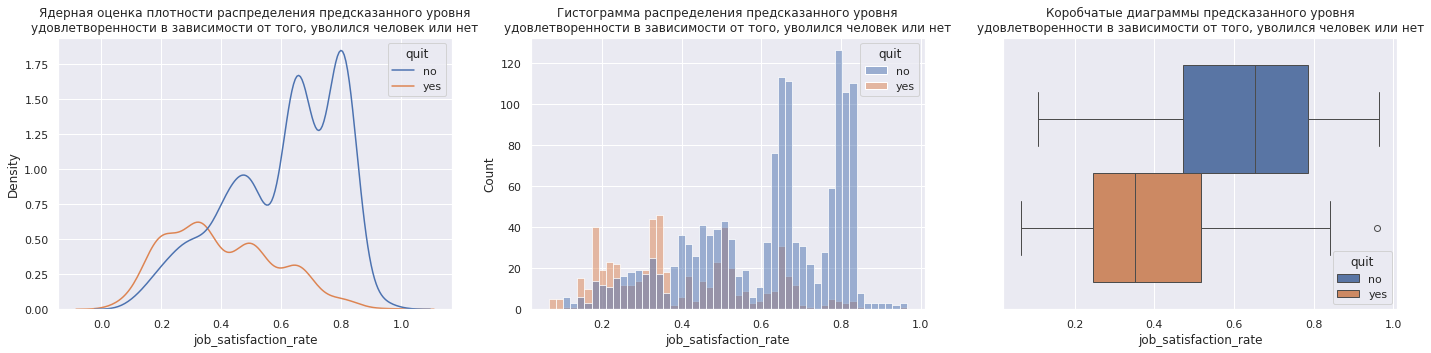

In [231]:
fig, ax = plt.subplots(1, 3, figsize=(24, 5))

sns.kdeplot(
    data=test_features.merge(test_target_quit, how='inner', on='id'),
    x='job_satisfaction_rate',
    hue='quit',
    ax=ax[0]
).set_title('Ядерная оценка плотности распределения предсказанного уровня\nудовлетворенности в зависимости от того, уволился человек или нет');

sns.histplot(
    data=test_features.merge(test_target_quit, how='inner', on='id'),
    x='job_satisfaction_rate',
    hue='quit',
    bins=50,
    ax=ax[1]
).set_title('Гистограмма распределения предсказанного уровня\nудовлетворенности в зависимости от того, уволился человек или нет');

sns.boxplot(
    data=test_features.merge(test_target_quit, how='inner', on='id'),
    x='job_satisfaction_rate',
    hue='quit',
    ax=ax[2]
).set_title('Коробчатые диаграммы предсказанного уровня\nудовлетворенности в зависимости от того, уволился человек или нет');

- Существует определенная связь между удовлетворенностью работой и решением об увольнении.
- Распределение удовлетворенности для уволившихся смещено влево, в область более низкой удовлетворенности

## Корреляционный анализ

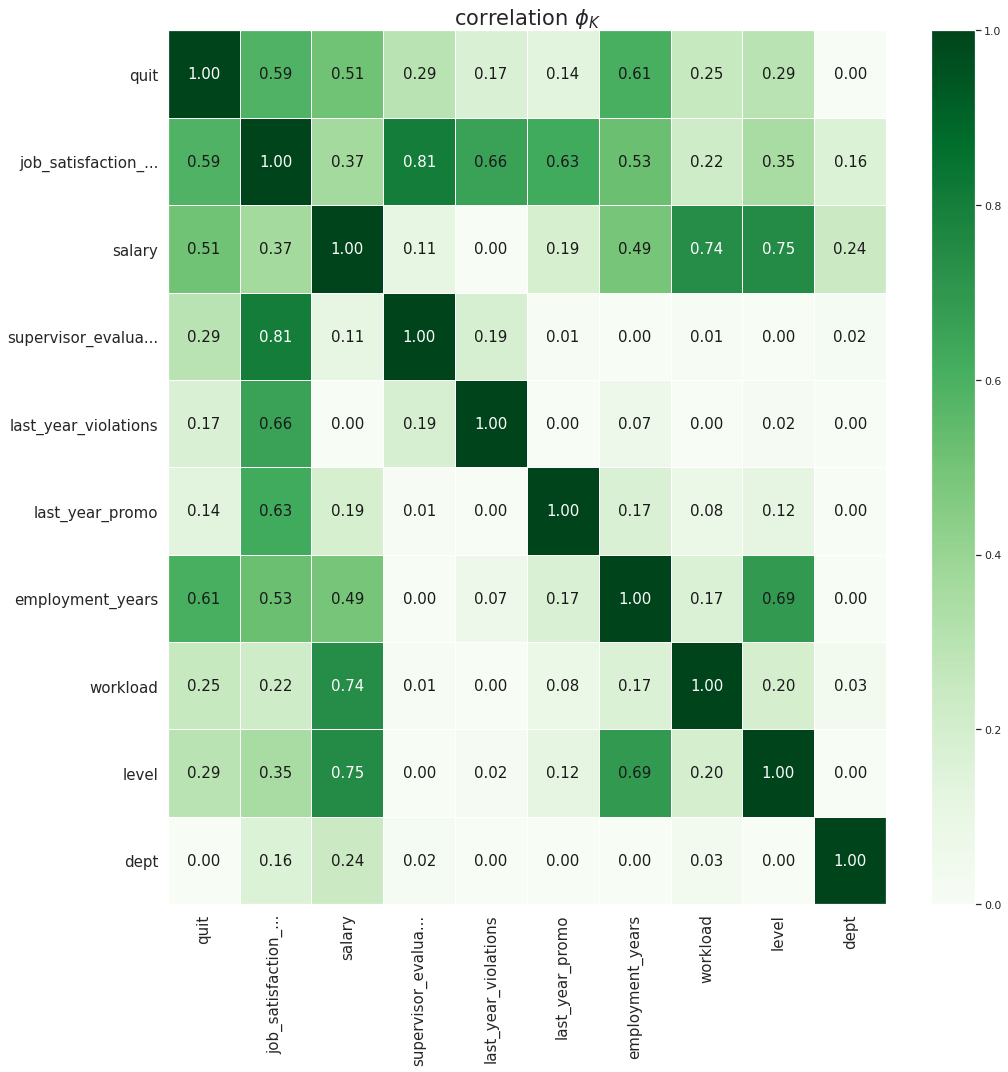

In [233]:
warnings.filterwarnings("ignore", category=UserWarning)
phik_overview = test_features.merge(test_target_quit, how='inner', on='id').drop(columns='id').phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 15)
) 

- Видим, что добавленный признак имеет явную взаимосвязь с таргетом - $\varphi_k=0.59$
- Департамент имеет нулевую корреляцию с таргетом, поэтому не будем использовать его при обучении модели

In [235]:
phik_overview[['quit']].drop(index='id', errors='ignore').sort_values(by='quit')

quit
dept                   0.000000
last_year_promo        0.137762
last_year_violations   0.174740
workload               0.253097
level                  0.293623
supervisor_evaluation  0.294738
salary                 0.508308
job_satisfaction_rate  0.586267
employment_years       0.605927
quit                   1.000000

In [236]:
temp = (train_quit
        .drop(columns=['id'], errors='ignore'))



market_file_numerical_columns = (temp
                                 .select_dtypes(['float64', 'int', 'int64'])
                                 .columns)

df = pd.DataFrame(temp[market_file_numerical_columns], 
                  columns=market_file_numerical_columns)

X = add_constant(df)

vif = pd.DataFrame(
    {
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    }
)
vif

Variable        VIF
0                  const  17.875723
1       employment_years   1.388841
2  supervisor_evaluation   2.372970
3                 salary   1.285085
4  job_satisfaction_rate   2.466807

- Мультиколлинеарность не наблюдается

In [237]:
categories = list(train_quit.select_dtypes(include='object').columns)
num_cols = list(train_quit.drop(columns='id').select_dtypes(exclude='object').columns)

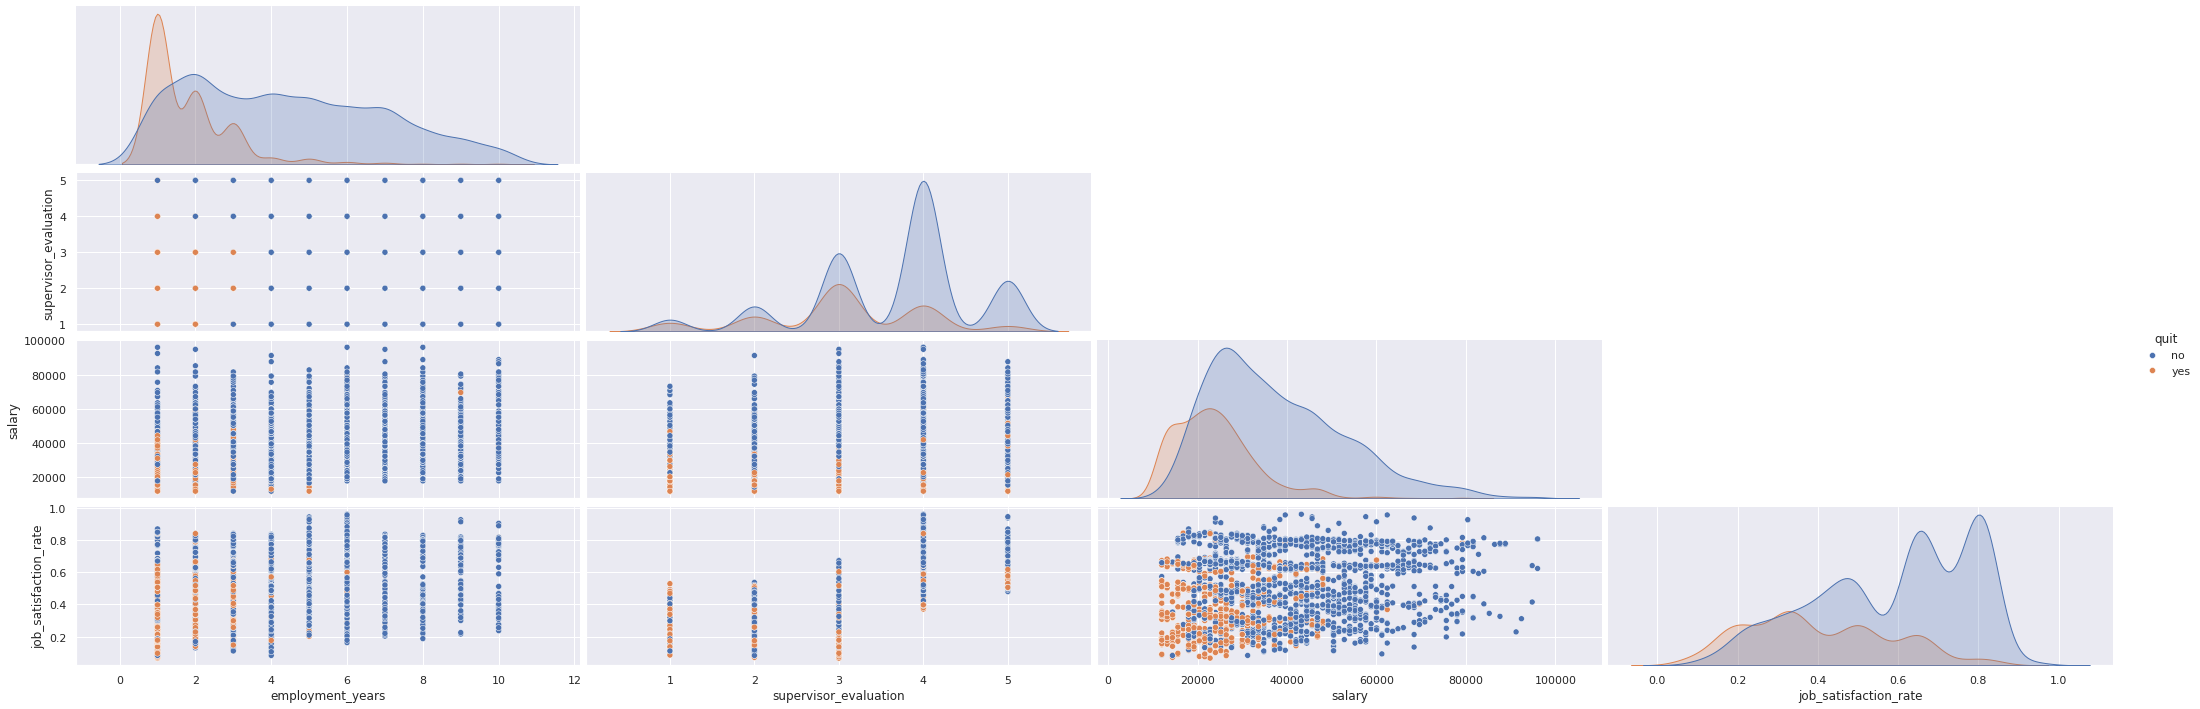

In [238]:
g = sns.pairplot(data=train_quit.dropna().drop(columns='id'),
                 hue='quit', 
                 aspect=3, 
                 corner=True)

1. **Корреляция с таргетом**:  
   - Добавленный признак имеет сильную взаимосвязь с таргетом (𝜑𝑘 = 0.59).  
   - Департамент не коррелирует с таргетом (𝜑𝑘 ≈ 0), поэтому его исключим из модели.  

2. **Мультиколлинеарность**:  
   - Признаки не демонстрируют мультиколлинеарности.  

3. **Зарплата уволившихся**:  
   - Уволенные сотрудники в основном получали низкие зарплаты (зарплаты локализованы в нижнем диапазоне)

## Обучение модели

In [239]:
train = train_quit.drop(columns='id').drop_duplicates()

In [240]:
label_encoder = LabelEncoder()

In [244]:
X_train = train.drop(columns=['id', 'quit', 'dept'], errors='ignore')
y_train = train.quit
y_train = label_encoder.fit_transform(y_train)

In [245]:
test = test_features.merge(test_target_quit, on='id', how='inner')
X_test = test.drop(columns=['id', 'quit', 'dept'])
y_test = test.quit
y_test = label_encoder.transform(y_test)

In [248]:
ohe_columns = ['last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = X_train.select_dtypes(['float64', 'int', 'int64']).columns

In [249]:
num_columns

Index(['employment_years', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object')

In [250]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

In [251]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high'],                     
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [252]:
data_preprocessor = ColumnTransformer(
    [
     ('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns),  
    ], 
    remainder='drop'
)

pipe_final = Pipeline([
    ('preprocess_func', preprocessing_step),
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor())
])

In [253]:
param_grid_tree = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(2, 12, 1),
        'models__max_features': range(2, 12, 1),
        'models__min_samples_leaf': range(1, 10, 1),
        'models__min_samples_split': range(2, 10, 1),
        'preprocessor__num': [StandardScaler(), 'passthrough', MinMaxScaler()]  
    }
]

randomized_search_tree = RandomizedSearchCV(
    pipe_final, 
    param_grid_tree, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise',
)

warnings.filterwarnings("ignore", category=UserWarning)
randomized_search_tree.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocess_func',
                                              FunctionTransformer(func=<function preprocess_data at 0x7fbd987038b0>)),
                                             ('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              s...
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeClassifier(class_weight='balanced',
                                                                           random_state=42)],
                                         'models__max_depth': range(2, 12),
                                         'models__max_features': range(2, 12),
                                         'models__min_samples_leaf': range(1, 10),
                                         'models__min_samples_split': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               'passthrough',
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [254]:
param_grid_logreg = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='saga', 
            penalty='l2',
            class_weight='balanced',
        )],
        'models__C': np.arange(0.01, 0.8, 0.01),
        'preprocessor__num': ['passthrough', StandardScaler(), MinMaxScaler()]  
    }
]

randomized_search_logreg = RandomizedSearchCV(
    pipe_final, 
    param_grid_logreg, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    error_score='raise',
)

warnings.filterwarnings("ignore", category=UserWarning)
randomized_search_logreg.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocess_func',
                                              FunctionTransformer(func=<function preprocess_data at 0x7fbd987038b0>)),
                                             ('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              s...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79]),
                                         'preprocessor__num': ['passthrough',
                                                               StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [255]:
param_grid_knn = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': np.arange(3, 20, 1),
        'preprocessor__num': ['passthrough', StandardScaler(), MinMaxScaler()]  
    }
]

randomized_search_knn = RandomizedSearchCV(
    pipe_final, 
    param_grid_knn, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    error_score='raise',
)

warnings.filterwarnings("ignore", category=UserWarning)
randomized_search_knn.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocess_func',
                                              FunctionTransformer(func=<function preprocess_data at 0x7fbd987038b0>)),
                                             ('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              s...
                                                                               Index(['employment_years', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object'))])),
                                             ('models',
                                              DecisionTreeRegressor())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                         'preprocessor__num': ['passthrough',
                                                               StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [256]:
param_grid_forest = [
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, n_estimators=300)],
        'models__max_depth': range(2, 12, 1),
        'models__max_features': range(2, 12, 1),
        'models__min_samples_leaf': range(1, 10, 1),
        'models__min_samples_split': range(2, 10, 1),
        'preprocessor__num': [StandardScaler()]  
    }
]

regressor_forest = RandomizedSearchCV(
    pipe_final, 
    param_grid_forest, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    # n_iter=100,
    error_score='raise',
)
warnings.filterwarnings("ignore", category=UserWarning)
regressor_forest.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocess_func',
                                              FunctionTransformer(func=<function preprocess_data at 0x7fbd987038b0>)),
                                             ('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              s...
                                              DecisionTreeRegressor())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [RandomForestClassifier(n_estimators=300,
                                                                           n_jobs=-1,
                                                                           random_state=42)],
                                         'models__max_depth': range(2, 12),
                                         'models__max_features': range(2, 12),
                                         'models__min_samples_leaf': range(1, 10),
                                         'models__min_samples_split': range(2, 10),
                                         'preprocessor__num': [StandardScaler()]}],
                   random_state=42, scoring='roc_auc')

In [257]:
estimators = [randomized_search_knn, randomized_search_logreg, randomized_search_tree, regressor_forest]
scores = pd.DataFrame([{'train AUC ROC': est.best_score_} for est in estimators], index=['KNN', 'LogReg', 'DecTree', 'RF'])
scores

train AUC ROC
KNN           0.910529
LogReg        0.902548
DecTree       0.903591
RF            0.916616

In [258]:
best_pipeline = estimators[scores['train AUC ROC'].argmax()]
best_model_clf = best_pipeline.best_estimator_.named_steps['models']
preprocessor_clf = best_pipeline.best_estimator_.named_steps['preprocessor']
features_clf = preprocessor_clf.get_feature_names_out()

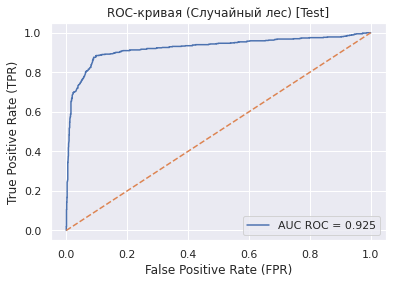

In [259]:
fpr, tpr, threshold = roc_curve(y_test, best_pipeline.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.title(f"ROC-кривая (Случайный лес) [Test]")
plt.xlabel('False Positive Rate (FPR)')
plt.legend([f'AUC ROC = {roc_auc_score(y_test, best_pipeline.predict_proba(X_test)[:,1]).round(3)}'])
plt.ylabel('True Positive Rate (TPR)');

- Лучшим пайплайном оказался случайный лес, метрика AUC ROC на тестовой выборке составила 0.925, что соответствует критериям успеха задачи

## Анализ важности признаков

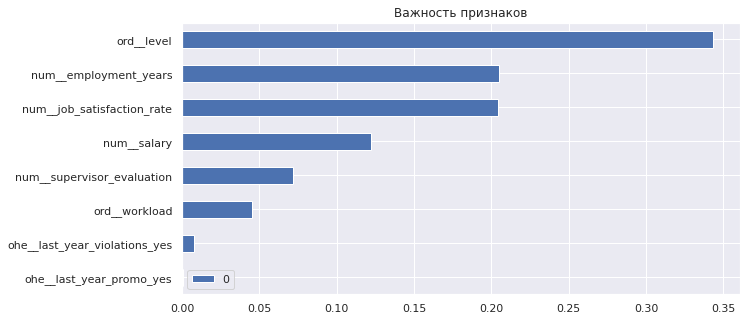

In [260]:
pd.DataFrame(best_model_clf.feature_importances_, index=features_clf).sort_values(0).plot(kind='barh', figsize=(10,5), title='Важность признаков');

- Случайный лес определил для себя главным фактором именно грейд сотрудника
- Также длительность работы, оценка удовлетворенности, зарплата и оценка руководителя сильно влияют на предсказания леса

In [261]:
X = pd.DataFrame(
    data=preprocessor_clf.transform(X_test), 
    columns=features_clf)

In [262]:
explainer = shap.Explainer(best_model_clf)
shap_values = explainer(X)

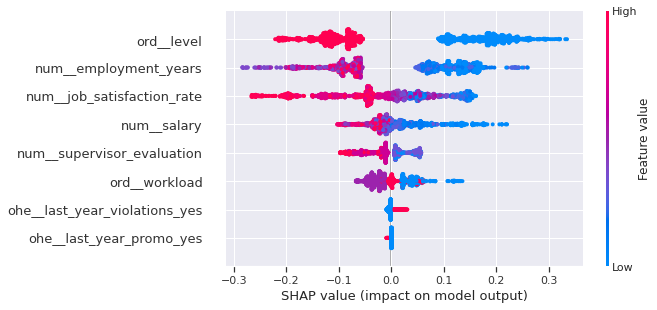

In [263]:
shap.plots.beeswarm(shap_values[:,:,1]) 

In [264]:
label_encoder.classes_, label_encoder.transform(label_encoder.classes_)

(array(['no', 'yes'], dtype=object), array([0, 1]))

- Факторы, такие как удовлетворенность работой, стаж, зарплата и положительная оценка руководителя, снижают вероятность увольнения.

- Низкая нагрузка и наличие нарушений в прошлом году увеличивают вероятность увольнения.

- Получение повышения также положительно влияет на удержание сотрудников.

## Отбор признаков

Попытаемся улучшить качество пайплайна, сделав отбор признаков

In [265]:
grids = [
    ('RF', best_pipeline),
]

results = []

for estim in grids:
    for i in range(0, len(features_clf), 1):

        p = Pipeline([
    ('preprocessor', estim[1].best_estimator_.named_steps['preprocessor']),
    ('selector', SelectKBest(mutual_info_classif, k=i+1)),
    ('models', estim[1].best_estimator_.named_steps['models']),      
    ])
        
        
        scores = cross_val_score(p, X_train, y_train, cv=5, scoring='roc_auc_ovr')
    
        results.append(
        {
            'auc_roc': np.mean(scores)
        }
        )

In [266]:
pd.DataFrame(results, index=np.arange(1, len(features_clf)+1, 1)).round(3)

auc_roc
1    0.812
2    0.858
3    0.873
4    0.907
5    0.907
6    0.914
7    0.915
8    0.916

Видим, что максимальное значение на кросс-валидации дают все 8 признаков

In [267]:
p = Pipeline([
    ('preprocessor', preprocessor_clf),
    ('selector', SelectKBest(mutual_info_classif, k=8)),
    ('models', best_model_clf),
    ])

p.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='...
                                                 ('num', StandardScaler(),
                                                  Index(['employment_years', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object'))])),
                ('selector',
                 SelectKBest(k=8,
                             score_func=<function mutual_info_classif at 0x7fbd9ea6c670>)),
                ('models',
                 RandomForestClassifier(max_depth=6, max_features=4,
                                        min_samples_leaf=9, min_samples_split=6,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [268]:
roc_auc_score(y_test, p.predict_proba(X_test)[:,1]).round(3)

0.925

# Выводы

В ходе работы над задачами №1-2 были проведены следующие работы

- Датасеты `train_job_satisfaction_rate.csv`, `train_quit.csv` и `test_features.csv` были изучены на предмет типов данных, дубликатов и пропусков, а также явных особенностей распределения столбцов. Затем они были подвергнуты предобработке, в ходе которой были найдены заменены неявные дубликаты, исправлены опечатки, а пропущенные, но неотмеченные NaN-значениями элементы таблиц были заменены на np.nan 

- Затем началась работа над задачей №1, в начале которой был произведен детальный исследовательский анализ, который показал, что карьерный рост в компании зависит от стажа (после 4 лет повышение вероятно), а синьоры чаще имеют высокую нагрузку и зарплату. Джуны и опытные специалисты чаще нарушают трудовой договор, а сотрудники со средней нагрузкой менее удовлетворены работой. Удовлетворенность выше у тех, кто получил повышение или не нарушает правила.

- Корреляционный анализ показал, что наибольшая взаимосвязь с целевой переменной наблюдается у оценки руководителя, нарушений трудовой дисциплины и стажа работы. Зарплата тесно связана с нагрузкой и грейдом, а грейд - с продолжительностью работы в компании. Сотрудники уровня senior с высокой зарплатой чаще удовлетворены работой (удовлетворенность > 0.25). Повышение повышает удовлетворенность, а нарушения трудовой дисциплины снижают её. Признаки мультиколлинеарности отсутствуют.

- Модель случайного леса показала наилучшие результаты с SMAPE = 13.43, что соответствует требованиям задачи. Распределение остатков симметрично и близко к нулю, что указывает на точность модели. Однако в области низких оценок (до 0.2) модель склонна завышать предсказания, а в области высоких оценок — занижать. В диапазоне от 0.2 до 0.8 ошибки распределены равномерно.

- Случайный лес выделил оценку руководителя как ключевой фактор. Также значимое влияние оказывают стаж работы, нарушения трудовой дисциплины, зарплата и грейд. Признаки, связанные с департаментами, имеют минимальное влияние на предсказания модели.

- Далее была решена задача №2, в начале которой также был проведен исследовательский анализ, призванный помочь понять закономерности в данных и составить типичный портрет уволенного сотрудника

- Портрет: уволившийся сотрудник — чаще всего джун с низкой нагрузкой, опытом работы до 2 лет, зарплатой в среднем 23к (до 50-60к) и без повышений. Такие сотрудники нередко нарушают трудовой договор и получают средние или низкие оценки от руководителя.

- Далее в выборку был добавлен новый признак, спрогнозированный при помощи модели, обученной в задаче №1. Оказалось, что он сильно достаточно сильно коррелирует с таргетом (около 0.6). Кроме того, оказалось, что признак `dept` имеет околонулевую корреляцию с таргетом, поэтому он был исключен из тренировочного датасета, используемого для обучения модели. С помощью диаграмм рассеяния было подтверждено наличине взаимосвязи таргета с ЗП: уволенные сотрудники чаще получали низкие зарплаты.

- Далее было обучено несколько классификаторов на кросс-валидации с использованием пайплайнов. Лучший результат показал случайный лес с AUC ROC = 0.925 на тестовой выборке, что соответствует критериям успеха задачи.

- Была предпринята попытка улучшения качества предсказания методом отбора признаков, но к сожалению лучшим наборов признаков оказался весь исходный набор, поэтому уменьшение количества признаков не привело к большим значениям метрики качества

- Вероятность увольнения снижают удовлетворенность работой, стаж, высокая зарплата и положительная оценка руководителя. Повышение также способствует удержанию. Низкая нагрузка и нарушения в прошлом году увеличивают риск увольнения.

- **Рекомендации:**  
1. Повысить зарплату и обеспечить адекватную нагрузку для джунов, внедрить программы наставничества.  
2. Предлагать интересные задачи сотрудникам с низкой нагрузкой и активно поощрять высокооцененных сотрудников.  
3. Усилить контроль за соблюдением трудовой дисциплины и организовать тренинги по корпоративной культуре.  
4. Регулярно пересматривать зарплаты и внедрить систему поощрений для повышения мотивации.  
5. Поддерживать долгосрочных сотрудников, предлагая им новые вызовы и возможности для развития.  
